# Case 2 - Siemens Smart Infrastructure

In [1]:
# Packages
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
# from pandas_profiling import ProfileReport
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats.mstats import winsorize
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import LabelEncoder
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [2]:
!pip install pandas-profiling

  Using cached pandas_profiling-3.2.0-py2.py3-none-any.whl.metadata (21 kB)
  Using cached joblib-1.1.1-py2.py3-none-any.whl.metadata (5.2 kB)
  Using cached visions-0.7.4-py3-none-any.whl.metadata (5.9 kB)
  Using cached htmlmin-0.1.12.tar.gz (19 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  ERROR: Error [WinError 225] A operação não foi concluída com êxito porque o ficheiro contém um vírus ou software potencialmente indesejável while executing command python setup.py egg_info
ERROR: Could not install packages due to an OSError: [WinError 225] A operação não foi concluída com êxito porque o ficheiro contém um vírus ou software potencialmente indesejável



In [3]:
!pip install catboost

In [4]:
# Global definitions
baseFolder = os.getcwd()
exportsFolder = baseFolder + os.sep +'Exports' + os.sep

# Source: professor's notebook

In [5]:
subPlots_Title_fontSize = 12
subPlots_xAxis_fontSize = 10
subPlots_yAxis_fontSize = 10
subPlots_label_fontSize = 10
heatmaps_text_fontSize = 8

plots_Title_fontSize = 14
plots_Title_textColour = 'black'

plots_Legend_fontSize = 12
plots_Legend_textColour = 'black'

plots_barTexts_fontSize = 8

# Source: professor's notebook

In [6]:
'''
# Generating a profile report to better explore the data
ProfileReport(  
    sales_data,    
    title='Sales Data',
    correlations={
        "pearson": {"calculate": True},
        "spearman": {"calculate": True},
       "kendall": {"calculate": True},
        "phi_k": {"calculate": True},
        "cramers": {"calculate": True},
    },                 
)
'''

'\n# Generating a profile report to better explore the data\nProfileReport(  \n    sales_data,    \n    title=\'Sales Data\',\n    correlations={\n        "pearson": {"calculate": True},\n        "spearman": {"calculate": True},\n       "kendall": {"calculate": True},\n        "phi_k": {"calculate": True},\n        "cramers": {"calculate": True},\n    },                 \n)\n'

# Preparing Sales Data

## Daily Sales

In [7]:
# Load data 
df = pd.read_csv("Case2_Sales data.csv", sep=";")
df.head(10)

# Source: previous project notebook

DATE Mapped_GCK Sales_EUR
0  01.10.2018         #1         0
1  02.10.2018         #1         0
2  03.10.2018         #1         0
3  04.10.2018         #1         0
4  05.10.2018         #1         0
5  06.10.2018         #1         0
6  08.10.2018         #1         0
7  09.10.2018         #1         0
8  10.10.2018         #1         0
9  11.10.2018         #1         0

In [8]:
df.info()

# Source: previous project notebook

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DATE        9802 non-null   object
 1   Mapped_GCK  9802 non-null   object
 2   Sales_EUR   9802 non-null   object
dtypes: object(3)
memory usage: 229.9+ KB


In [9]:
# Mappig Mapped_GCK values to GCK_number
df['Mapped_GCK'] = "GCK_"+ df['Mapped_GCK'].str.replace('#', '')

In [10]:
df.head(10)

DATE Mapped_GCK Sales_EUR
0  01.10.2018      GCK_1         0
1  02.10.2018      GCK_1         0
2  03.10.2018      GCK_1         0
3  04.10.2018      GCK_1         0
4  05.10.2018      GCK_1         0
5  06.10.2018      GCK_1         0
6  08.10.2018      GCK_1         0
7  09.10.2018      GCK_1         0
8  10.10.2018      GCK_1         0
9  11.10.2018      GCK_1         0

In [11]:
# Replace commas with dots in 'Sales_EUR' column
df['Sales_EUR'] = df['Sales_EUR'].str.replace(',', '.')

# Convert 'Sales_EUR' column to float data type
df['Sales_EUR'] = df['Sales_EUR'].astype(float)

# Source: ChatGPT

In [12]:
# Pivoting to the desired format, columns as GCKs and values as Sales
df['Date'] = pd.to_datetime(df['DATE'], format='%d.%m.%Y') 
df = df.pivot(index="Date",columns="Mapped_GCK",values="Sales_EUR")

# Reset index
df = df.reset_index()

In [13]:
df.head(10)

Mapped_GCK       Date  GCK_1  GCK_11  GCK_12  GCK_13  GCK_14  GCK_16  GCK_20  \
0          2018-10-01    0.0     0.0     0.0     NaN     NaN     0.0     NaN   
1          2018-10-02    0.0     NaN     0.0     NaN     NaN     0.0     0.0   
2          2018-10-03    0.0     NaN     NaN     NaN     NaN     NaN     NaN   
3          2018-10-04    0.0     0.0     NaN     NaN     NaN     NaN     NaN   
4          2018-10-05    0.0     0.0     0.0     0.0     NaN     NaN     NaN   
5          2018-10-06    0.0     NaN     NaN     NaN     NaN     NaN     NaN   
6          2018-10-08    0.0     0.0     0.0     NaN     NaN     0.0     NaN   
7          2018-10-09    0.0     0.0     0.0     NaN     NaN     NaN     NaN   
8          2018-10-10    0.0     0.0     0.0     0.0     NaN     NaN     NaN   
9          2018-10-11    0.0     0.0     0.0     NaN     NaN     0.0     NaN   

Mapped_GCK  GCK_3  GCK_36  GCK_4  GCK_5  GCK_6  GCK_8  GCK_9  
0             0.0     NaN    0.0    0.0    0.0    0.0    NaN  
1             0.0     0.0    0.0    0.0    0.0    0.0    NaN  
2             NaN     NaN    NaN    NaN    NaN    NaN    NaN  
3             0.0     NaN    0.0    0.0    NaN    0.0    NaN  
4             0.0     NaN    NaN    0.0    0.0    0.0    NaN  
5             NaN     NaN    NaN    NaN    NaN    NaN    NaN  
6             0.0     NaN    NaN    0.0    NaN    0.0    NaN  
7             0.0     NaN    0.0    0.0    0.0    0.0    0.0  
8             0.0     0.0    0.0    0.0    0.0    0.0    NaN  
9             0.0     NaN    0.0    0.0    NaN    0.0    NaN

In [14]:
df.info()

# Source: previous project notebook

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216 entries, 0 to 1215
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1216 non-null   datetime64[ns]
 1   GCK_1   1179 non-null   float64       
 2   GCK_11  732 non-null    float64       
 3   GCK_12  803 non-null    float64       
 4   GCK_13  441 non-null    float64       
 5   GCK_14  231 non-null    float64       
 6   GCK_16  765 non-null    float64       
 7   GCK_20  293 non-null    float64       
 8   GCK_3   1017 non-null   float64       
 9   GCK_36  434 non-null    float64       
 10  GCK_4   877 non-null    float64       
 11  GCK_5   959 non-null    float64       
 12  GCK_6   794 non-null    float64       
 13  GCK_8   944 non-null    float64       
 14  GCK_9   333 non-null    float64       
dtypes: datetime64[ns](1), float64(14)
memory usage: 142.6 KB


In [15]:
# Check if there are any strange values and count the values in each column for all non-metric features
for col in df:
    print(df[col].value_counts())
    print()

# Source: previous project notebook

Date
2018-10-01    1
2021-02-17    1
2021-02-24    1
2021-02-23    1
2021-02-22    1
             ..
2019-12-17    1
2019-12-16    1
2019-12-14    1
2019-12-13    1
2022-04-30    1
Name: count, Length: 1216, dtype: int64

GCK_1
 0.00           874
-22520.40         3
 48891.48         1
 1212577.18       1
 28482197.59      1
               ... 
 34681586.52      1
 615331.68        1
 963337.98        1
 1208234.41       1
 692282.42        1
Name: count, Length: 304, dtype: int64

GCK_11
0.00         580
354201.00      1
42542.35       1
765306.48      1
331064.23      1
            ... 
218533.98      1
133460.77      1
747063.00      1
531482.62      1
752625.00      1
Name: count, Length: 153, dtype: int64

GCK_12
0.00         628
5400.00        2
69920.00       1
41846.50       1
113311.62      1
            ... 
11406.00       1
34739.00       1
27334.00       1
36571.20       1
31010.00       1
Name: count, Length: 175, dtype: int64

GCK_13
0.00        300
1800.00       2
13664

We've noticed that sales are recorded for 14 groups of products on certain days, but it's crucial that sales data exists for all products every day, even if no sales were made. In such cases, a value of 0 must be imputed.


We can also see that if we have data from October 2018 to April 2022, we should have a total of 1308 days.

In [16]:
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')

# Create a date range from October 2018 to April 2022
date_range = pd.date_range(start='2018-10-01', end='2022-04-30')

# Convert to DataFrame
full_date_range_df = pd.DataFrame(date_range, columns=['Date'])

# Set 'Date' column as index for both DataFrames
df.set_index('Date', inplace=True)
full_date_range_df.set_index('Date', inplace=True)

# Merge the original DataFrame with the full date range DataFrame
merged_df = full_date_range_df.merge(df, left_index=True, right_index=True, how='left')

# Fill NaN values with 0
merged_df.fillna(0, inplace=True)

# Reset index
merged_df.reset_index(inplace=True)

# Check if there are any strange values and count the values in each column for all non-metric features
for col in merged_df:
    print(merged_df[col].value_counts())
    print()

# Source: previous project notebook

Date
2018-10-01    1
2021-02-06    1
2021-02-24    1
2021-02-23    1
2021-02-22    1
             ..
2019-12-09    1
2019-12-08    1
2019-12-07    1
2019-12-06    1
2022-04-30    1
Name: count, Length: 1308, dtype: int64

GCK_1
 0.00           1003
-22520.40          3
 48891.48          1
 1212577.18        1
 28482197.59       1
                ... 
 34681586.52       1
 615331.68         1
 963337.98         1
 1208234.41        1
 692282.42         1
Name: count, Length: 304, dtype: int64

GCK_11
0.00         1156
354201.00       1
42542.35        1
765306.48       1
331064.23       1
             ... 
218533.98       1
133460.77       1
747063.00       1
531482.62       1
752625.00       1
Name: count, Length: 153, dtype: int64

GCK_12
0.00         1133
5400.00         2
69920.00        1
41846.50        1
113311.62       1
             ... 
11406.00        1
34739.00        1
27334.00        1
36571.20        1
31010.00        1
Name: count, Length: 175, dtype: int64

GCK_13
0.00

In [17]:
#Check for missing values
merged_df.isnull().sum()

Date      0
GCK_1     0
GCK_11    0
GCK_12    0
GCK_13    0
GCK_14    0
GCK_16    0
GCK_20    0
GCK_3     0
GCK_36    0
GCK_4     0
GCK_5     0
GCK_6     0
GCK_8     0
GCK_9     0
dtype: int64

In [18]:
# Fill NaN values in columns starting with 'GCK'
for col in merged_df.columns:
    if col.startswith('GCK'):
        merged_df[col].fillna(value=0, inplace=True)

In [19]:
#Check for missing values
merged_df.isnull().sum()

Date      0
GCK_1     0
GCK_11    0
GCK_12    0
GCK_13    0
GCK_14    0
GCK_16    0
GCK_20    0
GCK_3     0
GCK_36    0
GCK_4     0
GCK_5     0
GCK_6     0
GCK_8     0
GCK_9     0
dtype: int64

In [20]:
# Summary statistics for all variables
merged_df.describe(include='all').T

# Source: previous project notebook

count                 mean                  min                  25%  \
Date      1308  2020-07-15 12:00:00  2018-10-01 00:00:00  2019-08-23 18:00:00   
GCK_1   1308.0       1180585.624434            -226731.5                  0.0   
GCK_11  1308.0         50383.268081            -463023.3                  0.0   
GCK_12  1308.0          6329.882508              -4796.0                  0.0   
GCK_13  1308.0            771.52669               -158.2                  0.0   
GCK_14  1308.0           377.539801             -6685.35                  0.0   
GCK_16  1308.0         14060.531888           -269148.12                  0.0   
GCK_20  1308.0             59.88292               -15.63                  0.0   
GCK_3   1308.0        407831.412615           -506381.17                  0.0   
GCK_36  1308.0           763.466292             -5887.21                  0.0   
GCK_4   1308.0         11947.404404             -67499.2                  0.0   
GCK_5   1308.0        328436.665145           -341515.12                  0.0   
GCK_6   1308.0         15781.261843           -329079.61                  0.0   
GCK_8   1308.0         26659.953991             -47498.2                  0.0   
GCK_9   1308.0           235.815375              -6787.9                  0.0   

                        50%                  75%                  max  \
Date    2020-07-15 12:00:00  2021-06-07 06:00:00  2022-04-30 00:00:00   
GCK_1                   0.0                  0.0          41127988.02   
GCK_11                  0.0                  0.0           3376944.52   
GCK_12                  0.0                  0.0             267025.9   
GCK_13                  0.0                  0.0             49418.15   
GCK_14                  0.0                  0.0             76161.44   
GCK_16                  0.0                  0.0           4310721.63   
GCK_20                  0.0                  0.0              7355.75   
GCK_3                   0.0                  0.0          13793799.97   
GCK_36                  0.0                  0.0            204800.55   
GCK_4                   0.0                  0.0            514639.08   
GCK_5                   0.0                  0.0          11739106.18   
GCK_6                   0.0                  0.0             753741.9   
GCK_8                   0.0                  0.0            703978.97   
GCK_9                   0.0                  0.0              39546.0   

                   std  
Date               NaN  
GCK_1   5783101.804072  
GCK_11   229104.656842  
GCK_12    24782.486109  
GCK_13     3666.658381  
GCK_14      3382.16721  
GCK_16   137027.183449  
GCK_20       437.81991  
GCK_3   1136523.179569  
GCK_36     7325.971864  
GCK_4      40131.69503  
GCK_5   1174998.528897  
GCK_6     69372.705324  
GCK_8      86062.66877  
GCK_9      1617.381312

In [21]:
# Replace negative values with 0 in columns starting with 'GCK'
merged_df[merged_df.columns[merged_df.columns.str.startswith('GCK')]] = merged_df[merged_df.columns[merged_df.columns.str.startswith('GCK')]].map(lambda x: max(0, x))

merged_df.describe(include='all').T

count                 mean                  min                  25%  \
Date      1308  2020-07-15 12:00:00  2018-10-01 00:00:00  2019-08-23 18:00:00   
GCK_1   1308.0        1182539.07146                  0.0                  0.0   
GCK_11  1308.0         50779.853234                  0.0                  0.0   
GCK_12  1308.0          6341.723303                  0.0                  0.0   
GCK_13  1308.0            771.67432                  0.0                  0.0   
GCK_14  1308.0           387.588387                  0.0                  0.0   
GCK_16  1308.0          14281.05117                  0.0                  0.0   
GCK_20  1308.0            59.913219                  0.0                  0.0   
GCK_3   1308.0         408751.31552                  0.0                  0.0   
GCK_36  1308.0           773.700061                  0.0                  0.0   
GCK_4   1308.0         12035.255749                  0.0                  0.0   
GCK_5   1308.0         330253.49815                  0.0                  0.0   
GCK_6   1308.0         16103.338838                  0.0                  0.0   
GCK_8   1308.0         26718.340657                  0.0                  0.0   
GCK_9   1308.0            243.74711                  0.0                  0.0   

                        50%                  75%                  max  \
Date    2020-07-15 12:00:00  2021-06-07 06:00:00  2022-04-30 00:00:00   
GCK_1                   0.0                  0.0          41127988.02   
GCK_11                  0.0                  0.0           3376944.52   
GCK_12                  0.0                  0.0             267025.9   
GCK_13                  0.0                  0.0             49418.15   
GCK_14                  0.0                  0.0             76161.44   
GCK_16                  0.0                  0.0           4310721.63   
GCK_20                  0.0                  0.0              7355.75   
GCK_3                   0.0                  0.0          13793799.97   
GCK_36                  0.0                  0.0            204800.55   
GCK_4                   0.0                  0.0            514639.08   
GCK_5                   0.0                  0.0          11739106.18   
GCK_6                   0.0                  0.0             753741.9   
GCK_8                   0.0                  0.0            703978.97   
GCK_9                   0.0                  0.0              39546.0   

                   std  
Date               NaN  
GCK_1    5782684.64721  
GCK_11    228656.87747  
GCK_12    24778.842903  
GCK_13     3666.624599  
GCK_14      3374.08855  
GCK_16   136801.427925  
GCK_20      437.815378  
GCK_3   1136084.561074  
GCK_36     7321.924277  
GCK_4     40060.516651  
GCK_5   1174365.525794  
GCK_6     68679.651063  
GCK_8     86033.205173  
GCK_9      1603.103759

In [22]:
agg_df = merged_df.copy()

In [23]:
agg_df.head(10)

Date  GCK_1  GCK_11  GCK_12  GCK_13  GCK_14  GCK_16  GCK_20  GCK_3  \
0 2018-10-01    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
1 2018-10-02    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
2 2018-10-03    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
3 2018-10-04    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
4 2018-10-05    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
5 2018-10-06    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
6 2018-10-07    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
7 2018-10-08    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
8 2018-10-09    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
9 2018-10-10    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   

   GCK_36  GCK_4  GCK_5  GCK_6  GCK_8  GCK_9  
0     0.0    0.0    0.0    0.0    0.0    0.0  
1     0.0    0.0    0.0    0.0    0.0    0.0  
2     0.0    0.0    0.0    0.0    0.0    0.0  
3     0.0    0.0    0.0    0.0    0.0    0.0  
4     0.0    0.0    0.0    0.0    0.0    0.0  
5     0.0    0.0    0.0    0.0    0.0    0.0  
6     0.0    0.0    0.0    0.0    0.0    0.0  
7     0.0    0.0    0.0    0.0    0.0    0.0  
8     0.0    0.0    0.0    0.0    0.0    0.0  
9     0.0    0.0    0.0    0.0    0.0    0.0

In [24]:
# Create new columns for day, month, and year
agg_df['Day'] = agg_df['Date'].dt.day
agg_df['Month'] = agg_df['Date'].dt.month
agg_df['Year'] = agg_df['Date'].dt.year

# Create a new column for weekday
agg_df['Weekday'] = agg_df['Date'].dt.day_name()

# Display the updated DataFrame
print(agg_df)

#Source: chatgpt

           Date      GCK_1     GCK_11   GCK_12  GCK_13  GCK_14  GCK_16  \
0    2018-10-01       0.00       0.00      0.0     0.0     0.0     0.0   
1    2018-10-02       0.00       0.00      0.0     0.0     0.0     0.0   
2    2018-10-03       0.00       0.00      0.0     0.0     0.0     0.0   
3    2018-10-04       0.00       0.00      0.0     0.0     0.0     0.0   
4    2018-10-05       0.00       0.00      0.0     0.0     0.0     0.0   
...         ...        ...        ...      ...     ...     ...     ...   
1303 2022-04-26       0.00       0.00      0.0     0.0     0.0     0.0   
1304 2022-04-27  954169.29   39226.25  46742.0  2000.0     0.0   506.5   
1305 2022-04-28       0.00       0.00      0.0     0.0     0.0  5050.0   
1306 2022-04-29  692282.42  752625.00  31010.0   738.0     0.0     0.0   
1307 2022-04-30       0.00       0.00      0.0     0.0     0.0     0.0   

      GCK_20      GCK_3  GCK_36     GCK_4       GCK_5      GCK_6      GCK_8  \
0        0.0        0.0    0.00 

Let's check if Siemens sell items on weekends

In [25]:
saturday_sales_unique = agg_df[agg_df['Weekday'] == 'Saturday']['GCK_1'].unique()
print(saturday_sales_unique)

# Source: ChatGPT

[0.00000000e+00 1.40801500e+04 3.44873894e+07 3.35224656e+07]


In [26]:
sunday_sales_unique = agg_df[agg_df['Weekday'] == 'Sunday']['GCK_1'].unique()
print(sunday_sales_unique)

# Source: ChatGPT

[0.00000000e+00 5.62296000e+03 3.17894226e+07]


In [27]:
# Define the list of national holidays in Germany with year information
national_holidays = [
    (2018, 12, 25),  # 25th December
    (2018, 12, 26),  # 26th December
    (2018, 10, 3),   # 3rd October
    (2019, 12, 25),  # 25th December
    (2019, 12, 26),  # 26th December
    (2019, 1, 1),    # 1st January
    (2019, 4, 19),   # Good Friday in 2019
    (2019, 4, 22),   # Easter Monday in 2019
    (2019, 5, 1),    # 1st May
    (2019, 10, 3),   # 3rd October
    (2020, 12, 25),  # 25th December
    (2020, 12, 26),  # 26th December
    (2020, 1, 1),    # 1st January
    (2020, 4, 10),   # Good Friday in 2020
    (2020, 4, 13),   # Easter Monday in 2020
    (2020, 5, 1),    # 1st May
    (2020, 10, 3),   # 3rd October
    (2021, 12, 25),  # 25th December
    (2021, 12, 26),  # 26th December
    (2021, 1, 1),    # 1st January
    (2021, 4, 2),    # Good Friday in 2021
    (2021, 4, 5),    # Easter Monday in 2021
    (2021, 5, 1),    # 1st May
    (2021, 10, 3),   # 3rd October
    (2022, 1, 1),    # 1st January
    (2022, 4, 15),   # Good Friday in 2022
    (2022, 4, 18),    # Easter Monday in 2022
]

# Create a new column for holiday status
agg_df['Holiday_Status'] = 'Regular Day'  # Initialize with Regular Day

# Update the holiday status column for national holidays
for year, month, day in national_holidays:
    agg_df.loc[(agg_df['Year'] == year) & (agg_df['Month'] == month) & (agg_df['Day'] == day), 'Holiday_Status'] = 'National Holiday'

print(agg_df)


# Source: ChatGPT

           Date      GCK_1     GCK_11   GCK_12  GCK_13  GCK_14  GCK_16  \
0    2018-10-01       0.00       0.00      0.0     0.0     0.0     0.0   
1    2018-10-02       0.00       0.00      0.0     0.0     0.0     0.0   
2    2018-10-03       0.00       0.00      0.0     0.0     0.0     0.0   
3    2018-10-04       0.00       0.00      0.0     0.0     0.0     0.0   
4    2018-10-05       0.00       0.00      0.0     0.0     0.0     0.0   
...         ...        ...        ...      ...     ...     ...     ...   
1303 2022-04-26       0.00       0.00      0.0     0.0     0.0     0.0   
1304 2022-04-27  954169.29   39226.25  46742.0  2000.0     0.0   506.5   
1305 2022-04-28       0.00       0.00      0.0     0.0     0.0  5050.0   
1306 2022-04-29  692282.42  752625.00  31010.0   738.0     0.0     0.0   
1307 2022-04-30       0.00       0.00      0.0     0.0     0.0     0.0   

      GCK_20      GCK_3  GCK_36     GCK_4       GCK_5      GCK_6      GCK_8  \
0        0.0        0.0    0.00 

In [28]:
# Filter rows where holiday_status is "National Holiday"
national_holidays_df = agg_df[agg_df['Holiday_Status'] == 'National Holiday']

# Group by date and sum the sales contained in columns that start with 'GCK'
sales_sum = national_holidays_df.groupby('Date').apply(lambda x: x.filter(like='GCK').sum(axis=1))

print("Total sales on National Holidays in GCK columns:", sales_sum)

# Source: ChatGPT

Total sales on National Holidays in GCK columns: Date            
2018-10-03  2              0.00
2018-12-25  85             0.00
2018-12-26  86             0.00
2019-01-01  92             0.00
2019-04-19  200            0.00
2019-04-22  203            0.00
2019-05-01  212            0.00
2019-10-03  367            0.00
2019-12-25  450            0.00
2019-12-26  451            0.00
2020-01-01  457            0.00
2020-04-10  557      3399437.08
2020-04-13  560            0.00
2020-05-01  578            0.00
2020-10-03  733            0.00
2020-12-25  816            0.00
2020-12-26  817            0.00
2021-01-01  823            0.00
2021-04-02  914            0.00
2021-04-05  917            0.00
2021-05-01  943     34508130.60
2021-10-03  1098           0.00
2021-12-25  1181           0.00
2021-12-26  1182           0.00
2022-01-01  1188    33525263.59
2022-04-15  1292     3608702.75
2022-04-18  1295           0.00
dtype: float64


We notice now that there are sales in some national holidays but we can tell that no sales will occur in december 25, december 26, october 3, and easter monday

In [29]:
# Filter out records for the 3rd of October, 25th of December, 26th of December, and additional days
agg_df = agg_df[
    ~((agg_df['Month'] == 10) & (agg_df['Day'] == 3)) &
    ~((agg_df['Month'] == 12) & ((agg_df['Day'] == 25) | (agg_df['Day'] == 26))) &
    ~((agg_df['Year'] == 2019) & (agg_df['Month'] == 4) & (agg_df['Day'] == 22)) &  # Easter Monday 2019
    ~((agg_df['Year'] == 2020) & (agg_df['Month'] == 4) & (agg_df['Day'] == 13)) &  # Easter Monday 2020
    ~((agg_df['Year'] == 2021) & (agg_df['Month'] == 4) & (agg_df['Day'] == 5)) &   # Easter Monday 2021
    ~((agg_df['Year'] == 2022) & (agg_df['Month'] == 4) & (agg_df['Day'] == 18))    # Easter Monday 2022
]

# Reset index if needed
agg_df.reset_index(drop=True, inplace=True)

# Source: ChatGPT

In [30]:
agg_df['Total Sales'] = agg_df.filter(regex='^GCK').sum(axis=1)

agg_df.head(10)

# Source: ChatGPT

Date  GCK_1  GCK_11  GCK_12  GCK_13  GCK_14  GCK_16  GCK_20  GCK_3  \
0 2018-10-01    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
1 2018-10-02    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
2 2018-10-04    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
3 2018-10-05    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
4 2018-10-06    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
5 2018-10-07    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
6 2018-10-08    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
7 2018-10-09    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
8 2018-10-10    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
9 2018-10-11    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   

   GCK_36  ...  GCK_5  GCK_6  GCK_8  GCK_9  Day  Month  Year    Weekday  \
0     0.0  ...    0.0    0.0    0.0    0.0    1     10  2018     Monday   
1     0.0  ...    0.0    0.0    0.0    0.0    2     10  2018    Tuesday   
2     0.0  ...    0.0    0.0    0.0    0.0    4     10  2018   Thursday   
3     0.0  ...    0.0    0.0    0.0    0.0    5     10  2018     Friday   
4     0.0  ...    0.0    0.0    0.0    0.0    6     10  2018   Saturday   
5     0.0  ...    0.0    0.0    0.0    0.0    7     10  2018     Sunday   
6     0.0  ...    0.0    0.0    0.0    0.0    8     10  2018     Monday   
7     0.0  ...    0.0    0.0    0.0    0.0    9     10  2018    Tuesday   
8     0.0  ...    0.0    0.0    0.0    0.0   10     10  2018  Wednesday   
9     0.0  ...    0.0    0.0    0.0    0.0   11     10  2018   Thursday   

  Holiday_Status Total Sales  
0    Regular Day         0.0  
1    Regular Day         0.0  
2    Regular Day         0.0  
3    Regular Day         0.0  
4    Regular Day         0.0  
5    Regular Day         0.0  
6    Regular Day         0.0  
7    Regular Day         0.0  
8    Regular Day         0.0  
9    Regular Day         0.0  

[10 rows x 21 columns]

In [31]:
agg_df.shape

(1292, 21)

In [32]:
# Check if there are any strange values and count the values in each column for all non-metric features
for col in agg_df:
    print(agg_df[col].value_counts())
    print()

# Source: previous project notebook

Date
2018-10-01    1
2021-03-18    1
2021-02-24    1
2021-02-23    1
2021-02-22    1
             ..
2019-12-09    1
2019-12-08    1
2019-12-07    1
2019-12-06    1
2022-04-30    1
Name: count, Length: 1292, dtype: int64

GCK_1
0.00           1038
655018.49         1
455.00            1
1372096.95        1
31128894.47       1
               ... 
5622.96           1
89959.63          1
913700.76         1
30568295.80       1
692282.42         1
Name: count, Length: 255, dtype: int64

GCK_11
0.00          1147
1336069.00       1
246480.00        1
42542.35         1
765306.48        1
              ... 
218533.98        1
133460.77        1
747063.00        1
531482.62        1
752625.00        1
Name: count, Length: 146, dtype: int64

GCK_12
0.00        1127
5400.00        2
90726.13       1
4196.00        1
59184.00       1
            ... 
12501.00       1
52348.00       1
20400.00       1
11406.00       1
31010.00       1
Name: count, Length: 165, dtype: int64

GCK_13
0.00        115

### Data Visualization

#### Daily Sales

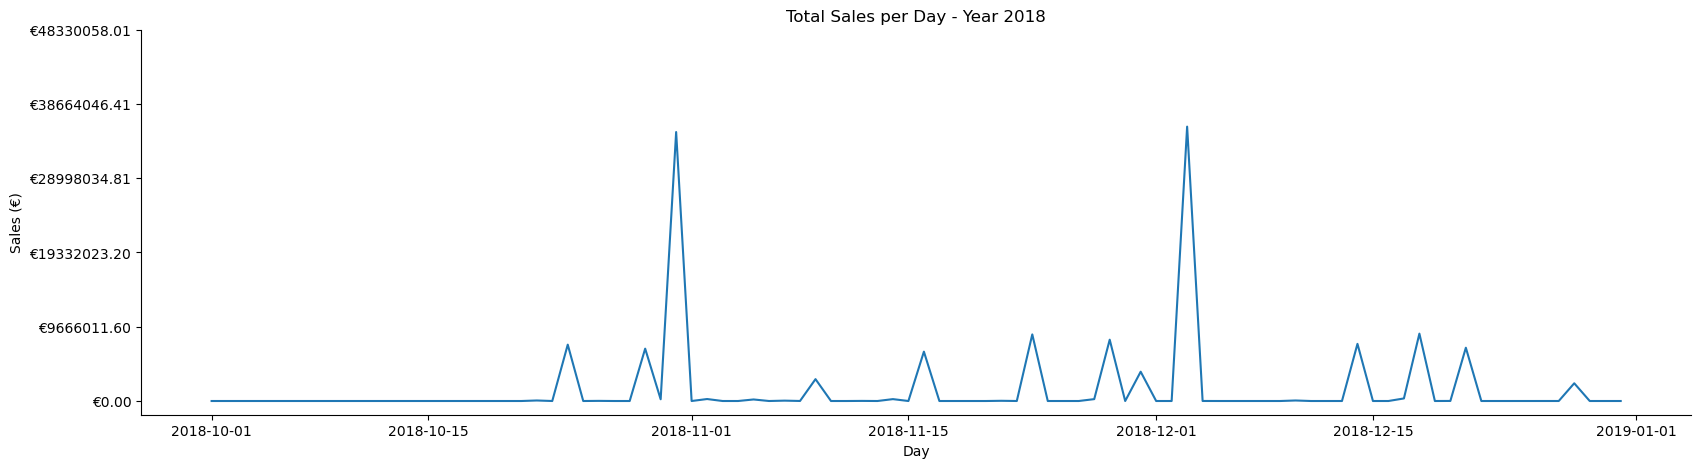

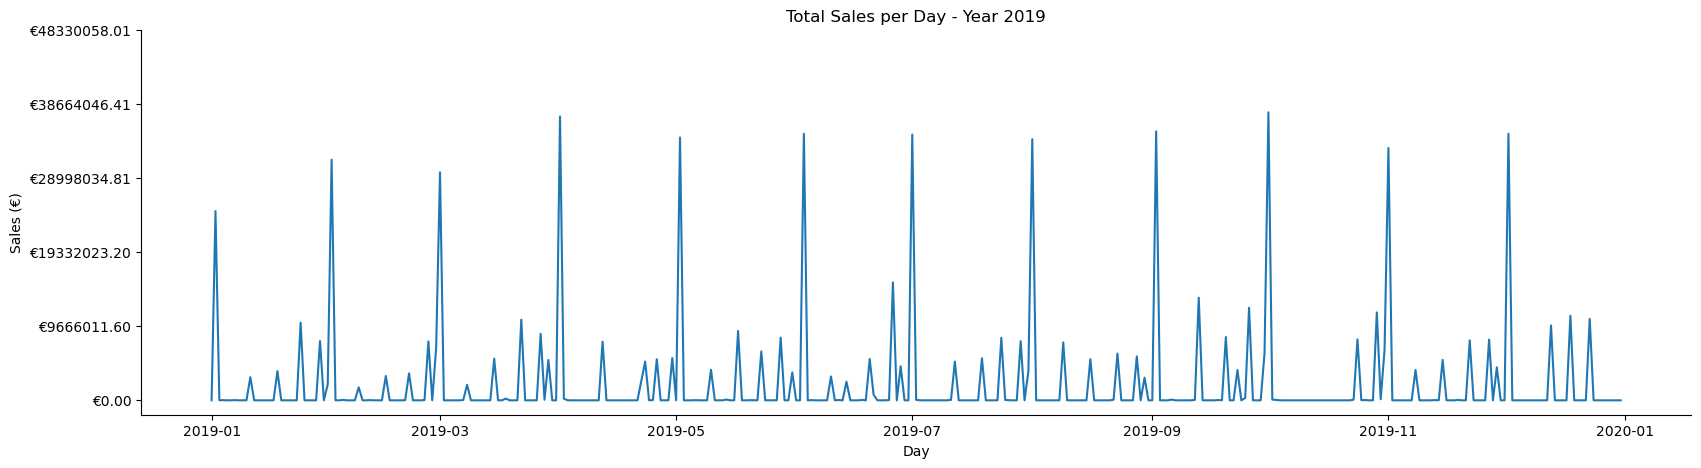

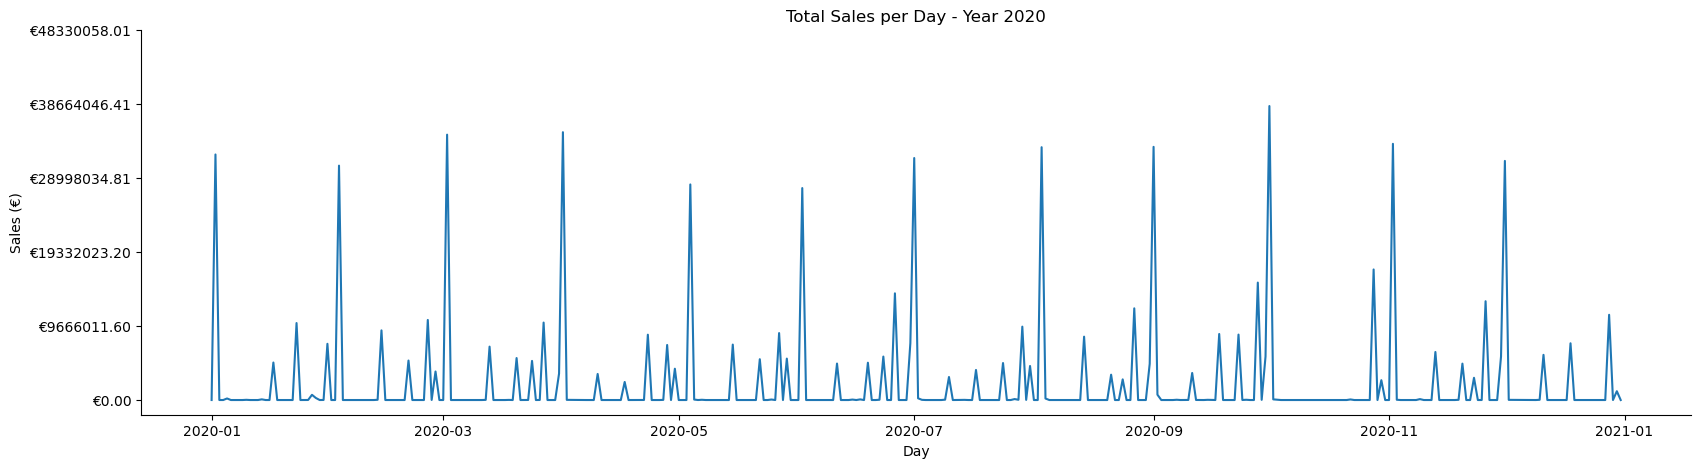

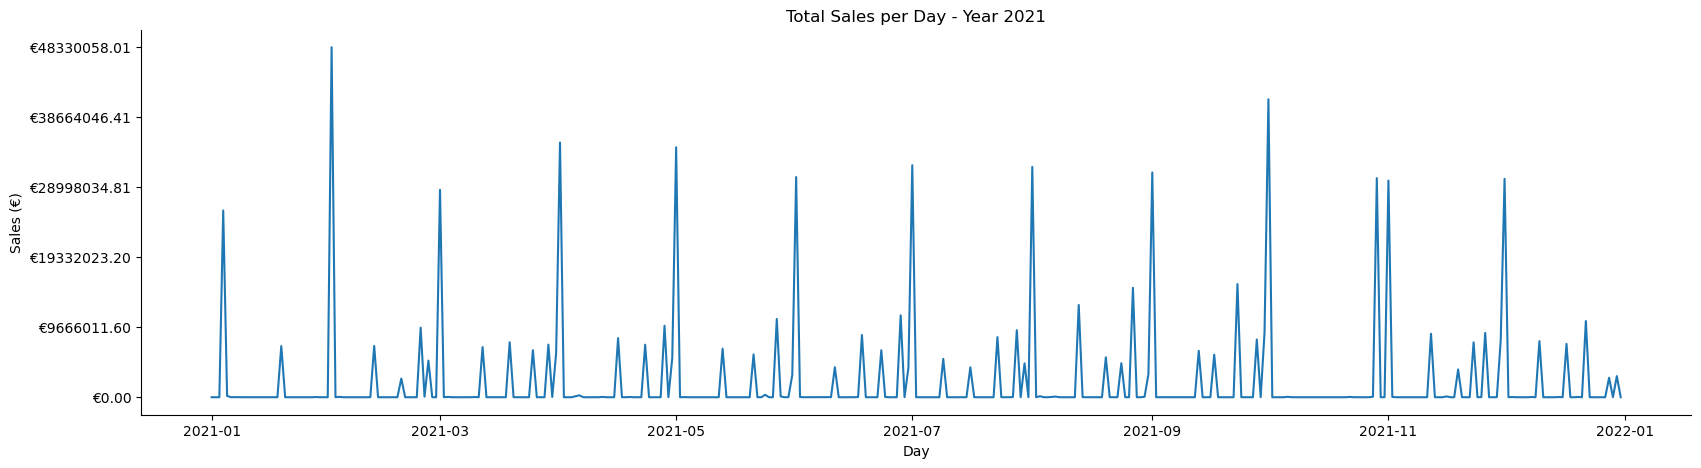

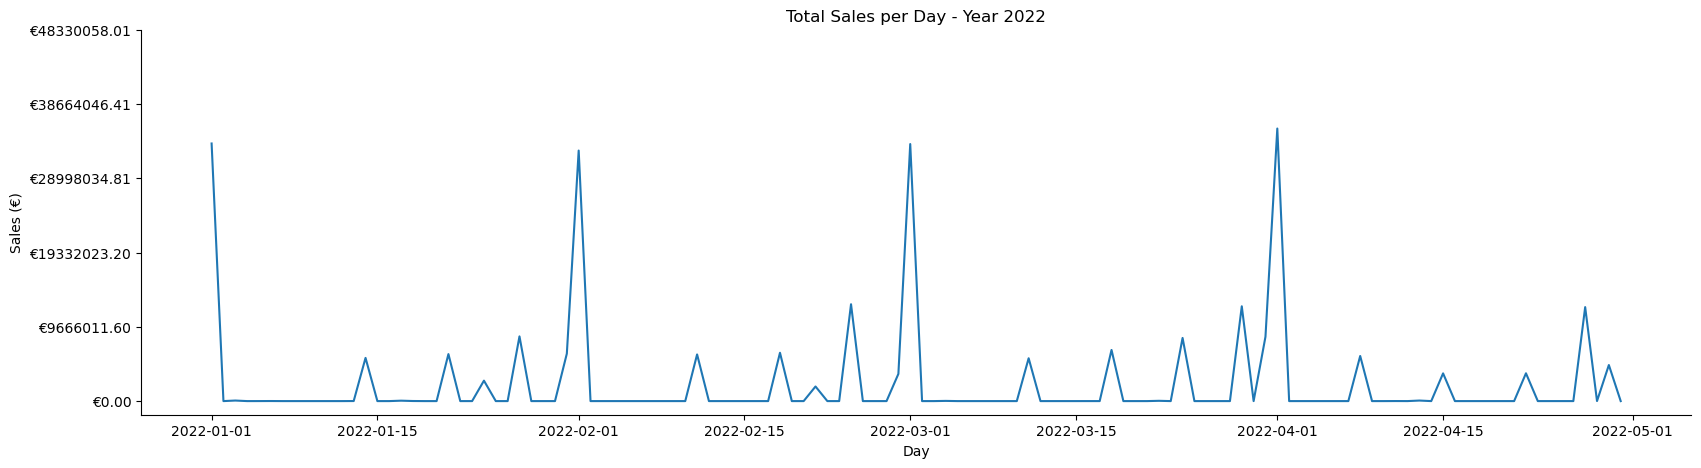

In [33]:
# Compute the minimum and maximum values of the 'Sales (€)' column
sales_min = agg_df['Total Sales'].min()
sales_max = agg_df['Total Sales'].max()

# Generate 5 equally spaced levels between the minimum and maximum values
y_ticks = np.linspace(sales_min, sales_max, num=6)
# Format the tick labels as desired
y_tick_labels = ['€{:.2f}'.format(val) for val in y_ticks]

# Group data by year
grouped = agg_df.groupby('Year')

# Plotting one graph per year
for year, group in grouped:
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot(group['Date'], group['Total Sales'])
    ax.grid(False)

    # Set the x-axis tick formatter to show only years
    # ax.xaxis.set_major_formatter(years_fmt)
    ax.set_xlabel('Day')
    ax.set_ylabel('Sales (€)')
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_tick_labels)
    ax.set_title('Total Sales per Day - Year {}'.format(year))

    sns.despine()
    plt.show()

In [34]:
# Aggregating the sales by day of the week
sales_dayweek_agg=agg_df.groupby(('Weekday'))['Total Sales'].mean(numeric_only=True)

# Define the desired order of the days of the week
desired_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reindex the DayWeek variable with the desired order of the days of the week
sales_dayweek_agg = sales_dayweek_agg.reindex(desired_order)

# Define a custom color palette with only "yellowgreen"
custom_palette = sns.color_palette(["yellowgreen"])

# Set the custom color palette
sns.set_palette(custom_palette)

# Create bar chart
plt.figure(figsize=(8,6))
sns.barplot(x=sales_dayweek_agg.index, y=sales_dayweek_agg.values)
plt.xlabel('Week Day')
plt.ylabel('Average Sales (€)')
plt.title('Average Sales by Day of the Week')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()

sns.despine()
plt.show()

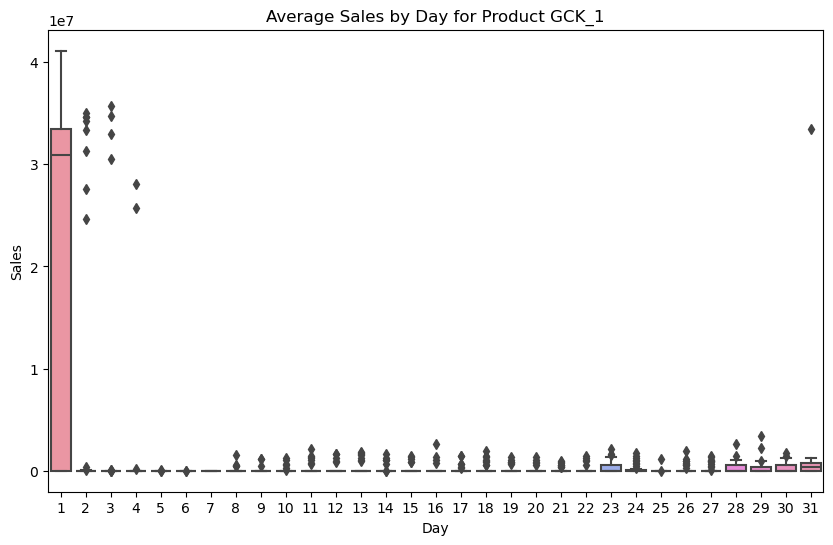

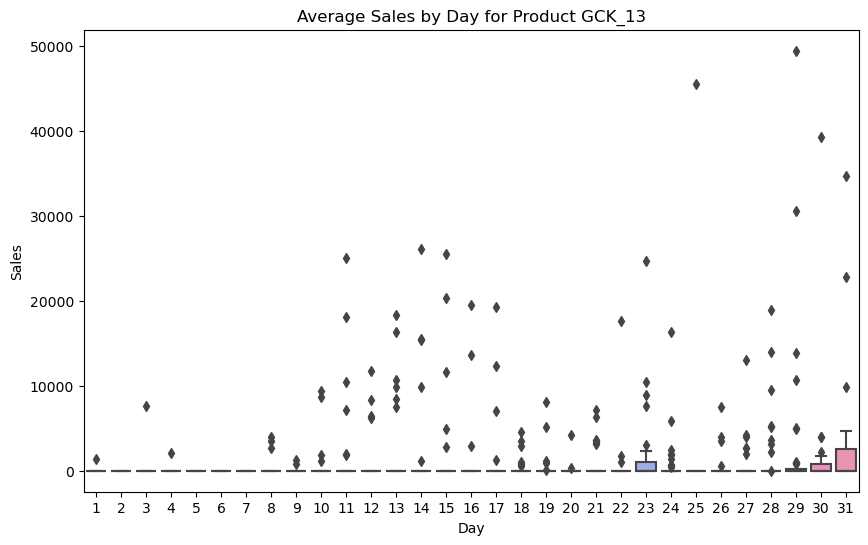

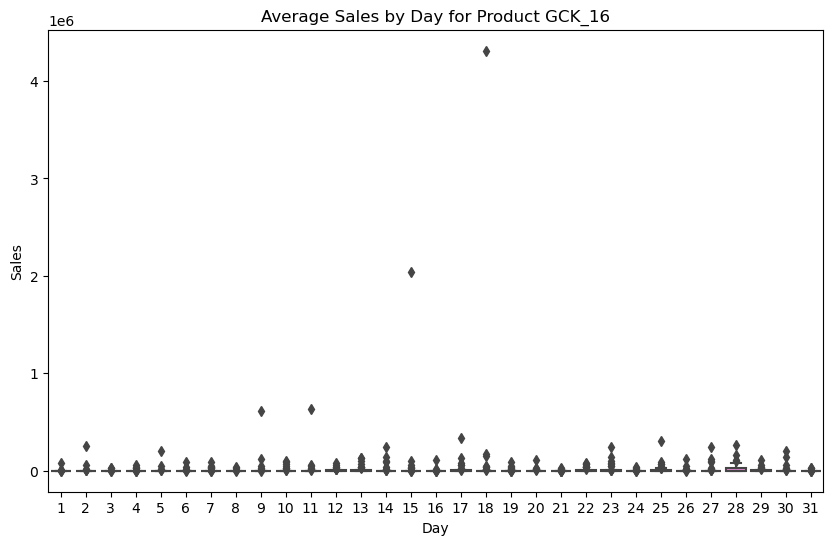

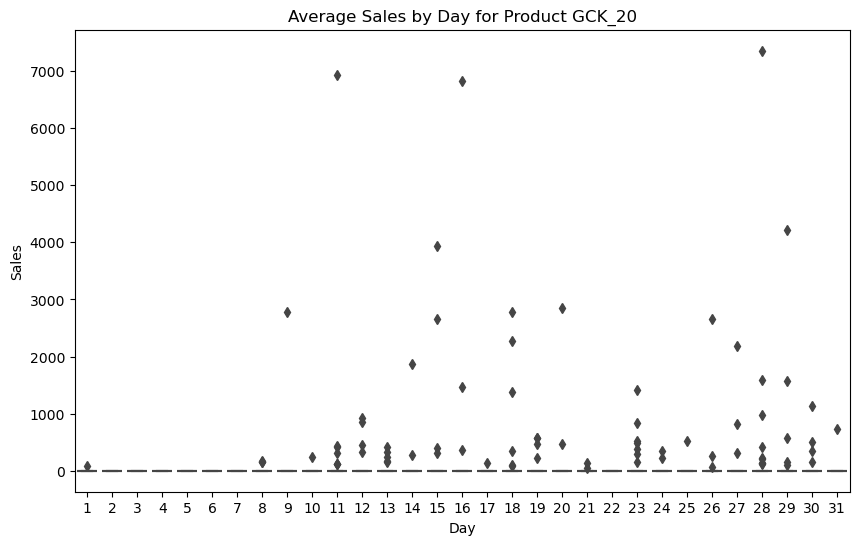

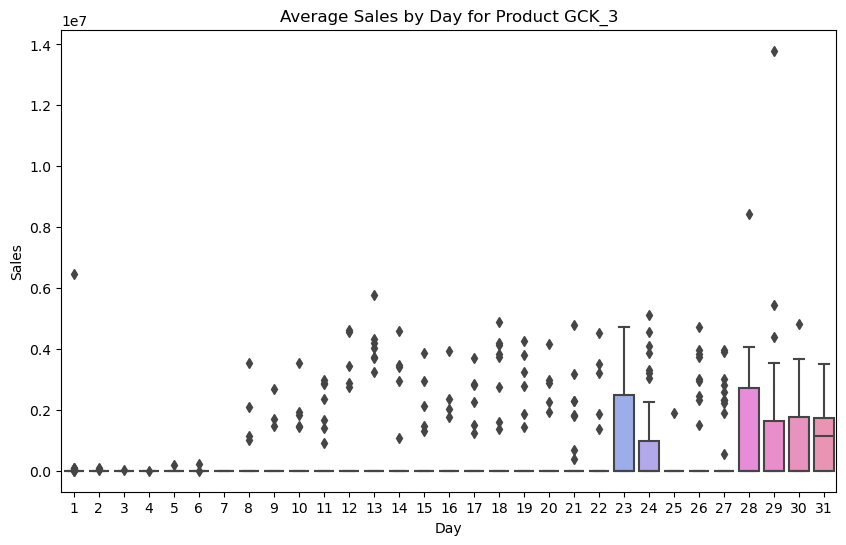

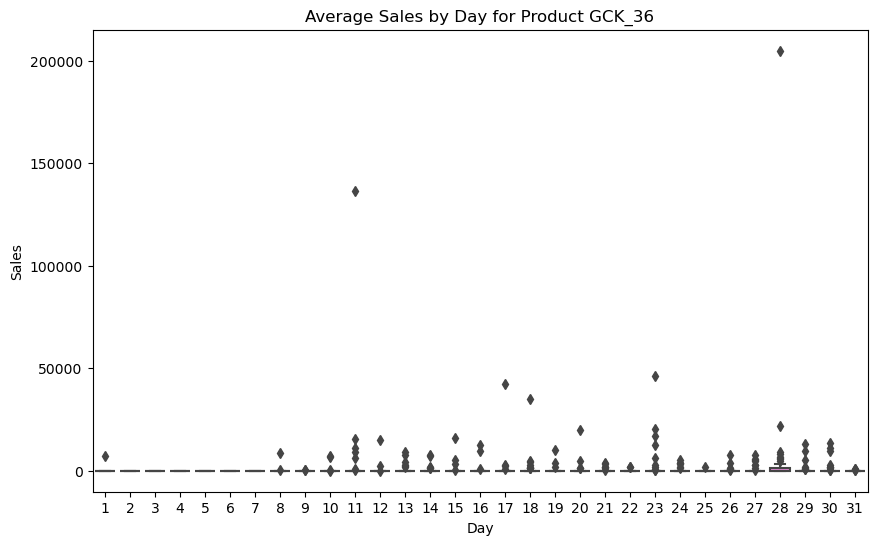

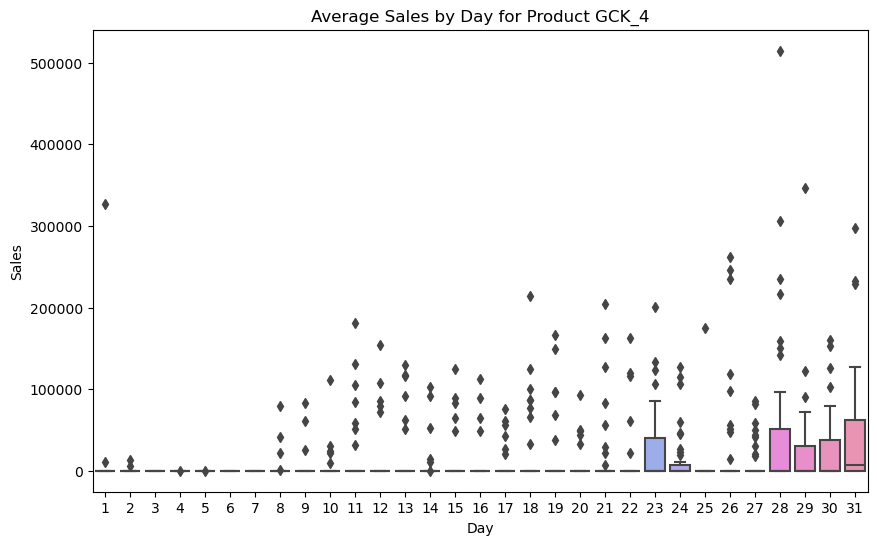

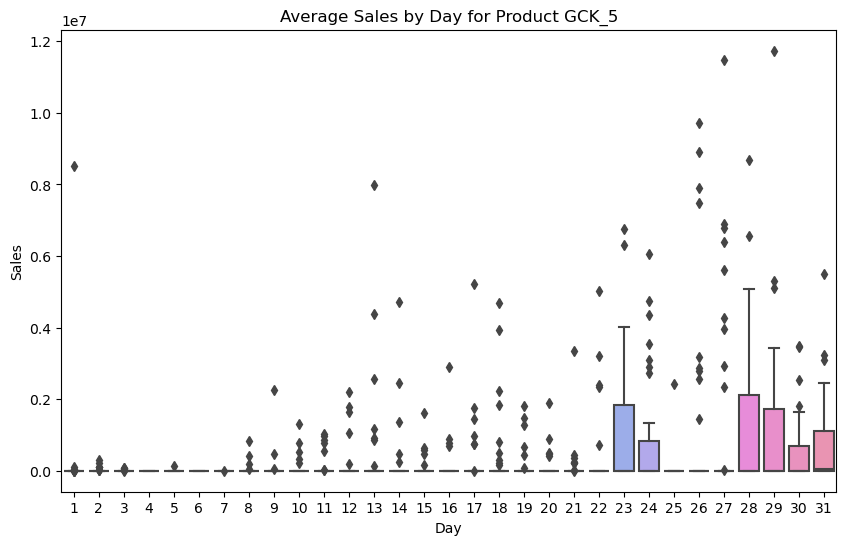

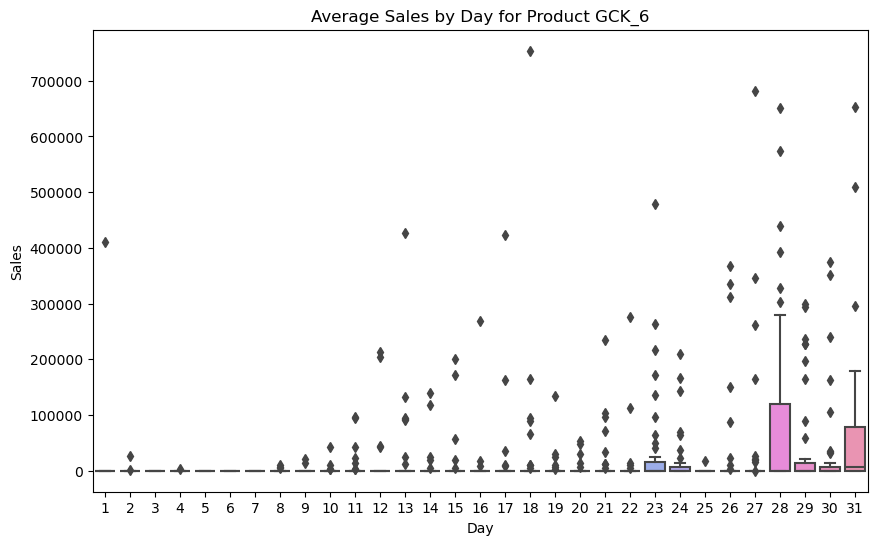

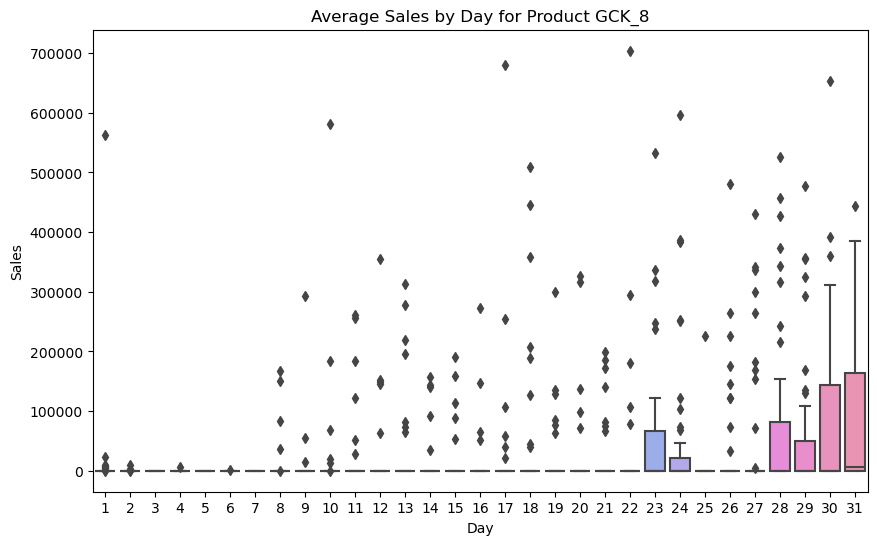

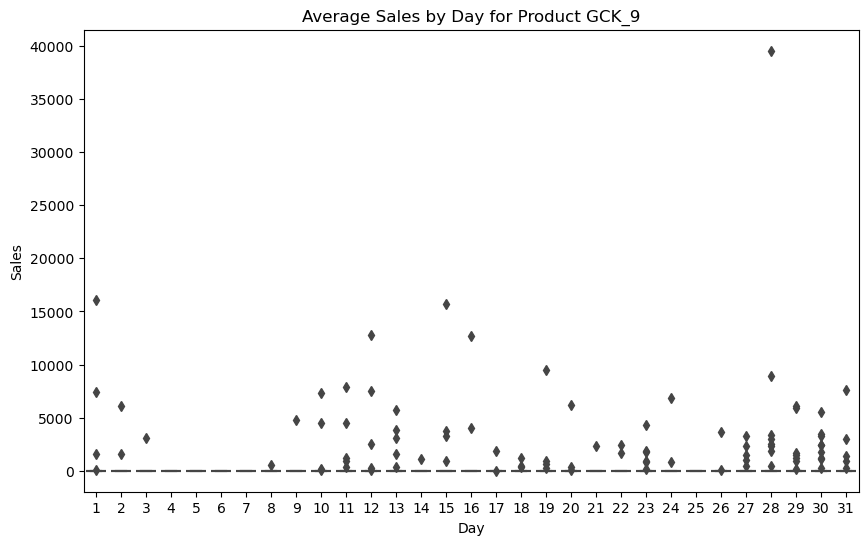

In [35]:
#Average sales per product per day
# Filter columns starting with 'GCK' or 'National Holidays'
filtered_columns = agg_df.columns[agg_df.columns.str.startswith('GCK') | (agg_df.columns == 'National Holidays')]

# Iterate over each product column, create boxplot for average sales by month
for col in filtered_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=agg_df['Day'], y=agg_df[col])
    plt.title(f'Average Sales by Day for Product {col}')
    plt.xlabel('Day')
    plt.ylabel('Sales')
    plt.show()

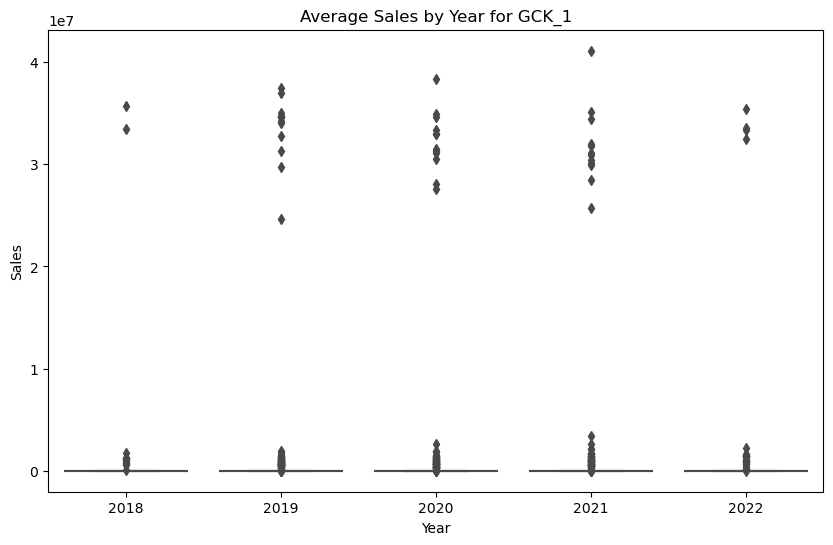

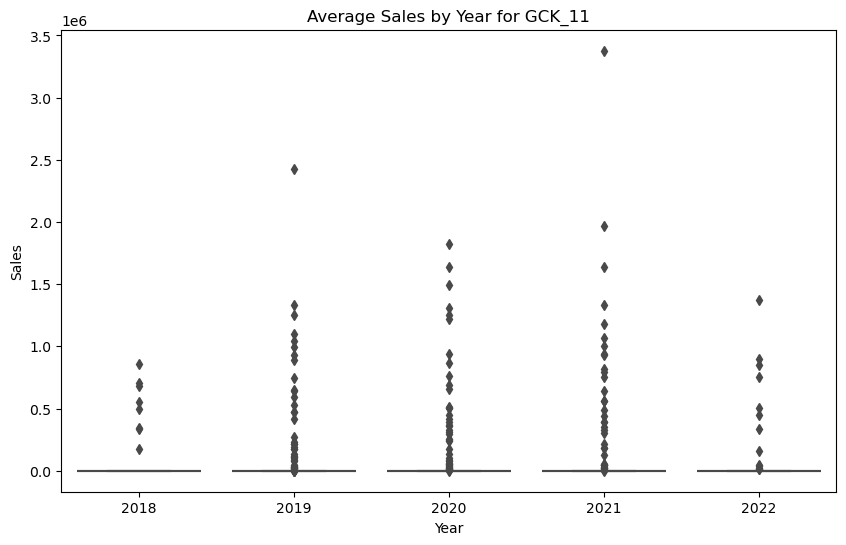

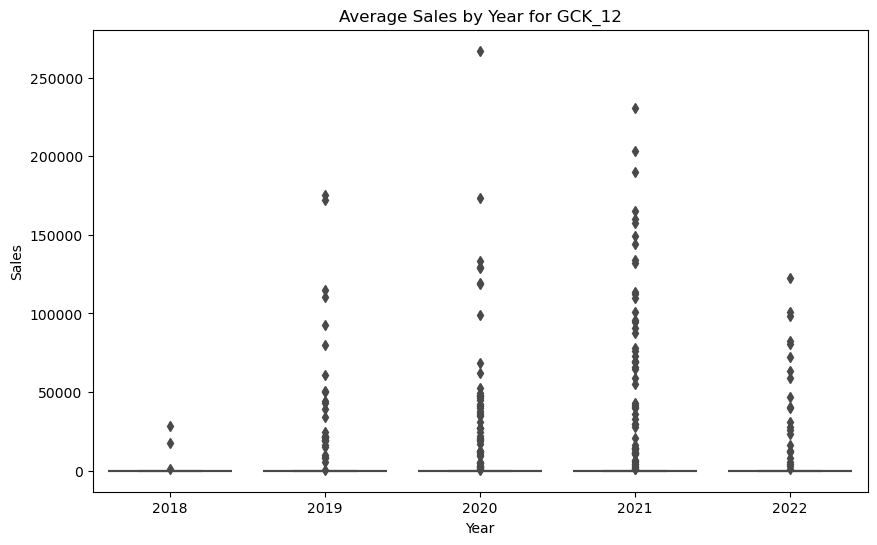

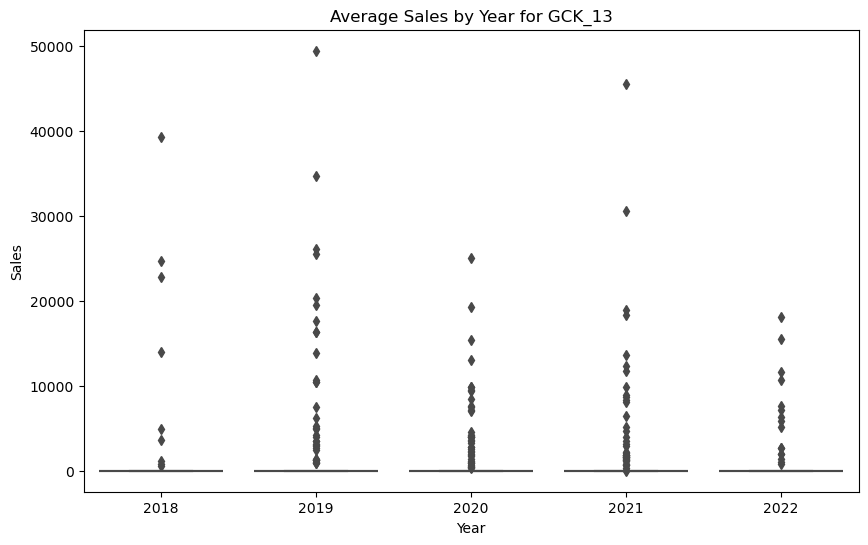

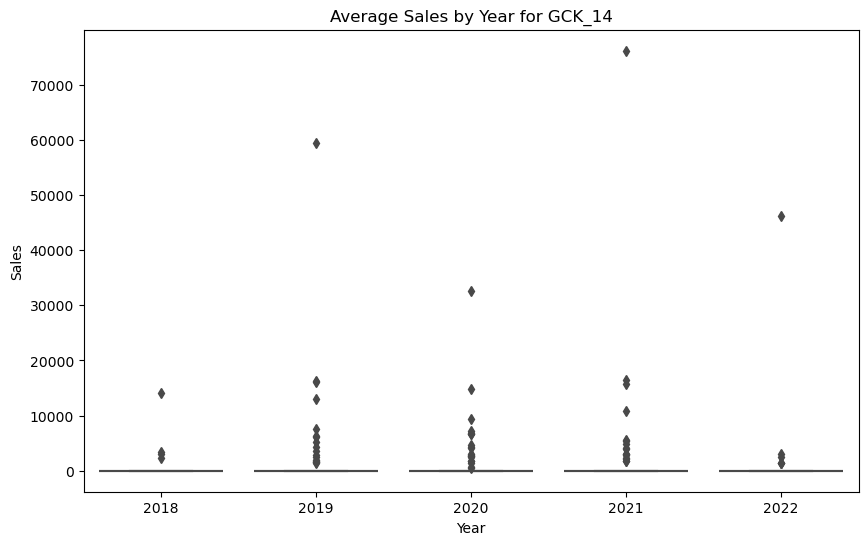

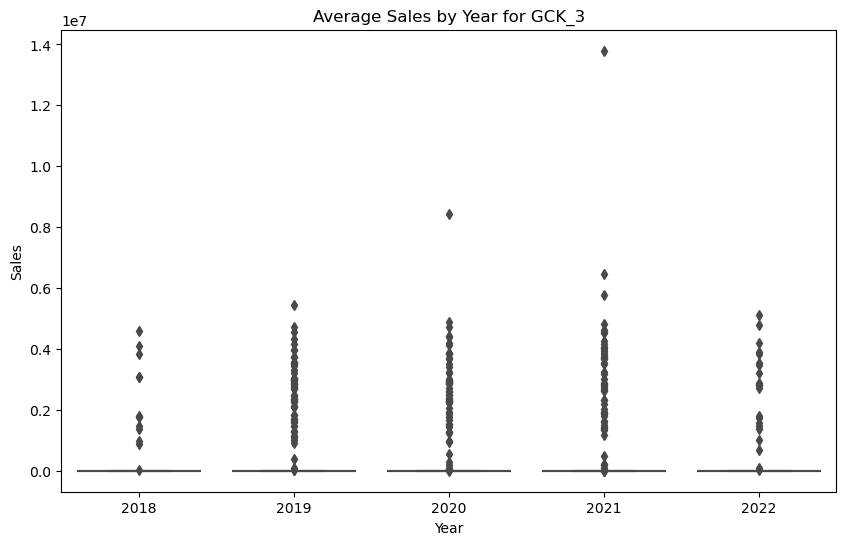

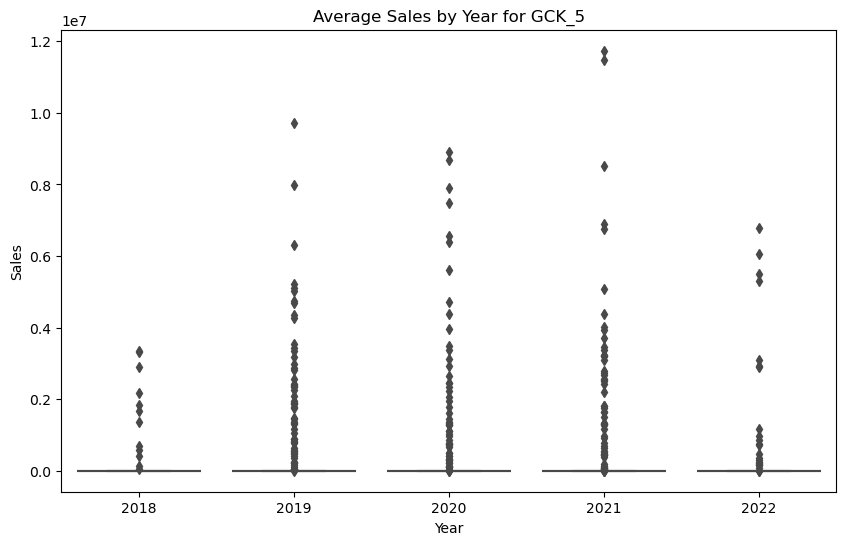

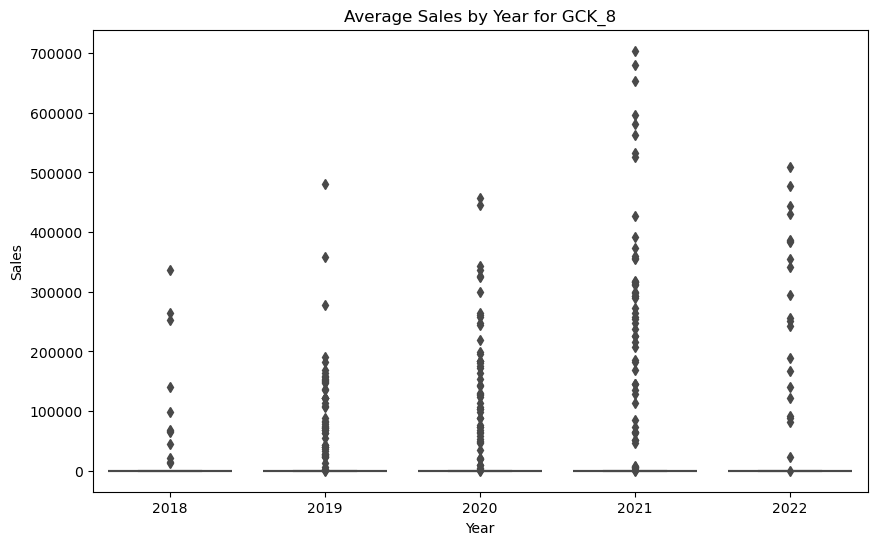

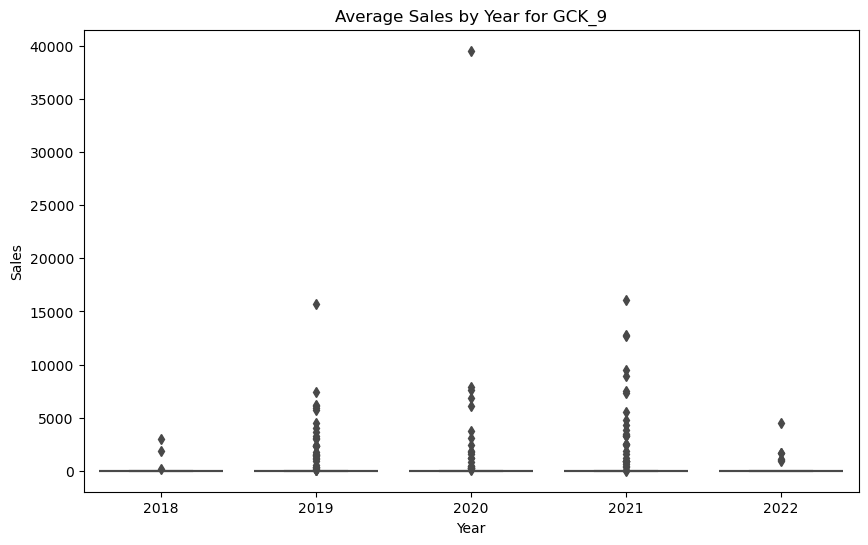

In [36]:
# Filter columns starting with 'GCK' or 'National Holidays'
filtered_columns = agg_df.columns[agg_df.columns.str.startswith('GCK') | (agg_df.columns == 'National Holidays')]

# Iterate over each filtered column, create boxplot for average sales by year
for col in filtered_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=agg_df['Year'], y=agg_df[col])
    plt.title(f'Average Sales by Year for {col}')
    plt.xlabel('Year')
    plt.ylabel('Sales')
    plt.show()

#### Monthly Sales

In [37]:
# Make a copy of the dataset
month_df = merged_df.copy()
month_df.head(10)

Date  GCK_1  GCK_11  GCK_12  GCK_13  GCK_14  GCK_16  GCK_20  GCK_3  \
0 2018-10-01    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
1 2018-10-02    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
2 2018-10-03    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
3 2018-10-04    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
4 2018-10-05    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
5 2018-10-06    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
6 2018-10-07    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
7 2018-10-08    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
8 2018-10-09    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
9 2018-10-10    0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   

   GCK_36  GCK_4  GCK_5  GCK_6  GCK_8  GCK_9  
0     0.0    0.0    0.0    0.0    0.0    0.0  
1     0.0    0.0    0.0    0.0    0.0    0.0  
2     0.0    0.0    0.0    0.0    0.0    0.0  
3     0.0    0.0    0.0    0.0    0.0    0.0  
4     0.0    0.0    0.0    0.0    0.0    0.0  
5     0.0    0.0    0.0    0.0    0.0    0.0  
6     0.0    0.0    0.0    0.0    0.0    0.0  
7     0.0    0.0    0.0    0.0    0.0    0.0  
8     0.0    0.0    0.0    0.0    0.0    0.0  
9     0.0    0.0    0.0    0.0    0.0    0.0

In [38]:
# Set the date column as the index
month_df.set_index('Date', inplace=True)

# Group by month and sum up the sales values
monthly_sales = month_df.resample('M').sum()

# Reset index to have the date as a column again
monthly_sales.reset_index(inplace=True)

# Display the resulting dataframe
print(monthly_sales)

#Source: ChatGPT

         Date        GCK_1      GCK_11     GCK_12    GCK_13    GCK_14  \
0  2018-10-31  36098918.79  1021303.50   28686.33  27666.10   5770.00   
1  2018-11-30   5140760.00  1898844.80    1070.00  68338.20  17130.00   
2  2018-12-31  38116343.62  1226122.00   17880.60  15655.18      0.00   
3  2019-01-31  27807651.78  2216391.74   21484.00  27198.29   1686.40   
4  2019-02-28  34854931.10   610456.60   34214.74  32638.63  19196.30   
5  2019-03-31  33892328.89   957023.11   10118.00  11890.00   7535.25   
6  2019-04-30  39728589.55  1484281.60   21813.27   7514.85      0.00   
7  2019-05-31  38963877.43  1066063.90   24468.00   2558.90  17820.00   
8  2019-06-30  39196785.54   492133.20   44255.68  34849.21  63017.71   
9  2019-07-31  38012231.56   585648.14   21318.48  43008.35  20719.30   
10 2019-08-31  38176979.29  2921554.87   19217.00  22497.60   1602.00   
11 2019-09-30  40759693.04  3749980.46  292490.40  19601.05  12851.20   
12 2019-10-31  39281415.51   228130.00  140819.69  

In [39]:
monthly_sales.head(10)

Date        GCK_1      GCK_11    GCK_12    GCK_13    GCK_14  \
0 2018-10-31  36098918.79  1021303.50  28686.33  27666.10   5770.00   
1 2018-11-30   5140760.00  1898844.80   1070.00  68338.20  17130.00   
2 2018-12-31  38116343.62  1226122.00  17880.60  15655.18      0.00   
3 2019-01-31  27807651.78  2216391.74  21484.00  27198.29   1686.40   
4 2019-02-28  34854931.10   610456.60  34214.74  32638.63  19196.30   
5 2019-03-31  33892328.89   957023.11  10118.00  11890.00   7535.25   
6 2019-04-30  39728589.55  1484281.60  21813.27   7514.85      0.00   
7 2019-05-31  38963877.43  1066063.90  24468.00   2558.90  17820.00   
8 2019-06-30  39196785.54   492133.20  44255.68  34849.21  63017.71   
9 2019-07-31  38012231.56   585648.14  21318.48  43008.35  20719.30   

       GCK_16   GCK_20        GCK_3    GCK_36      GCK_4        GCK_5  \
0   333196.87  4563.14   8089465.96   6474.60  397760.69   2499061.19   
1  1377694.32  5798.14  11870270.20  21986.89  373352.33   8993944.04   
2  4762524.66   918.65   8739307.86  13924.52  436873.36   6981080.57   
3   942957.19  2399.18  10708075.28  15444.39  484435.48   8301428.77   
4   257765.04   620.66  10172826.74   8051.15  620031.80   6892520.62   
5  2258352.22  3369.55  11057255.22   7373.42  498766.86  11933851.57   
6   225864.00  3635.26  12319225.05   4526.60  428258.52   5937614.80   
7   353451.54   944.00  12809906.50  16905.32  375671.57  11413781.15   
8   371512.38   772.94  11546452.19  17296.03  190721.15  13738550.54   
9   266225.86   577.60  13421550.83  33334.41  381343.41  11189764.23   

       GCK_6      GCK_8     GCK_9  
0  369231.60  586052.74   3219.32  
1  473046.96  526792.77   1875.90  
2  999472.69  271490.71      0.00  
3  598874.10  381400.15   1487.00  
4  542037.52  368475.57   3234.28  
5  735604.23  592288.36  13050.61  
6  277575.12  418899.90   9150.70  
7  315978.77  298806.84   4614.08  
8  282963.19  420707.73   4488.09  
9  725411.99  366980.26   1766.40

In [40]:
# Extract month from 'Date' and store it in a new column 'Month'
monthly_sales['Month'] = monthly_sales['Date'].dt.month
monthly_sales.head(10)

#Source: ChatGPT

Date        GCK_1      GCK_11    GCK_12    GCK_13    GCK_14  \
0 2018-10-31  36098918.79  1021303.50  28686.33  27666.10   5770.00   
1 2018-11-30   5140760.00  1898844.80   1070.00  68338.20  17130.00   
2 2018-12-31  38116343.62  1226122.00  17880.60  15655.18      0.00   
3 2019-01-31  27807651.78  2216391.74  21484.00  27198.29   1686.40   
4 2019-02-28  34854931.10   610456.60  34214.74  32638.63  19196.30   
5 2019-03-31  33892328.89   957023.11  10118.00  11890.00   7535.25   
6 2019-04-30  39728589.55  1484281.60  21813.27   7514.85      0.00   
7 2019-05-31  38963877.43  1066063.90  24468.00   2558.90  17820.00   
8 2019-06-30  39196785.54   492133.20  44255.68  34849.21  63017.71   
9 2019-07-31  38012231.56   585648.14  21318.48  43008.35  20719.30   

       GCK_16   GCK_20        GCK_3    GCK_36      GCK_4        GCK_5  \
0   333196.87  4563.14   8089465.96   6474.60  397760.69   2499061.19   
1  1377694.32  5798.14  11870270.20  21986.89  373352.33   8993944.04   
2  4762524.66   918.65   8739307.86  13924.52  436873.36   6981080.57   
3   942957.19  2399.18  10708075.28  15444.39  484435.48   8301428.77   
4   257765.04   620.66  10172826.74   8051.15  620031.80   6892520.62   
5  2258352.22  3369.55  11057255.22   7373.42  498766.86  11933851.57   
6   225864.00  3635.26  12319225.05   4526.60  428258.52   5937614.80   
7   353451.54   944.00  12809906.50  16905.32  375671.57  11413781.15   
8   371512.38   772.94  11546452.19  17296.03  190721.15  13738550.54   
9   266225.86   577.60  13421550.83  33334.41  381343.41  11189764.23   

       GCK_6      GCK_8     GCK_9  Month  
0  369231.60  586052.74   3219.32     10  
1  473046.96  526792.77   1875.90     11  
2  999472.69  271490.71      0.00     12  
3  598874.10  381400.15   1487.00      1  
4  542037.52  368475.57   3234.28      2  
5  735604.23  592288.36  13050.61      3  
6  277575.12  418899.90   9150.70      4  
7  315978.77  298806.84   4614.08      5  
8  282963.19  420707.73   4488.09      6  
9  725411.99  366980.26   1766.40      7

In [41]:
# Sum the sales from each column
monthly_sales['Total Sales'] = monthly_sales.iloc[:, 1:].sum(axis=1)
monthly_sales.head(10)

#Source: ChatGPT

Date        GCK_1      GCK_11    GCK_12    GCK_13    GCK_14  \
0 2018-10-31  36098918.79  1021303.50  28686.33  27666.10   5770.00   
1 2018-11-30   5140760.00  1898844.80   1070.00  68338.20  17130.00   
2 2018-12-31  38116343.62  1226122.00  17880.60  15655.18      0.00   
3 2019-01-31  27807651.78  2216391.74  21484.00  27198.29   1686.40   
4 2019-02-28  34854931.10   610456.60  34214.74  32638.63  19196.30   
5 2019-03-31  33892328.89   957023.11  10118.00  11890.00   7535.25   
6 2019-04-30  39728589.55  1484281.60  21813.27   7514.85      0.00   
7 2019-05-31  38963877.43  1066063.90  24468.00   2558.90  17820.00   
8 2019-06-30  39196785.54   492133.20  44255.68  34849.21  63017.71   
9 2019-07-31  38012231.56   585648.14  21318.48  43008.35  20719.30   

       GCK_16   GCK_20        GCK_3    GCK_36      GCK_4        GCK_5  \
0   333196.87  4563.14   8089465.96   6474.60  397760.69   2499061.19   
1  1377694.32  5798.14  11870270.20  21986.89  373352.33   8993944.04   
2  4762524.66   918.65   8739307.86  13924.52  436873.36   6981080.57   
3   942957.19  2399.18  10708075.28  15444.39  484435.48   8301428.77   
4   257765.04   620.66  10172826.74   8051.15  620031.80   6892520.62   
5  2258352.22  3369.55  11057255.22   7373.42  498766.86  11933851.57   
6   225864.00  3635.26  12319225.05   4526.60  428258.52   5937614.80   
7   353451.54   944.00  12809906.50  16905.32  375671.57  11413781.15   
8   371512.38   772.94  11546452.19  17296.03  190721.15  13738550.54   
9   266225.86   577.60  13421550.83  33334.41  381343.41  11189764.23   

       GCK_6      GCK_8     GCK_9  Month  Total Sales  
0  369231.60  586052.74   3219.32     10  49471380.83  
1  473046.96  526792.77   1875.90     11  30770915.55  
2  999472.69  271490.71      0.00     12  61581606.42  
3  598874.10  381400.15   1487.00      1  51510914.75  
4  542037.52  368475.57   3234.28      2  54417002.75  
5  735604.23  592288.36  13050.61      3  61978810.29  
6  277575.12  418899.90   9150.70      4  60866953.22  
7  315978.77  298806.84   4614.08      5  65664853.00  
8  282963.19  420707.73   4488.09      6  66404511.58  
9  725411.99  366980.26   1766.40      7  65069887.82

In [42]:
# Convert 'Date' column to datetime
monthly_sales['Date'] = pd.to_datetime(monthly_sales['Date'])

# Set the day component to 1
monthly_sales['Date'] = monthly_sales['Date'].dt.to_period('M').dt.to_timestamp()
monthly_sales.head(10)

#Source: ChatGPT

Date        GCK_1      GCK_11    GCK_12    GCK_13    GCK_14  \
0 2018-10-01  36098918.79  1021303.50  28686.33  27666.10   5770.00   
1 2018-11-01   5140760.00  1898844.80   1070.00  68338.20  17130.00   
2 2018-12-01  38116343.62  1226122.00  17880.60  15655.18      0.00   
3 2019-01-01  27807651.78  2216391.74  21484.00  27198.29   1686.40   
4 2019-02-01  34854931.10   610456.60  34214.74  32638.63  19196.30   
5 2019-03-01  33892328.89   957023.11  10118.00  11890.00   7535.25   
6 2019-04-01  39728589.55  1484281.60  21813.27   7514.85      0.00   
7 2019-05-01  38963877.43  1066063.90  24468.00   2558.90  17820.00   
8 2019-06-01  39196785.54   492133.20  44255.68  34849.21  63017.71   
9 2019-07-01  38012231.56   585648.14  21318.48  43008.35  20719.30   

       GCK_16   GCK_20        GCK_3    GCK_36      GCK_4        GCK_5  \
0   333196.87  4563.14   8089465.96   6474.60  397760.69   2499061.19   
1  1377694.32  5798.14  11870270.20  21986.89  373352.33   8993944.04   
2  4762524.66   918.65   8739307.86  13924.52  436873.36   6981080.57   
3   942957.19  2399.18  10708075.28  15444.39  484435.48   8301428.77   
4   257765.04   620.66  10172826.74   8051.15  620031.80   6892520.62   
5  2258352.22  3369.55  11057255.22   7373.42  498766.86  11933851.57   
6   225864.00  3635.26  12319225.05   4526.60  428258.52   5937614.80   
7   353451.54   944.00  12809906.50  16905.32  375671.57  11413781.15   
8   371512.38   772.94  11546452.19  17296.03  190721.15  13738550.54   
9   266225.86   577.60  13421550.83  33334.41  381343.41  11189764.23   

       GCK_6      GCK_8     GCK_9  Month  Total Sales  
0  369231.60  586052.74   3219.32     10  49471380.83  
1  473046.96  526792.77   1875.90     11  30770915.55  
2  999472.69  271490.71      0.00     12  61581606.42  
3  598874.10  381400.15   1487.00      1  51510914.75  
4  542037.52  368475.57   3234.28      2  54417002.75  
5  735604.23  592288.36  13050.61      3  61978810.29  
6  277575.12  418899.90   9150.70      4  60866953.22  
7  315978.77  298806.84   4614.08      5  65664853.00  
8  282963.19  420707.73   4488.09      6  66404511.58  
9  725411.99  366980.26   1766.40      7  65069887.82

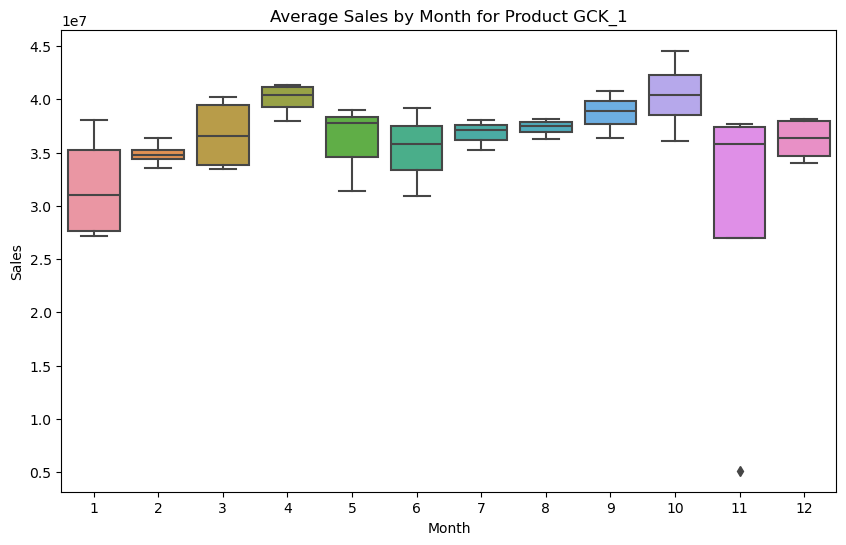

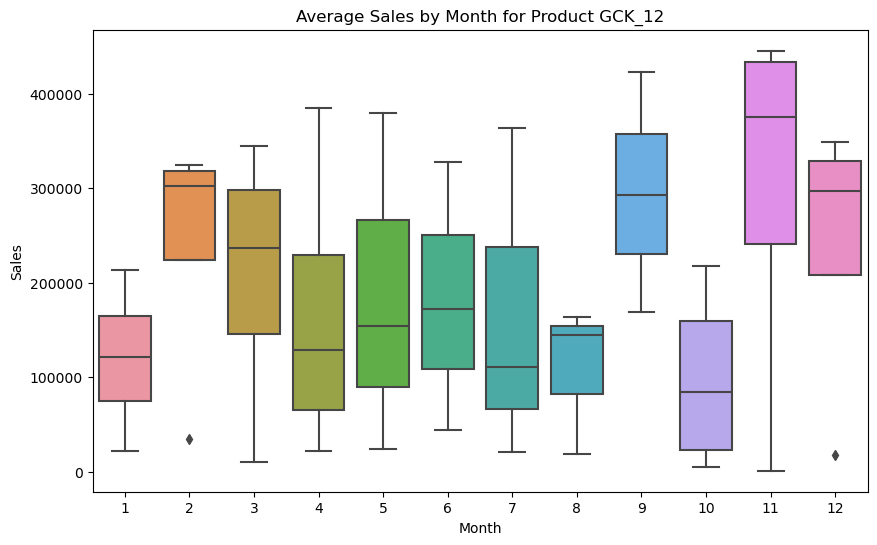

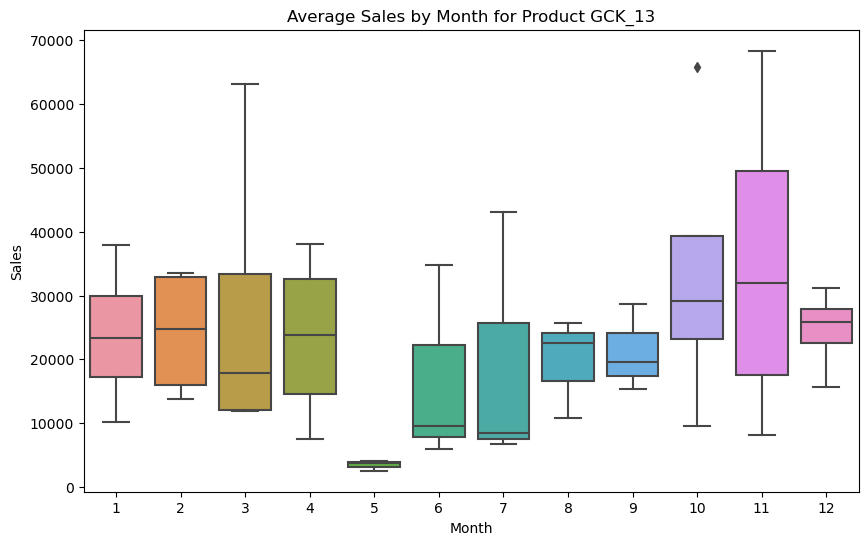

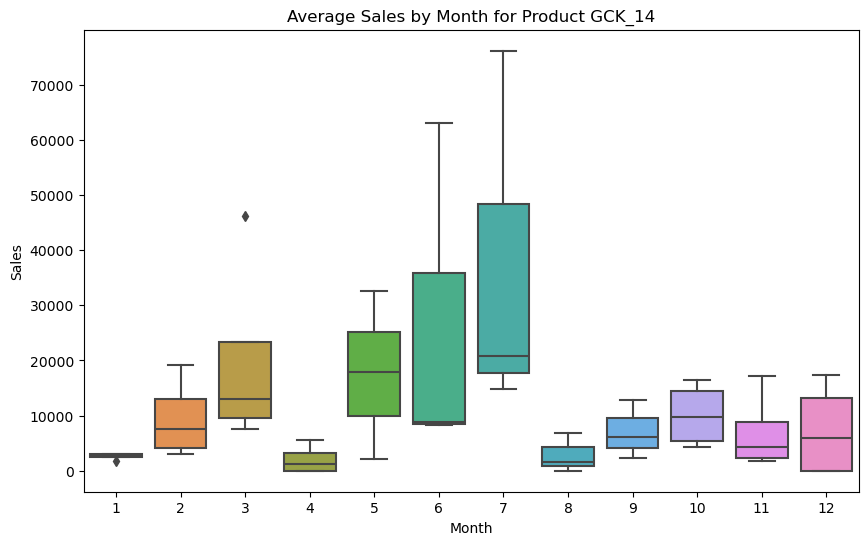

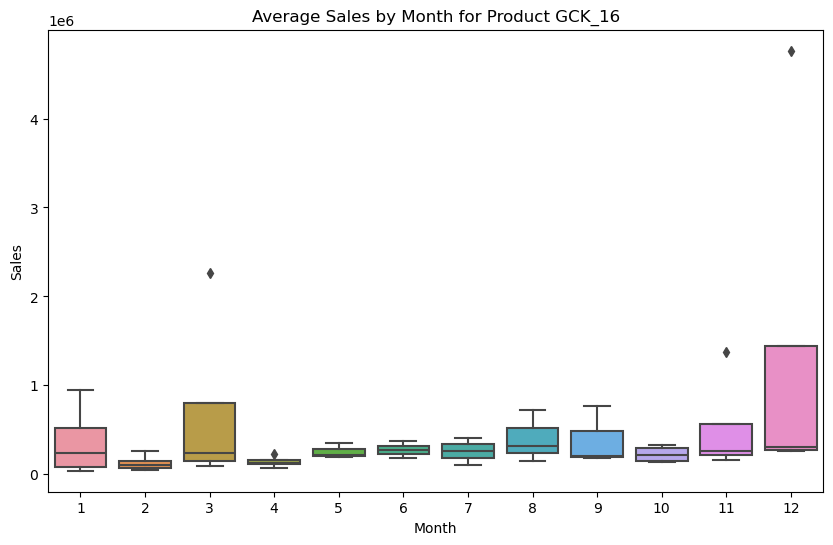

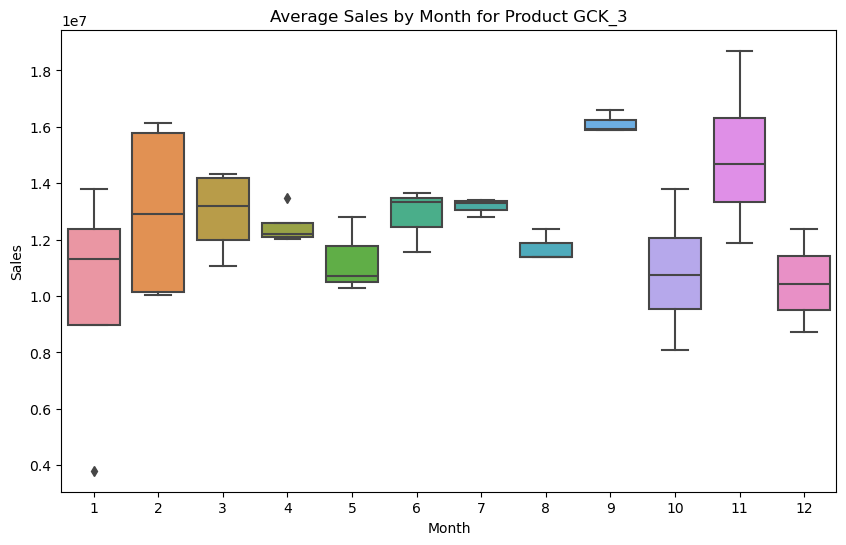

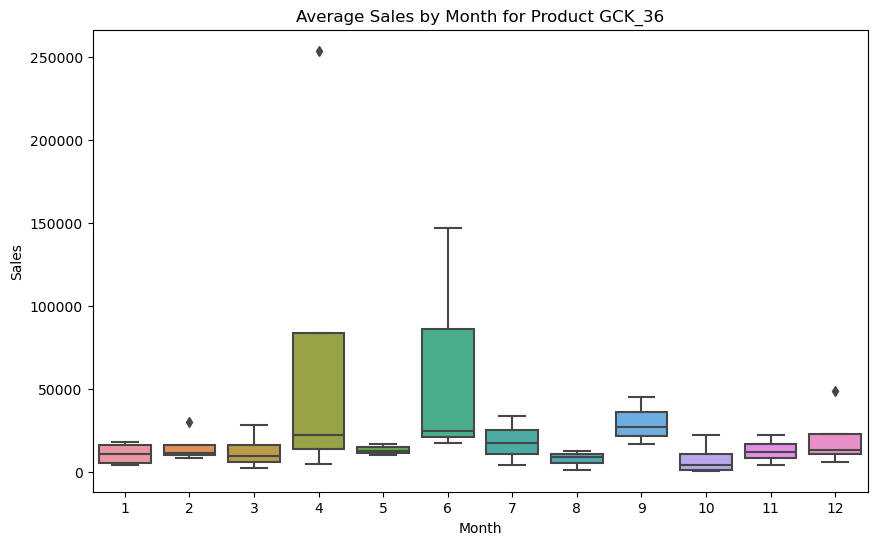

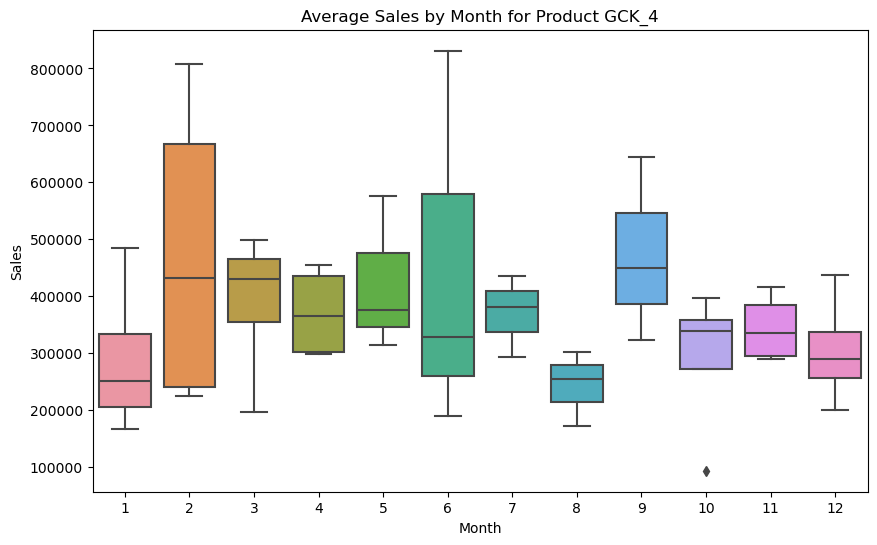

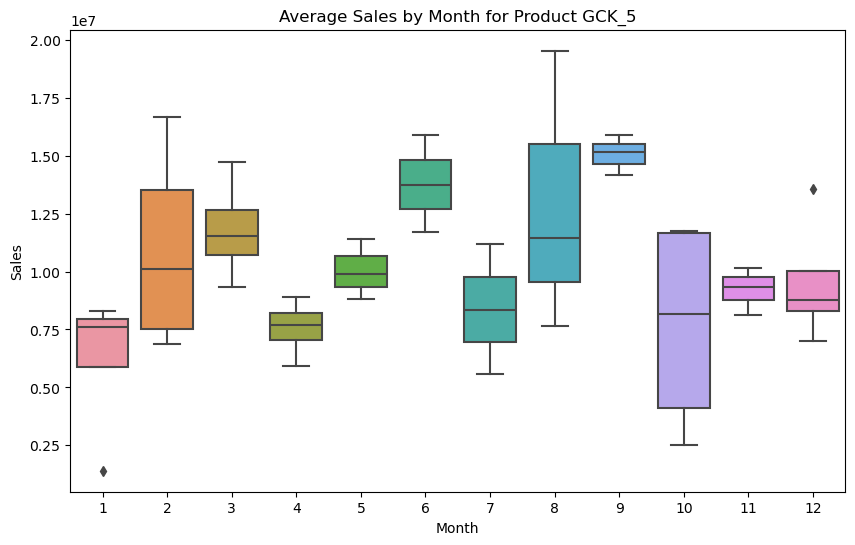

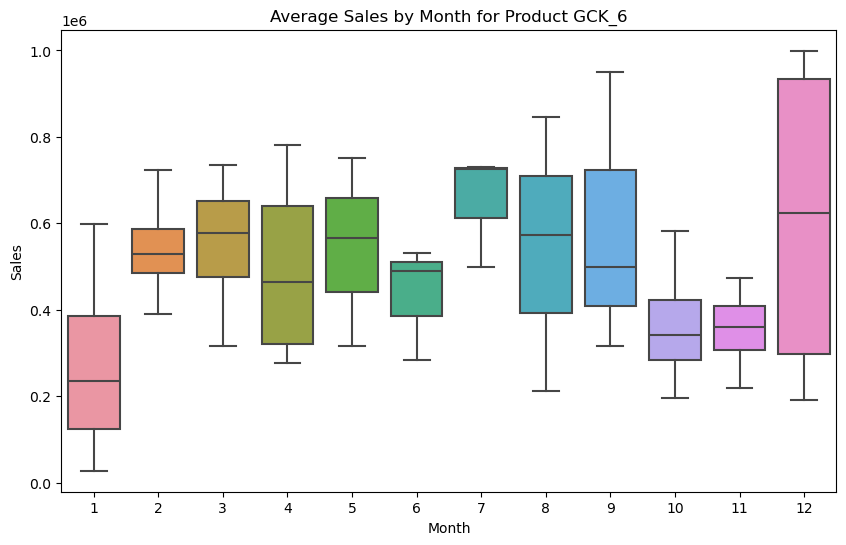

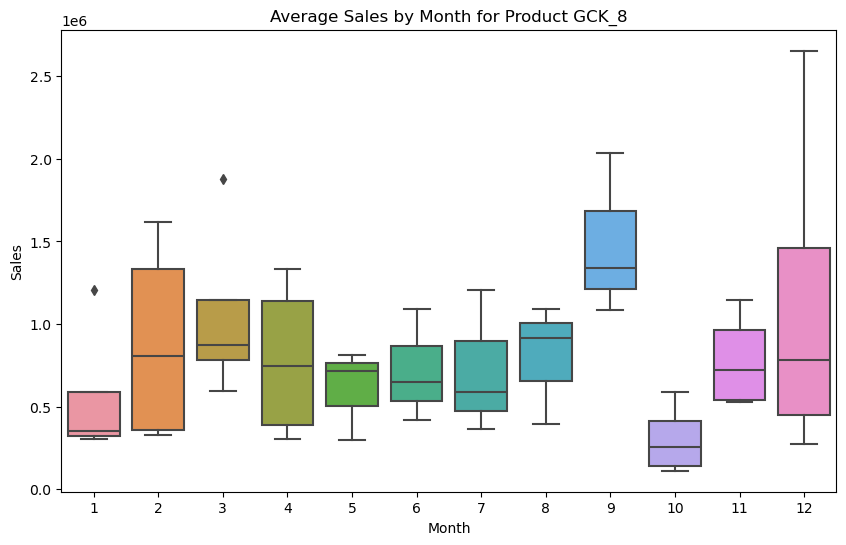

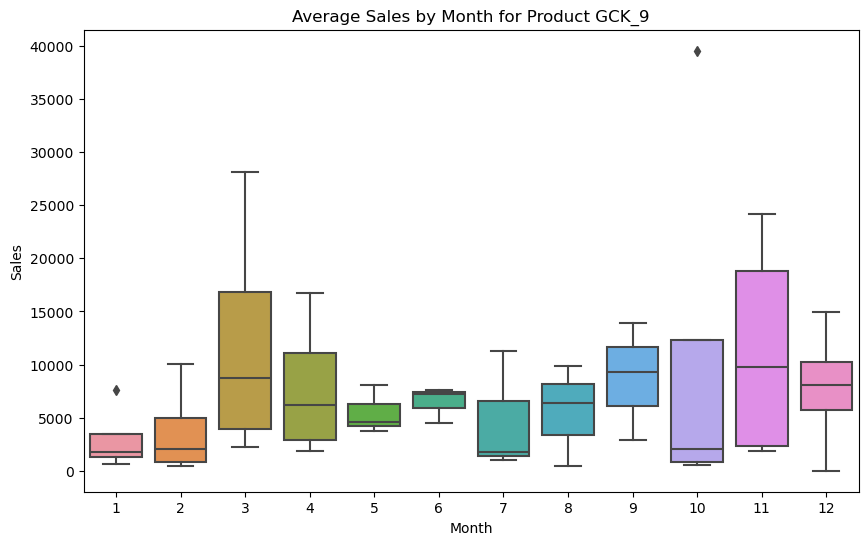

In [43]:
#Average sales per product per month
# Filter columns starting with 'GCK' or 'National Holidays'
filtered_columns = monthly_sales.columns[monthly_sales.columns.str.startswith('GCK')]

# Iterate over each product column, create boxplot for average sales by month
for col in filtered_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=monthly_sales['Month'], y=monthly_sales[col])
    plt.title(f'Average Sales by Month for Product {col}')
    plt.xlabel('Month')
    plt.ylabel('Sales')
    plt.show()

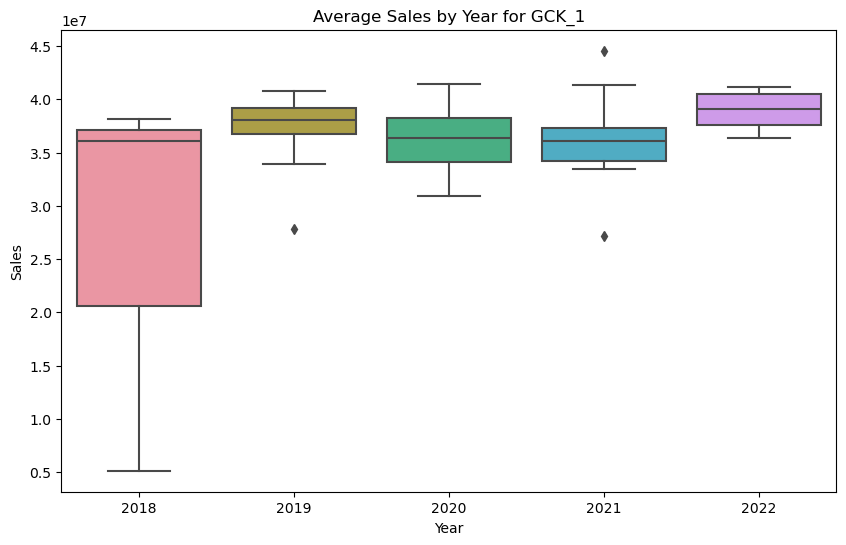

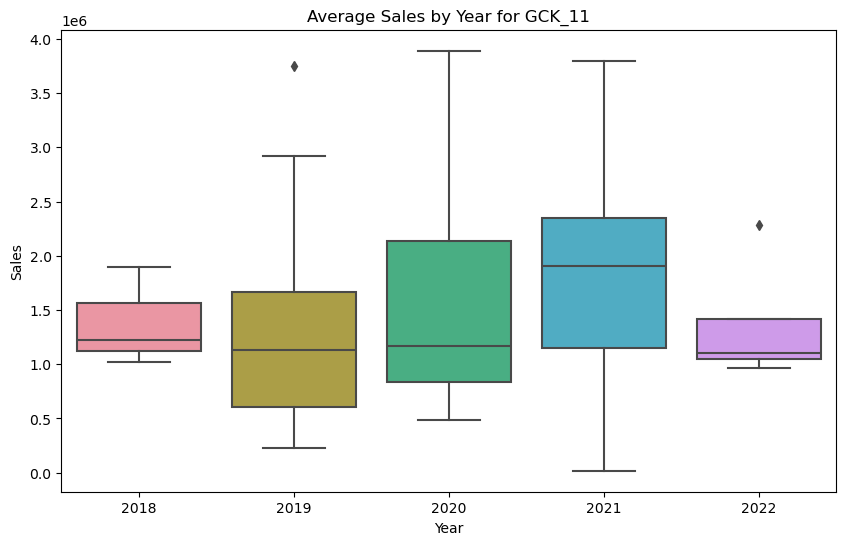

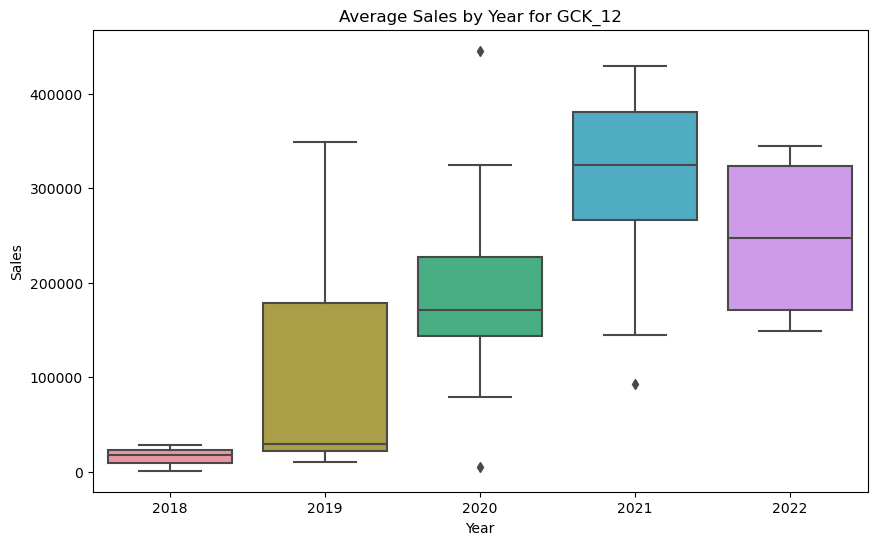

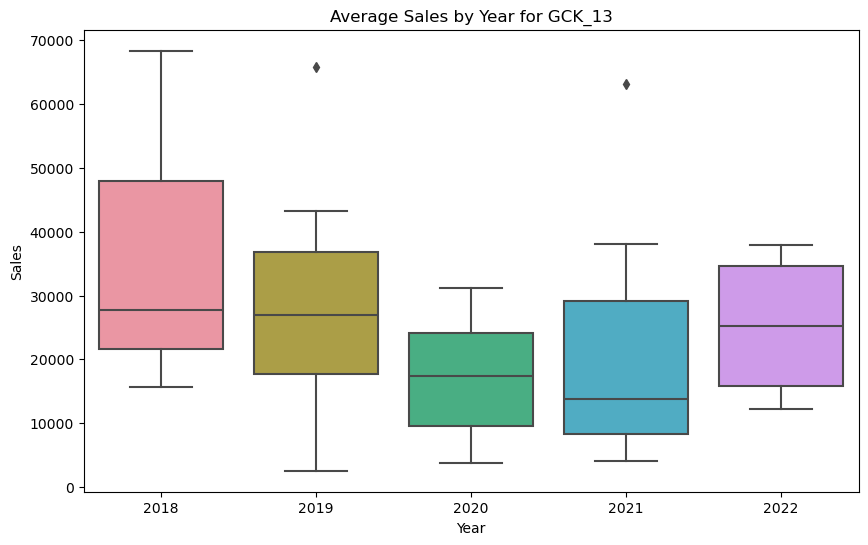

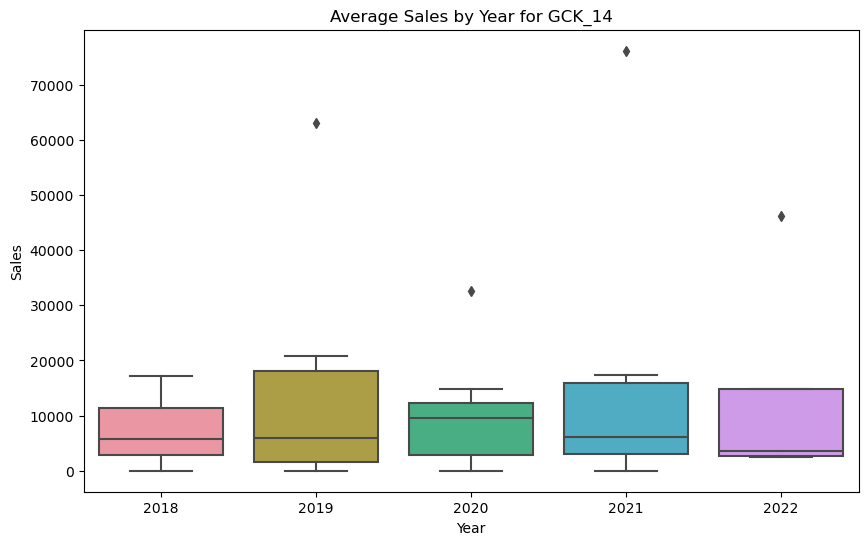

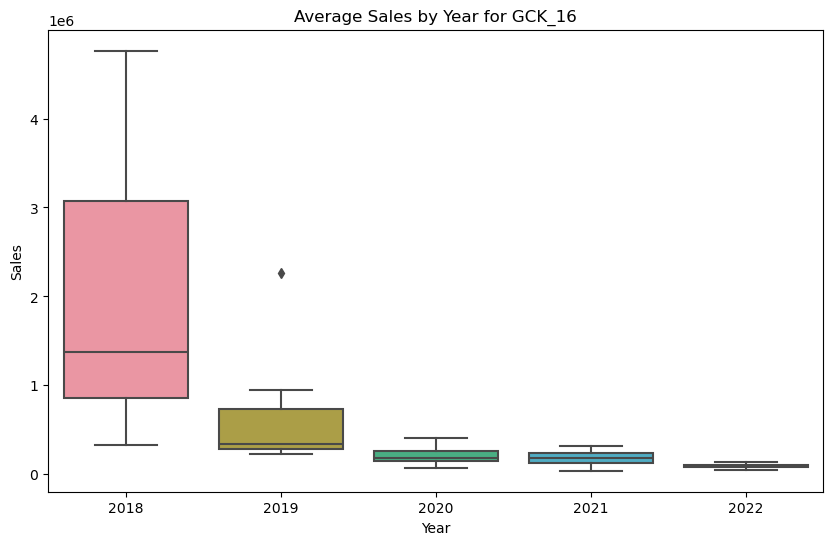

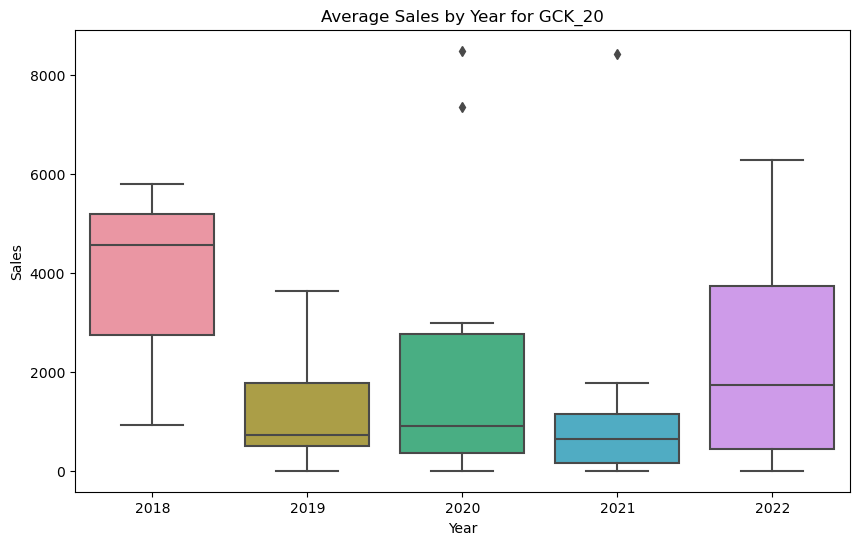

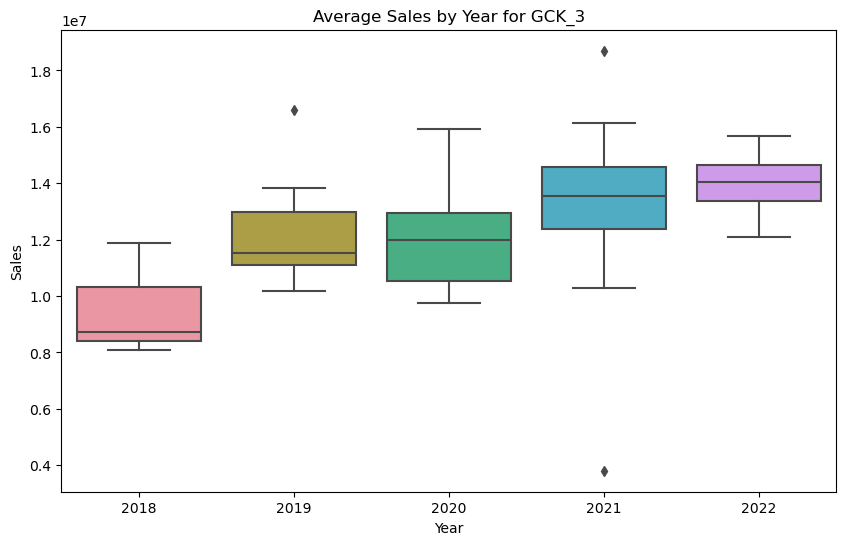

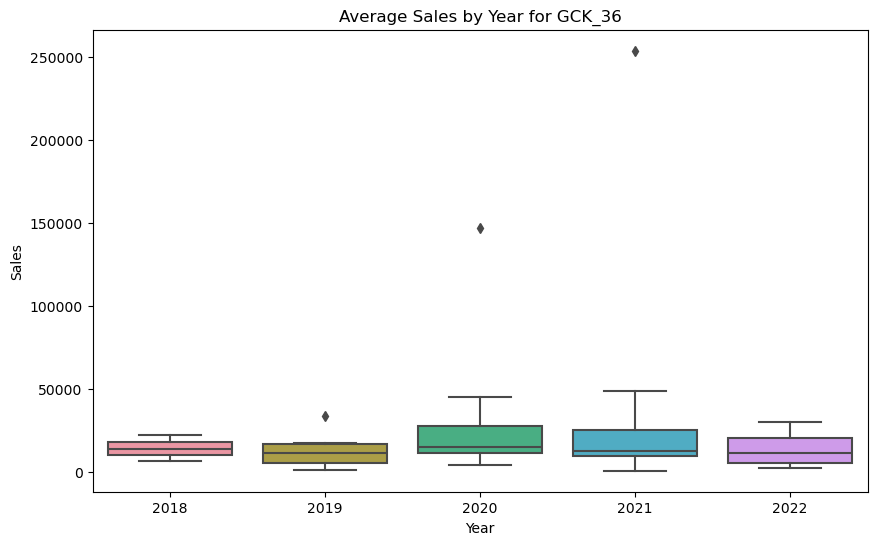

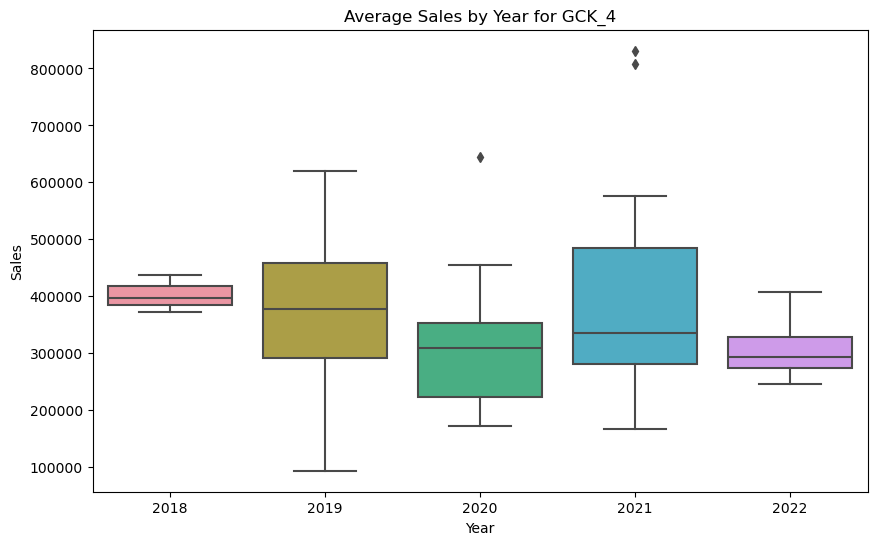

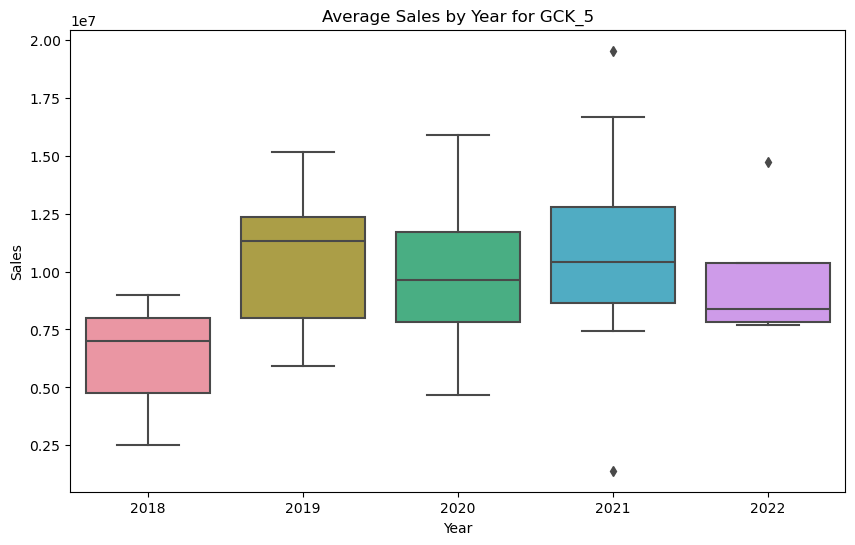

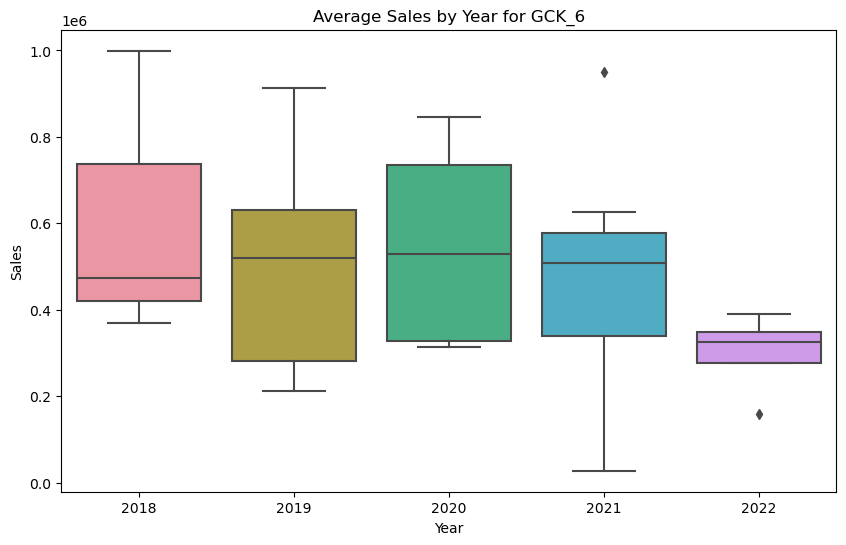

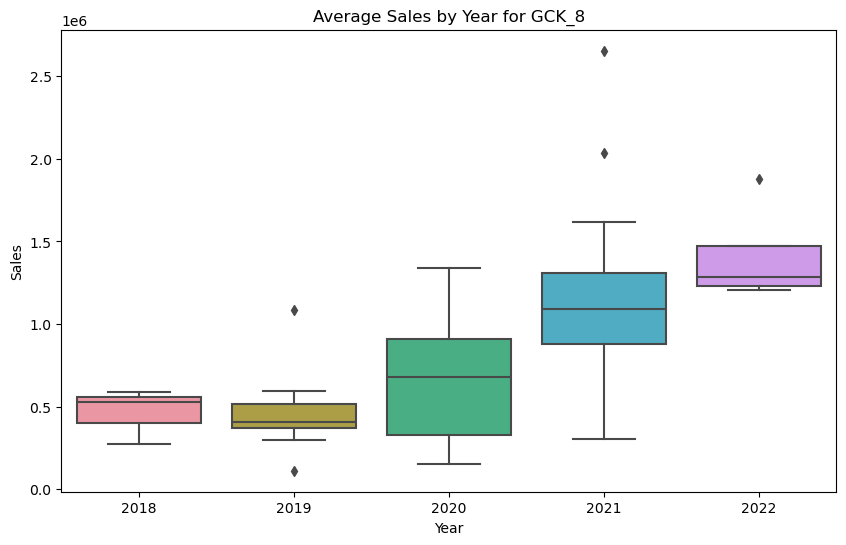

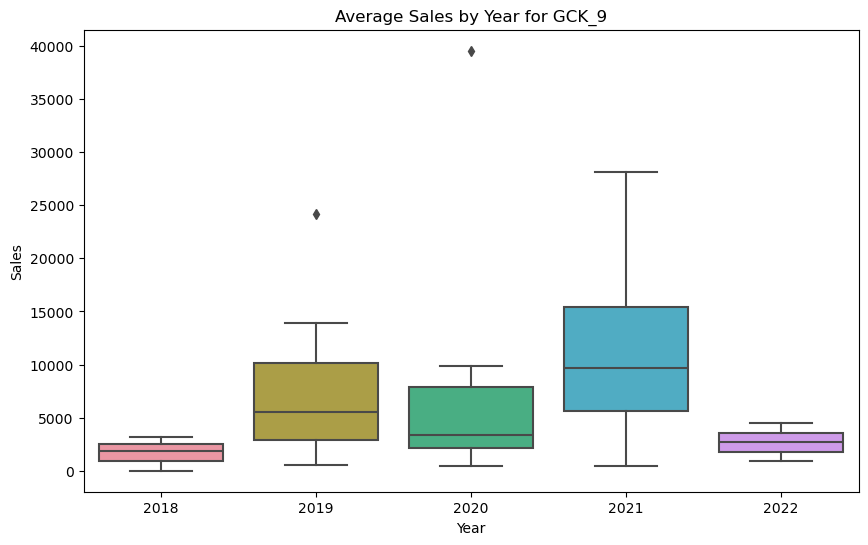

In [44]:
#Average sales per product per year
# Extract year from 'Date'
monthly_sales['Year'] = monthly_sales['Date'].dt.year

# Filter columns starting with 'GCK' or 'National Holidays'
filtered_columns = monthly_sales.columns[monthly_sales.columns.str.startswith('GCK')]

# Iterate over each filtered column, create boxplot for average sales by year
for col in filtered_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=monthly_sales['Year'], y=monthly_sales[col])
    plt.title(f'Average Sales by Year for {col}')
    plt.xlabel('Year')
    plt.ylabel('Sales')
    plt.show()

In [45]:
# média por trimestre (todos os anos agregados)

In [46]:
def plot_moving_average(df, key, freq, col, window, min_periods, ax, title):
    df_grouped = grouped(df, key, freq, col)
    moving_average = df_grouped['mean'].rolling(window=window, center=True, min_periods=min_periods).mean()   
    ax = df_grouped['mean'].plot(color='0.75', linestyle='dashdot', ax=ax)
    ax = moving_average.plot(linewidth=3, color='g', ax=ax)
    ax.set_title(title, fontsize=18)

#Source: Kaggle

TypeError: 'DataFrameGroupBy' object is not callable

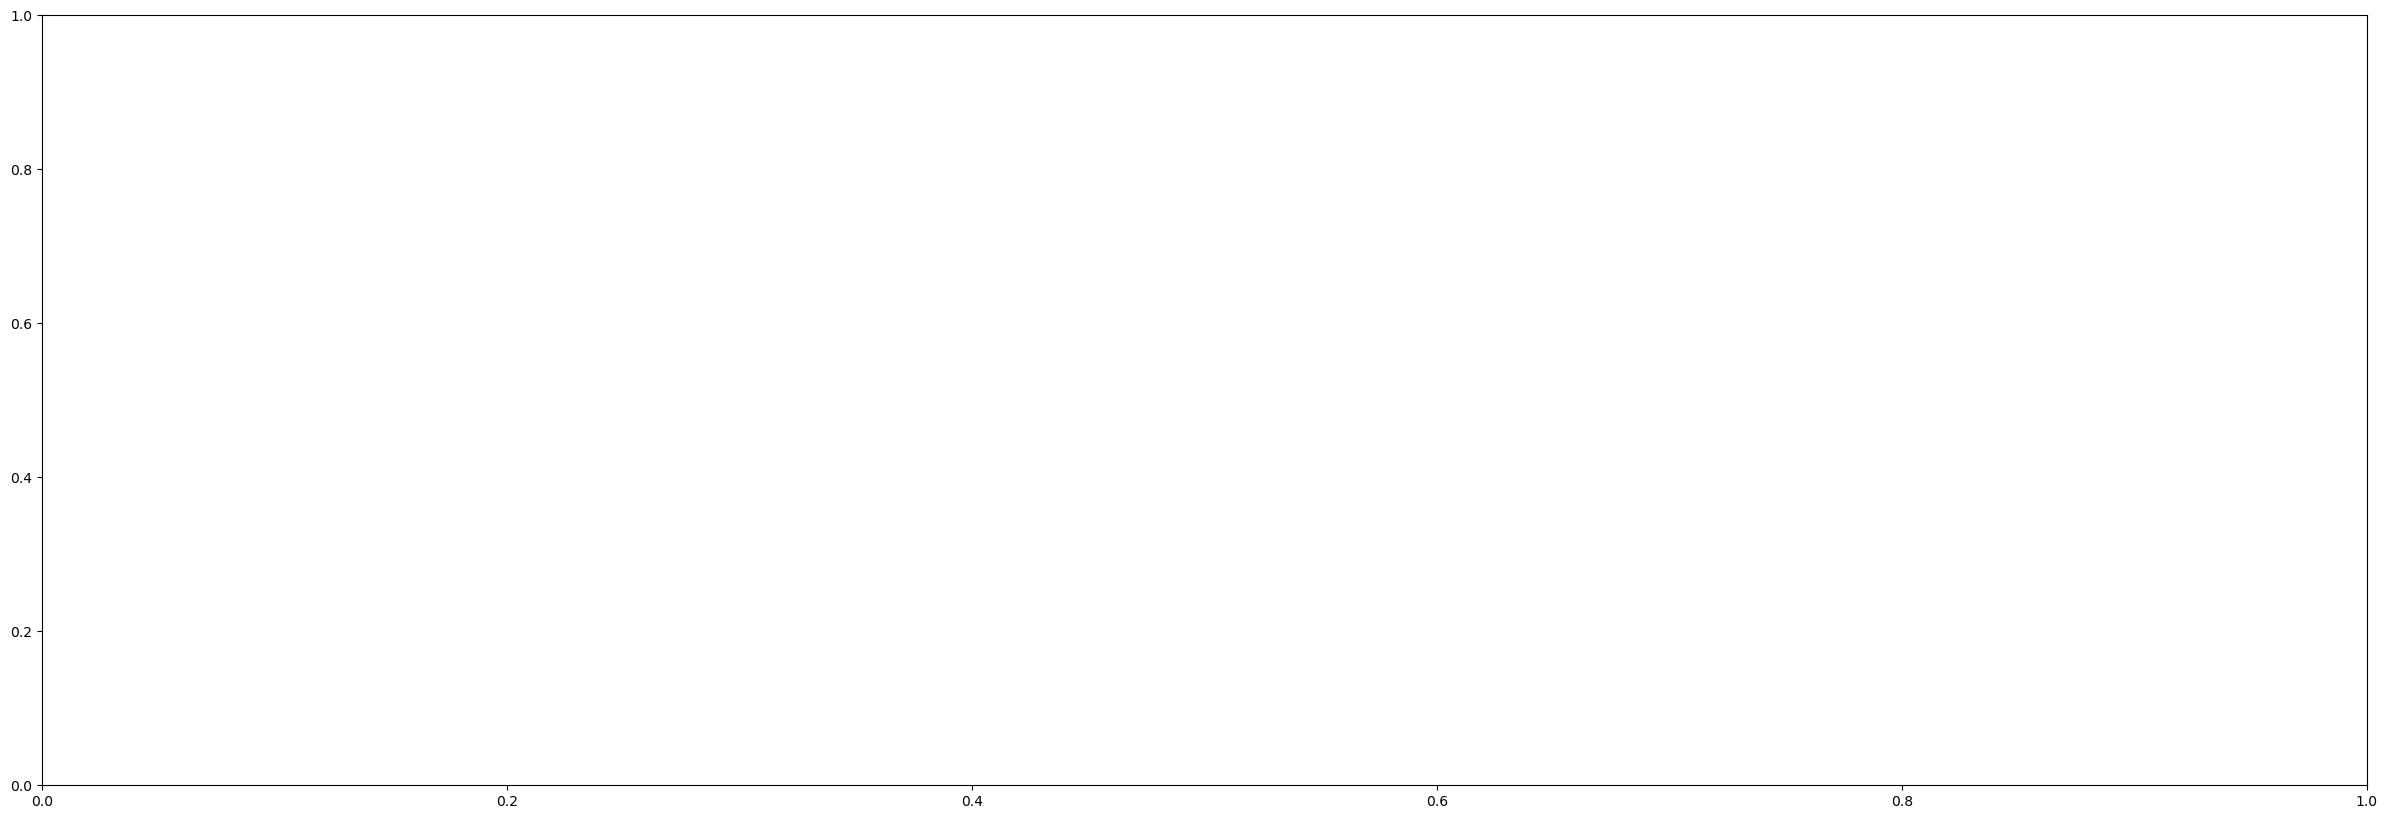

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30,10))
plot_moving_average(monthly_sales, 'Date', 'M', 'Total Sales', 7, 4, axes, 'Sales Moving Average') 
plt.show()

#Source: Kaggle

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


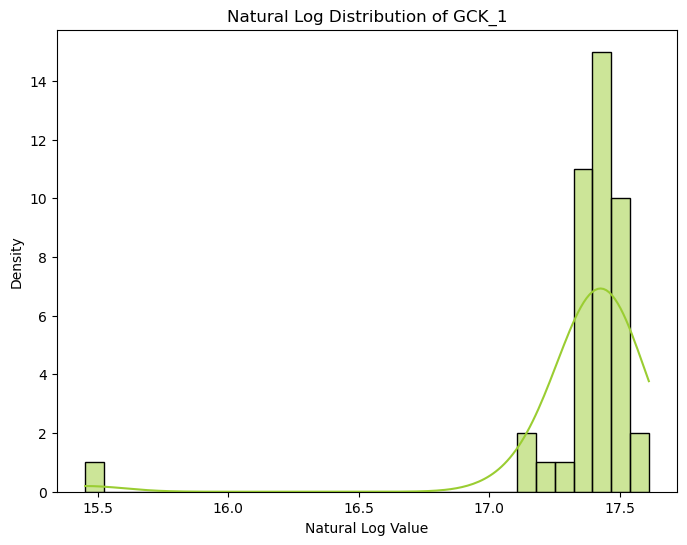

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


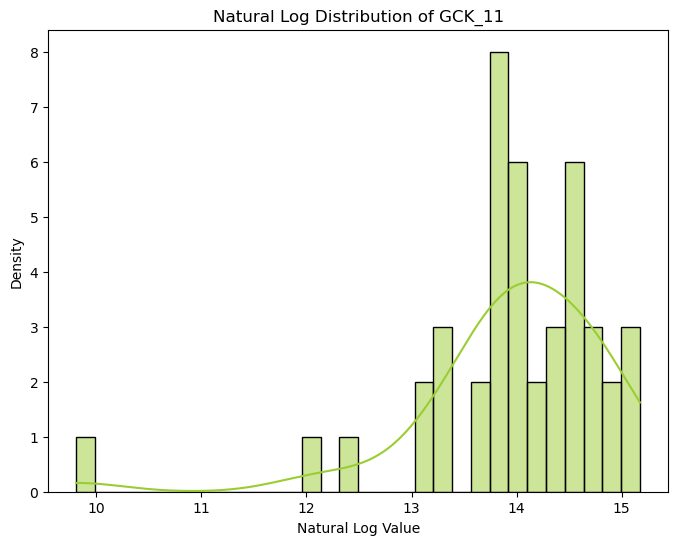

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


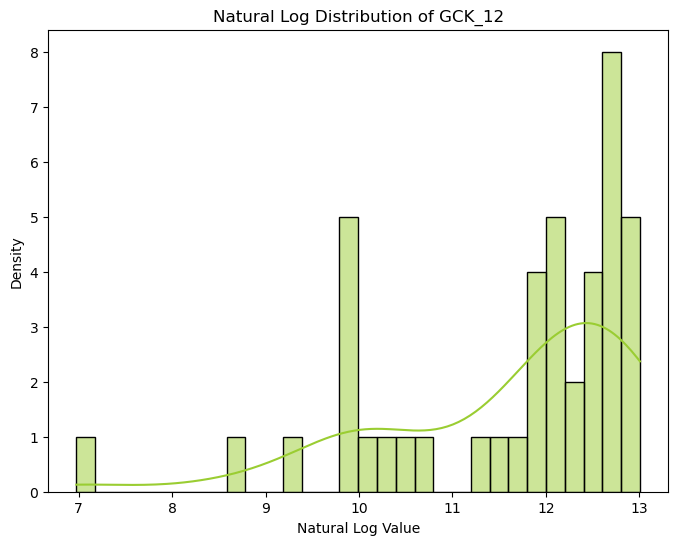

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


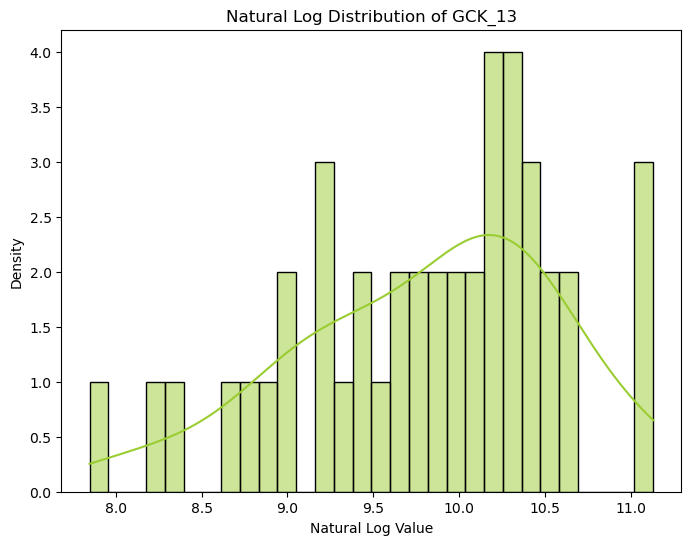

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_40756\76774407.py:10: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(monthly_sales[column].values), kde=True, color="yellowgreen", bins=30)
c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


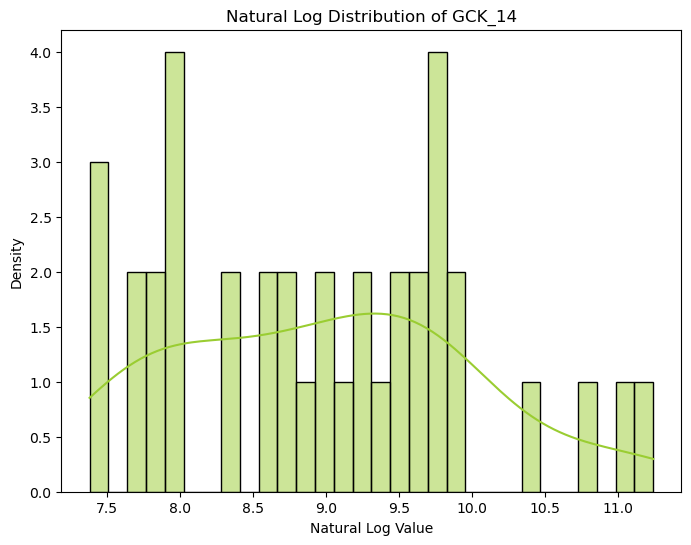

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


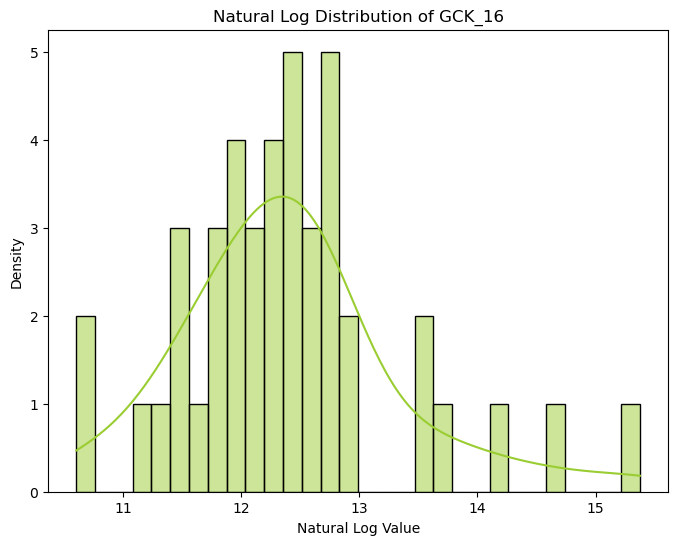

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_40756\76774407.py:10: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(monthly_sales[column].values), kde=True, color="yellowgreen", bins=30)
c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


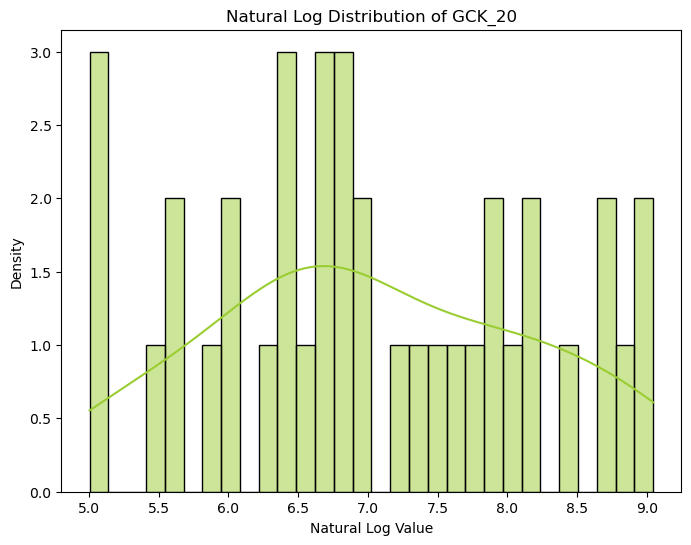

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


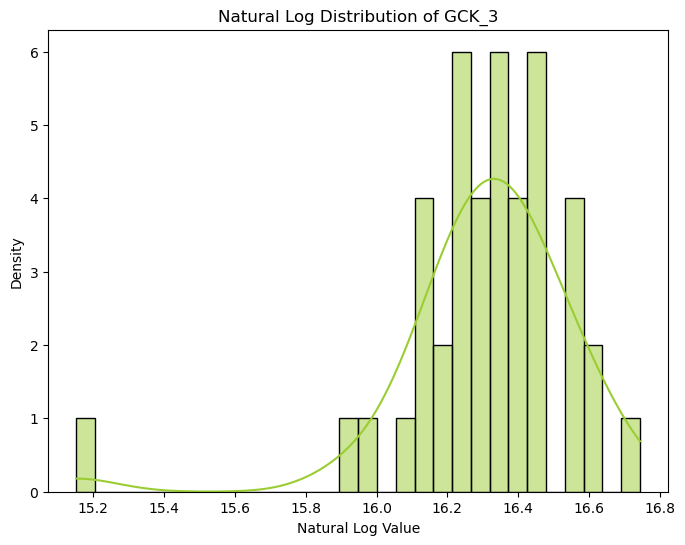

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


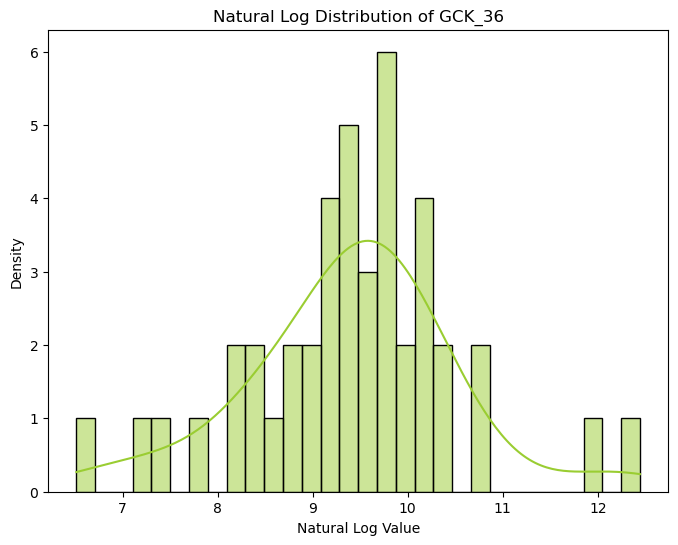

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


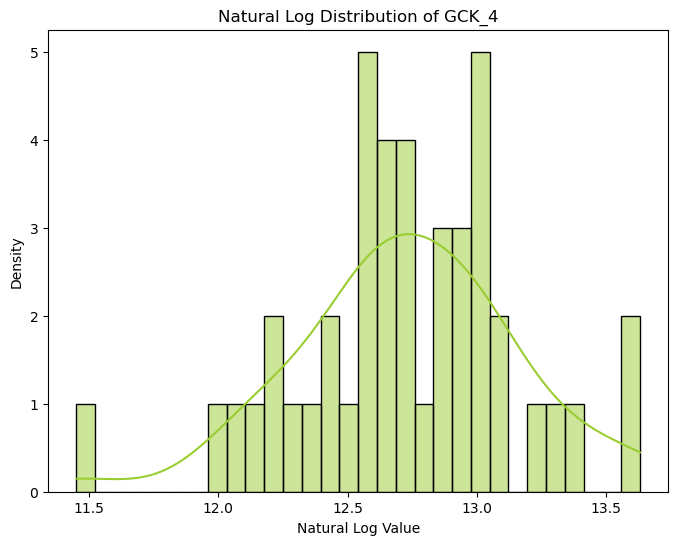

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


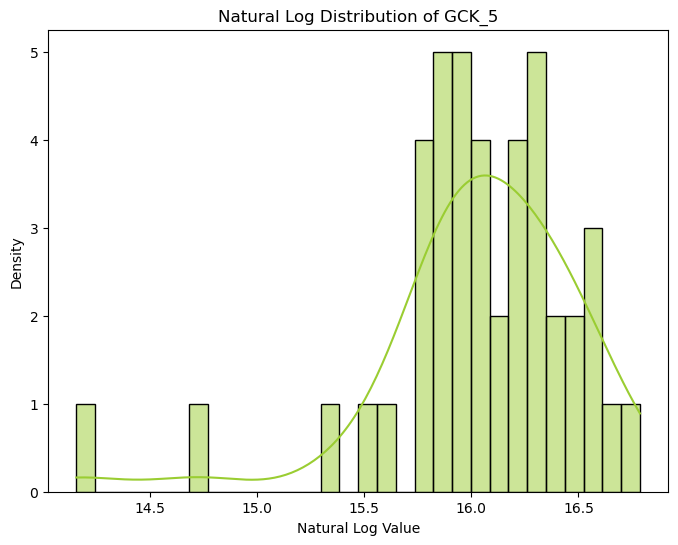

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


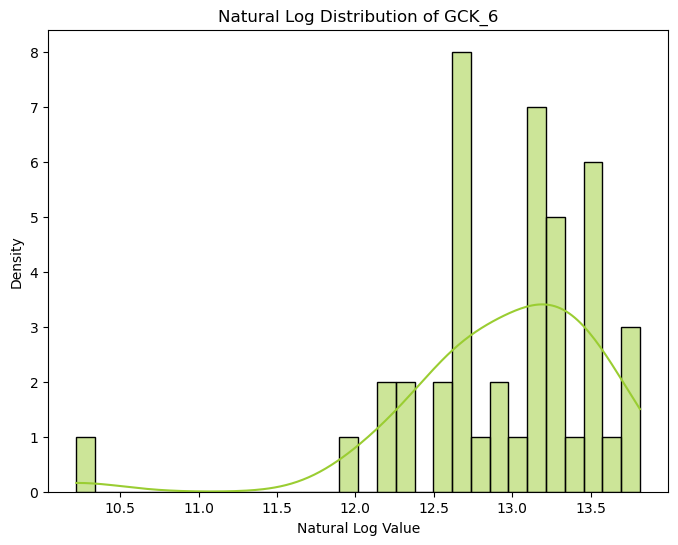

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


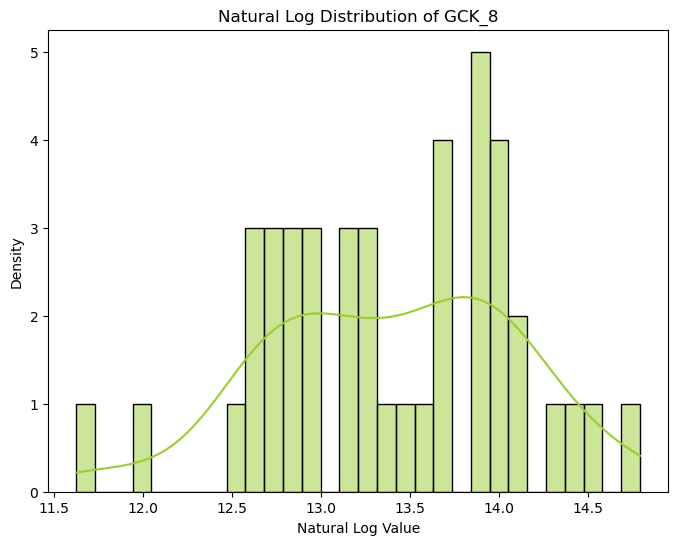

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_40756\76774407.py:10: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(monthly_sales[column].values), kde=True, color="yellowgreen", bins=30)
c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


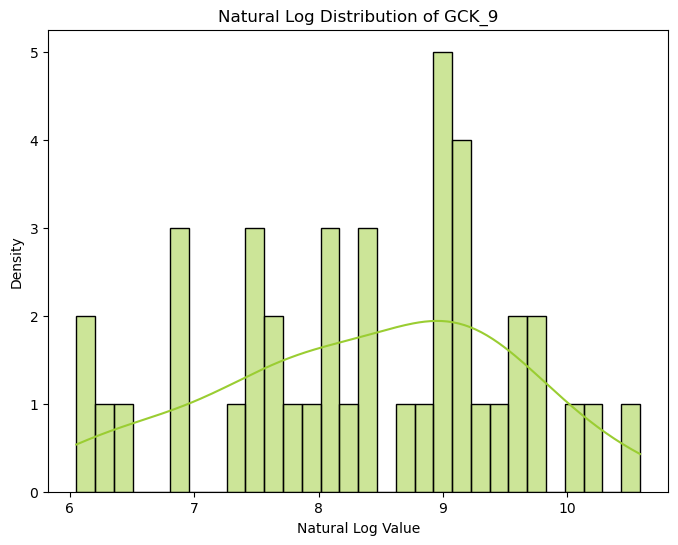

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


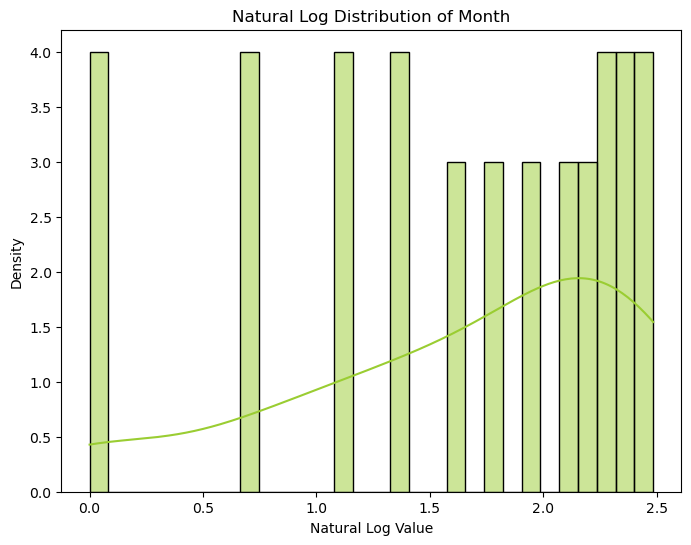

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


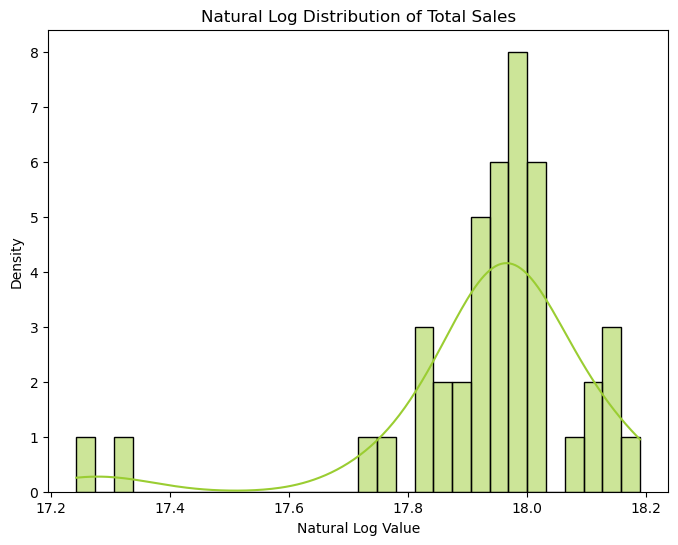

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


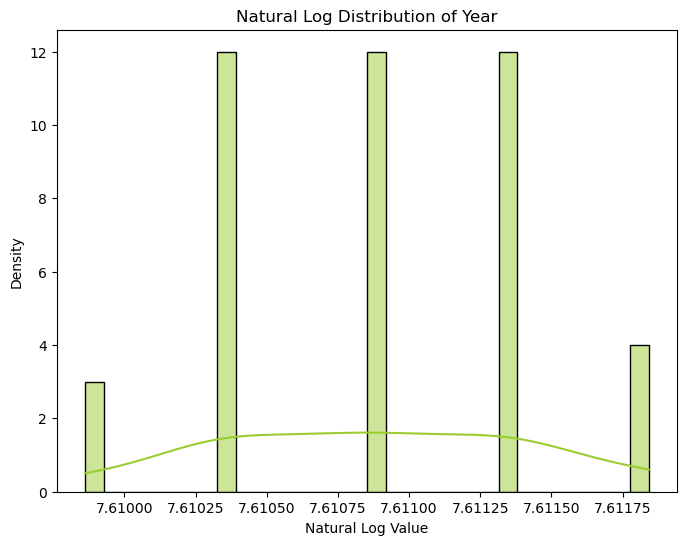

In [49]:
# Plotting the distribution of the logarithm of the sales per product
# Iterate over each column
for column in monthly_sales.columns:
    # Check if the column contains numeric data
    if np.issubdtype(monthly_sales[column].dtype, np.number):
        # Create a new figure and axis for each column
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # Plot the natural logarithm distribution of the column
        sns.histplot(np.log(monthly_sales[column].values), kde=True, color="yellowgreen", bins=30)
        
        # Set title and labels
        ax.set_title(f"Natural Log Distribution of {column}")
        ax.set_xlabel("Natural Log Value")
        ax.set_ylabel("Density")
        
        # Show plot
        plt.show()

#Source: Kaggle

# Preparing Market Data

In [50]:
# Load data 
df2 = pd.read_excel('Case2_Market data.xlsx', header = 1)
df2.head(10)

# Source: previous project notebook

Index 2010=100 (if not otherwise noted)  \
0                                    date   
1                                  2004m2   
2                                  2004m3   
3                                  2004m4   
4                                  2004m5   
5                                  2004m6   
6                                  2004m7   
7                                  2004m8   
8                                  2004m9   
9                                 2004m10   

  Production Index Machinery & Electricals  \
0                           MAB_ELE_PRO156   
1                                16.940704   
2                                23.711852   
3                                24.435235   
4                                23.708115   
5                                27.009138   
6                                23.590959   
7                                24.280597   
8                                25.989192   
9                                24.895962   

  Shipments Index Machinery & Electricals  \
0                          MAB_ELE_SHP156   
1                               16.940704   
2                               23.711852   
3                               24.435235   
4                               23.708115   
5                               27.009138   
6                               23.590959   
7                               24.280597   
8                               25.989192   
9                               24.895962   

  Production Index Machinery & Electricals.1  \
0                             MAB_ELE_PRO250   
1                                 112.091273   
2                                 136.327976   
3                                 117.791806   
4                                 109.002541   
5                                 133.785737   
6                                 117.405904   
7                                  79.137033   
8                                 130.487955   
9                                 119.707613   

  Shipments Index Machinery & Electricals.1  \
0                            MAB_ELE_SHP250   
1                                 83.458866   
2                                106.168192   
3                                 92.007646   
4                                 85.696486   
5                                106.641482   
6                                 89.302781   
7                                 71.798962   
8                                 98.896817   
9                                  99.60374   

  Production Index Machinery & Electricals.2  \
0                             MAB_ELE_PRO276   
1                                  82.623037   
2                                 100.556582   
3                                  89.653203   
4                                  86.880571   
5                                  99.010814   
6                                  94.200318   
7                                  82.804844   
8                                 102.039931   
9                                  93.519358   

  Shipments Index Machinery & Electricals.2  \
0                            MAB_ELE_SHP276   
1                                 79.452532   
2                                 97.012918   
3                                 84.932358   
4                                 82.372794   
5                                  95.10874   
6                                 89.646239   
7                                 80.197268   
8                                 101.18697   
9                                 89.045549   

  Production Index Machinery & Electricals.3  \
0                             MAB_ELE_PRO380   
1                                 124.289603   
2                                 143.411662   
3                                 129.083828   
4                                 135.590391   
5                                 136.424935   
6                                 140.351467   
7                        

In [51]:
# Remove the first row
df2 = df2.drop(0)
df2.head(10)

Index 2010=100 (if not otherwise noted)  \
1                                   2004m2   
2                                   2004m3   
3                                   2004m4   
4                                   2004m5   
5                                   2004m6   
6                                   2004m7   
7                                   2004m8   
8                                   2004m9   
9                                  2004m10   
10                                 2004m11   

   Production Index Machinery & Electricals  \
1                                 16.940704   
2                                 23.711852   
3                                 24.435235   
4                                 23.708115   
5                                 27.009138   
6                                 23.590959   
7                                 24.280597   
8                                 25.989192   
9                                 24.895962   
10                                26.774785   

   Shipments Index Machinery & Electricals  \
1                                16.940704   
2                                23.711852   
3                                24.435235   
4                                23.708115   
5                                27.009138   
6                                23.590959   
7                                24.280597   
8                                25.989192   
9                                24.895962   
10                               26.774785   

   Production Index Machinery & Electricals.1  \
1                                  112.091273   
2                                  136.327976   
3                                  117.791806   
4                                  109.002541   
5                                  133.785737   
6                                  117.405904   
7                                   79.137033   
8                                  130.487955   
9                                  119.707613   
10                                 114.509588   

   Shipments Index Machinery & Electricals.1  \
1                                  83.458866   
2                                 106.168192   
3                                  92.007646   
4                                  85.696486   
5                                 106.641482   
6                                  89.302781   
7                                  71.798962   
8                                  98.896817   
9                                   99.60374   
10                                 86.511165   

   Production Index Machinery & Electricals.2  \
1                                   82.623037   
2                                  100.556582   
3                                   89.653203   
4                                   86.880571   
5                                   99.010814   
6                                   94.200318   
7                                   82.804844   
8                                  102.039931   
9                                   93.519358   
10                                  97.130763   

   Shipments Index Machinery & Electricals.2  \
1                                  79.452532   
2                                  97.012918   
3                                  84.932358   
4                                  82.372794   
5                                   95.10874   
6                                  89.646239   
7                                  80.197268   
8                                  101.18697   
9                                  89.045549   
10                                 93.852657   

   Production Index Machinery & Electricals.3  \
1                                  124.289603   
2                                  143.411662   
3                                  129.083828   
4                                  135.590391   
5                                  136.424935   
6                                  140.

In [52]:
# Rename Index 2010=100 (if not otherwise noted) to Date
df2.rename(columns={'Index 2010=100 (if not otherwise noted)': 'date'}, inplace=True)
df2.head(10)

date Production Index Machinery & Electricals  \
1    2004m2                                16.940704   
2    2004m3                                23.711852   
3    2004m4                                24.435235   
4    2004m5                                23.708115   
5    2004m6                                27.009138   
6    2004m7                                23.590959   
7    2004m8                                24.280597   
8    2004m9                                25.989192   
9   2004m10                                24.895962   
10  2004m11                                26.774785   

   Shipments Index Machinery & Electricals  \
1                                16.940704   
2                                23.711852   
3                                24.435235   
4                                23.708115   
5                                27.009138   
6                                23.590959   
7                                24.280597   
8                                25.989192   
9                                24.895962   
10                               26.774785   

   Production Index Machinery & Electricals.1  \
1                                  112.091273   
2                                  136.327976   
3                                  117.791806   
4                                  109.002541   
5                                  133.785737   
6                                  117.405904   
7                                   79.137033   
8                                  130.487955   
9                                  119.707613   
10                                 114.509588   

   Shipments Index Machinery & Electricals.1  \
1                                  83.458866   
2                                 106.168192   
3                                  92.007646   
4                                  85.696486   
5                                 106.641482   
6                                  89.302781   
7                                  71.798962   
8                                  98.896817   
9                                   99.60374   
10                                 86.511165   

   Production Index Machinery & Electricals.2  \
1                                   82.623037   
2                                  100.556582   
3                                   89.653203   
4                                   86.880571   
5                                   99.010814   
6                                   94.200318   
7                                   82.804844   
8                                  102.039931   
9                                   93.519358   
10                                  97.130763   

   Shipments Index Machinery & Electricals.2  \
1                                  79.452532   
2                                  97.012918   
3                                  84.932358   
4                                  82.372794   
5                                   95.10874   
6                                  89.646239   
7                                  80.197268   
8                                  101.18697   
9                                  89.045549   
10                                 93.852657   

   Production Index Machinery & Electricals.3  \
1                                  124.289603   
2                                  143.411662   
3                                  129.083828   
4                                  135.590391   
5                                  136.424935   
6                                  140.351467   
7                                   54.397252   
8                                  130.661571   
9                                  133.231484   
10                                 130.111098   

   Shipments Index Machinery & Electricals.3  \
1                                  86.560493   
2                                 106.344544   
3                                  95.579673   
4            

In [53]:
# Reorganizing the 'df2' dataset

# Extract year and month from the "date" column
df2['Year'] = df2['date'].apply(lambda x: int(x[:5].rstrip('m')))  # Extract the first 4 characters as year

# Extract month - handle cases where month is single or double digit
df2['Month'] = df2['date'].apply(lambda x: int(x[x.find('m')+1:]))  # Extract characters after 'm' as month


df2.head()

#Source: ChatGPT

date Production Index Machinery & Electricals  \
1   2004m2                                16.940704   
2   2004m3                                23.711852   
3   2004m4                                24.435235   
4   2004m5                                23.708115   
5   2004m6                                27.009138   

  Shipments Index Machinery & Electricals  \
1                               16.940704   
2                               23.711852   
3                               24.435235   
4                               23.708115   
5                               27.009138   

  Production Index Machinery & Electricals.1  \
1                                 112.091273   
2                                 136.327976   
3                                 117.791806   
4                                 109.002541   
5                                 133.785737   

  Shipments Index Machinery & Electricals.1  \
1                                 83.458866   
2                                106.168192   
3                                 92.007646   
4                                 85.696486   
5                                106.641482   

  Production Index Machinery & Electricals.2  \
1                                  82.623037   
2                                 100.556582   
3                                  89.653203   
4                                  86.880571   
5                                  99.010814   

  Shipments Index Machinery & Electricals.2  \
1                                 79.452532   
2                                 97.012918   
3                                 84.932358   
4                                 82.372794   
5                                  95.10874   

  Production Index Machinery & Electricals.3  \
1                                 124.289603   
2                                 143.411662   
3                                 129.083828   
4                                 135.590391   
5                                 136.424935   

  Shipments Index Machinery & Electricals.3  \
1                                 86.560493   
2                                106.344544   
3                                 95.579673   
4                                100.087039   
5                                110.889719   

  Production Index Machinery & Electricals.4  ...  \
1                                  109.33401  ...   
2                                 140.884616  ...   
3                                 105.853579  ...   
4                                 101.864777  ...   
5                                  120.33292  ...   

  United States: Electrical equipment.1 World: Electrical equipment  \
1                            117.723991                         NaN   
2                            119.220779                         NaN   
3                            117.441124                         NaN   
4                            117.899216                         NaN   
5                            119.499107                         NaN   

  Switzerland: Electrical equipment United Kingdom: Electrical equipment.1  \
1                              81.1                             120.706516   
2                         76.690307                              138.30955   
3                         71.552403                              115.55733   
4                           66.4145                             119.269534   
5                         61.276596                             128.849416   

  Italy: Electrical equipment.1 Japan: Electrical equipment  \
1                    141.510864                  106.161262   
2                    152.880234                  140.288741   
3                    137.796875                  106.271197   
4                    143.860535                   101.60871   
5                    144.315308                  116.655248   

  France: Electrical equipment.1 Germany: Electrical equipment.1  Year Month  
1              

In [54]:
# Merge 'year' and 'month' columns into a new 'date' column
df2['Date'] = pd.to_datetime(df2[['Year', 'Month']].assign(day=1))

# Extract the columns "Date", "Month", and "Year"
date_columns = df2[["Date", "Month", "Year"]]

# Drop the extracted columns from the DataFrame
df2.drop(columns=["Date", "Month", "Year"], inplace=True)

# Concatenate the extracted columns at the beginning of the DataFrame
df2 = pd.concat([date_columns, df2], axis=1)

# Drop 'date' column
df2.drop(columns=['date'], inplace=True)

df2.head(10)

Date  Month  Year Production Index Machinery & Electricals  \
1  2004-02-01      2  2004                                16.940704   
2  2004-03-01      3  2004                                23.711852   
3  2004-04-01      4  2004                                24.435235   
4  2004-05-01      5  2004                                23.708115   
5  2004-06-01      6  2004                                27.009138   
6  2004-07-01      7  2004                                23.590959   
7  2004-08-01      8  2004                                24.280597   
8  2004-09-01      9  2004                                25.989192   
9  2004-10-01     10  2004                                24.895962   
10 2004-11-01     11  2004                                26.774785   

   Shipments Index Machinery & Electricals  \
1                                16.940704   
2                                23.711852   
3                                24.435235   
4                                23.708115   
5                                27.009138   
6                                23.590959   
7                                24.280597   
8                                25.989192   
9                                24.895962   
10                               26.774785   

   Production Index Machinery & Electricals.1  \
1                                  112.091273   
2                                  136.327976   
3                                  117.791806   
4                                  109.002541   
5                                  133.785737   
6                                  117.405904   
7                                   79.137033   
8                                  130.487955   
9                                  119.707613   
10                                 114.509588   

   Shipments Index Machinery & Electricals.1  \
1                                  83.458866   
2                                 106.168192   
3                                  92.007646   
4                                  85.696486   
5                                 106.641482   
6                                  89.302781   
7                                  71.798962   
8                                  98.896817   
9                                   99.60374   
10                                 86.511165   

   Production Index Machinery & Electricals.2  \
1                                   82.623037   
2                                  100.556582   
3                                   89.653203   
4                                   86.880571   
5                                   99.010814   
6                                   94.200318   
7                                   82.804844   
8                                  102.039931   
9                                   93.519358   
10                                  97.130763   

   Shipments Index Machinery & Electricals.2  \
1                                  79.452532   
2                                  97.012918   
3                                  84.932358   
4                                  82.372794   
5                                   95.10874   
6                                  89.646239   
7                                  80.197268   
8                                  101.18697   
9                                  89.045549   
10                                 93.852657   

   Production Index Machinery & Electricals.3  ...  \
1                                  124.289603  ...   
2                                  143.411662  ...   
3                                  129.083828  ...   
4                                  135.590391  ...   
5                                  136.424935  ...   
6                                  140.351467  ...   
7                                   54.397252  ...   
8                                  130.661571  ...   
9                                  133.231484  ...   
10                                 130.111

In [55]:
df2.columns

Index(['Date', 'Month', 'Year', 'Production Index Machinery & Electricals',
       'Shipments Index Machinery & Electricals',
       'Production Index Machinery & Electricals.1',
       'Shipments Index Machinery & Electricals.1',
       'Production Index Machinery & Electricals.2',
       'Shipments Index Machinery & Electricals.2',
       'Production Index Machinery & Electricals.3',
       'Shipments Index Machinery & Electricals.3',
       'Production Index Machinery & Electricals.4',
       'Shipments Index Machinery & Electricals.4',
       'Production Index Machinery & Electricals.5',
       'Shipments Index Machinery & Electricals.5',
       'Production Index Machinery & Electricals.6',
       'Shipments Index Machinery & Electricals.6',
       'Production Index Machinery & Electricals.7',
       'Shipments Index Machinery & Electricals.7',
       'Production Index Machinery & Electricals.8',
       'Shipments Index Machinery & Electricals.8',
       'World: Price of Base Metal

In [56]:
# Dictionary to map old column names to new column names
column_mapping = {
    'Production Index Machinery & Electricals': 'China Production Index ME',
    'Shipments Index Machinery & Electricals': 'China Shipments Index ME',
    'Production Index Machinery & Electricals.1': 'France Production Index ME',
    'Shipments Index Machinery & Electricals.1': 'France Shipments Index ME',
    'Production Index Machinery & Electricals.2': 'Germany Production Index ME',
    'Shipments Index Machinery & Electricals.2': 'Germany Shipments Index ME',
    'Production Index Machinery & Electricals.3': 'Italy Production Index ME',
    'Shipments Index Machinery & Electricals.3': 'Italy Shipments Index ME',
    'Production Index Machinery & Electricals.4': 'Japan Production Index ME',
    'Shipments Index Machinery & Electricals.4': 'Japan Shipments Index ME',
    'Production Index Machinery & Electricals.5': 'Switzerland Production Index ME',
    'Shipments Index Machinery & Electricals.5': 'Switzerland Shipments Index ME',
    'Production Index Machinery & Electricals.6': 'UK Production Index ME',
    'Shipments Index Machinery & Electricals.6': 'UK Shipments Index ME',
    'Production Index Machinery & Electricals.7': 'US Production Index ME',
    'Shipments Index Machinery & Electricals.7': 'US Shipments Index ME',
    'Production Index Machinery & Electricals.8': 'Europe Production Index ME',
    'Shipments Index Machinery & Electricals.8': 'Europe Shipments Index ME',
    'World: Price of Base Metals': 'World Base Metals Price',
    'World: Price of Energy': 'World Energy Price',
    'World: Price of Metals & Minerals': 'World Metals & Minerals Price',
    'World: Price of Natural gas index': 'World Natural Gas Price Index',
    'World: Price of Crude oil, average': 'World Crude Oil Average Price',
    'World: Price of Copper': 'World Copper Price',
    'United States: EUR in LCU': 'US EUR in LCU',
    'United States: Electrical equipment': 'US Producer Prices EE',
    'United Kingdom: Electrical equipment': 'UK Producer Prices EE',
    'Italy: Electrical equipment': 'Italy Producer Prices EE',
    'France: Electrical equipment': 'France Producer Prices EE',
    'Germany: Electrical equipment': 'Germany Producer Prices EE',
    'China: Electrical equipment': 'China Producer Prices EE',
    'United States: Machinery and equipment n.e.c.': 'US Machinery and Equipment NEC',
    'World: Machinery and equipment n.e.c.': 'World Machinery and Equipment NEC',
    'Switzerland: Machinery and equipment n.e.c.': 'Switzerland Machinery and Equipment NEC',
    'United Kingdom: Machinery and equipment n.e.c.': 'UK Machinery and Equipment NEC',
    'Italy: Machinery and equipment n.e.c.': 'Italy Machinery and Equipment NEC',
    'Japan: Machinery and equipment n.e.c.': 'Japan Machinery and Equipment NEC',
    'France: Machinery and equipment n.e.c.': 'France Machinery and Equipment NEC',
    'Germany: Machinery and equipment n.e.c.': 'Germany Machinery and Equipment NEC',
    'United States: Electrical equipment.1': 'US Production Index EE',
    'World: Electrical equipment': 'World Production Index EE',
    'Switzerland: Electrical equipment': 'Switzerland Production Index EE',
    'United Kingdom: Electrical equipment.1': 'UK Production Index EE',
    'Italy: Electrical equipment.1': 'Italy Production Index EE',
    'Japan: Electrical equipment': 'Japan Production Index EE',
    'France: Electrical equipment.1': 'France Production Index EE',
    'Germany: Electrical equipment.1': 'Germany Production Index EE'
}

# Rename columns using the mapping dictionary
df2.rename(columns=column_mapping, inplace=True)


In [57]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 1 to 219
Data columns (total 50 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Date                                     219 non-null    datetime64[ns]
 1   Month                                    219 non-null    int64         
 2   Year                                     219 non-null    int64         
 3   China Production Index ME                219 non-null    object        
 4   China Shipments Index ME                 219 non-null    object        
 5   France Production Index ME               219 non-null    object        
 6   France Shipments Index ME                219 non-null    object        
 7   Germany Production Index ME              219 non-null    object        
 8   Germany Shipments Index ME               219 non-null    object        
 9   Italy Production Index ME                21

In [58]:
df2.isnull().sum()

Date                                        0
Month                                       0
Year                                        0
China Production Index ME                   0
China Shipments Index ME                    0
France Production Index ME                  0
France Shipments Index ME                   0
Germany Production Index ME                 0
Germany Shipments Index ME                  0
Italy Production Index ME                   0
Italy Shipments Index ME                    0
Japan Production Index ME                   0
Japan Shipments Index ME                    0
Switzerland Production Index ME             1
Switzerland Shipments Index ME              1
UK Production Index ME                      0
UK Shipments Index ME                      18
US Production Index ME                      0
US Shipments Index ME                       1
Europe Production Index ME                  0
Europe Shipments Index ME                   0
World Base Metals Price           

CatBoost is designed to handle missing values automatically. It has built-in support for missing values in both categorical and numerical features. It uses an algorithm called Ordered Boosting that allows it to effectively deal with missing values during training without requiring imputation. Therefore, we will not treat them even though we acknowledge there existence.

In [59]:
# Initialize a list to store pairs of columns with matching values for all rows
matching_columns_pairs = []

# Iterate through each pair of columns
for i, col1 in enumerate(df2.columns):
    for col2 in df2.columns[i + 1:]:  # Start from i+1 to avoid comparing same pairs again
        # Check if all values in col1 match the corresponding values in col2 for all rows
        if df2[col1].equals(df2[col2]):
            matching_columns_pairs.append((col1, col2))

# Print pairs of columns with matching values for all rows
if matching_columns_pairs:
    print("Pairs of columns with matching values for all rows:")
    for pair in matching_columns_pairs:
        print(pair)
else:
    print("No pairs of columns with matching values for all rows found.")

# Source: ChatGPT    

Pairs of columns with matching values for all rows:
('China Production Index ME', 'China Shipments Index ME')


In [60]:
# One of the columns will be droped (shipments) because China is a very impactful country we need to keep one
df2.drop(columns=['China Shipments Index ME'], inplace=True)

In [61]:
# By disregarding the first two columns we check if there duplicated rows
df2[df2.iloc[:, 3:].duplicated()]
#There are two duplicated rows Production Index Machinery & Electricals_China and Shipments Index Machinery & Electricals_China are the same.

Empty DataFrame
Columns: [Date, Month, Year, China Production Index ME, France Production Index ME, France Shipments Index ME, Germany Production Index ME, Germany Shipments Index ME, Italy Production Index ME, Italy Shipments Index ME, Japan Production Index ME, Japan Shipments Index ME, Switzerland Production Index ME, Switzerland Shipments Index ME, UK Production Index ME, UK Shipments Index ME, US Production Index ME, US Shipments Index ME, Europe Production Index ME, Europe Shipments Index ME, World Base Metals Price, World Energy Price, World: Price of Metals  & Minerals, World Natural Gas Price Index, World Crude Oil Average Price, World Copper Price, US EUR in LCU, US Producer Prices EE, UK Producer Prices EE, Italy Producer Prices EE, France Producer Prices EE, Germany Producer Prices EE, China Producer Prices EE, US Machinery and Equipment NEC, World Machinery and Equipment NEC, Switzerland Machinery and Equipment NEC, UK Machinery and Equipment NEC, Italy Machinery and Equipment NEC, Japan Machinery and Equipment NEC, France Machinery and Equipment NEC, Germany Machinery and Equipment NEC, US Production Index EE, World Production Index EE, Switzerland Production Index EE, UK Production Index EE, Italy Production Index EE, Japan Production Index EE, France Production Index EE, Germany Production Index EE]
Index: []

[0 rows x 49 columns]

In [62]:
market_df = df2.copy()

## Data Visualization

In [63]:
# média por mês por país

# Merge Sales and Market Data

In [64]:
merged_data = pd.merge(df2, monthly_sales[['Date', 'Total Sales']], on='Date', how='left')

# Filter out rows earlier than October 2018
merged_data = merged_data[merged_data['Date'] >= '2018-10-01']
merged_data = merged_data.set_index('Date')
merged_data.head(10)

Month  Year China Production Index ME France Production Index ME  \
Date                                                                           
2018-10-01     10  2018                211.955755                 108.280608   
2018-11-01     11  2018                220.519655                  99.636911   
2018-12-01     12  2018                241.846854                  94.690312   
2019-01-01      1  2019                175.668147                  90.143775   
2019-02-01      2  2019                175.668147                  92.551521   
2019-03-01      3  2019                261.642802                 107.861788   
2019-04-01      4  2019                219.595813                  98.677844   
2019-05-01      5  2019                234.169196                   94.77955   
2019-06-01      6  2019                 261.12635                  98.978105   
2019-07-01      7  2019                217.053447                 100.354372   

           France Shipments Index ME Germany Production Index ME  \
Date                                                               
2018-10-01                122.451734                  124.227879   
2018-11-01                 115.95821                  127.404132   
2018-12-01                115.128469                  120.518565   
2019-01-01                108.325154                  104.776326   
2019-02-01                108.944656                  109.597012   
2019-03-01                126.966216                  122.534648   
2019-04-01                114.917432                  110.612414   
2019-05-01                110.814496                  115.712333   
2019-06-01                122.045555                  108.917455   
2019-07-01                107.250458                  117.126331   

           Germany Shipments Index ME Italy Production Index ME  \
Date                                                              
2018-10-01                 137.741953                118.350514   
2018-11-01                 142.732193                 107.71926   
2018-12-01                 141.407661                 88.783181   
2019-01-01                 118.703828                 99.275113   
2019-02-01                 122.686997                104.586684   
2019-03-01                 140.116214                114.299549   
2019-04-01                 127.512006                 99.732969   
2019-05-01                 131.993634                118.006286   
2019-06-01                 126.769557                108.231888   
2019-07-01                 132.660766                114.705312   

           Italy Shipments Index ME Japan Production Index ME  ...  \
Date                                                           ...   
2018-10-01               122.456894                125.209957  ...   
2018-11-01               120.132032                122.624695  ...   
2018-12-01               131.936099                122.991956  ...   
2019-01-01                92.418842                105.514024  ...   
2019-02-01               103.214212                114.466647  ...   
2019-03-01               122.454318                141.637717  ...   
2019-04-01               106.279804                107.150653  ...   
2019-05-01               123.261639                108.940926  ...   
2019-06-01               121.312004                117.747574  ...   
2019-07-01               123.572862                118.878856  ...   

           Germany Machinery and Equipment NEC US Production Index EE  \
Date                                                                    
2018-10-01                          127.461136             112.853256   
2018-11-01                          132.987915             113.145294   
2018-12-01                          137.363281             111.823624   
2019-01-01                           104.43293             109.499725   
2019-02-01                          112.838226             110.835655   
2019-03-01                          128.612549             111.092499   
2019

In [65]:
# Create the 'Covid_boolean' column
merged_data['Covid_boolean'] = ((merged_data['Year'] >= 2020) & (merged_data['Year'] <= 2022)).astype(int)

merged_data.head(10)

#Source: ChatGPT

Month  Year China Production Index ME France Production Index ME  \
Date                                                                           
2018-10-01     10  2018                211.955755                 108.280608   
2018-11-01     11  2018                220.519655                  99.636911   
2018-12-01     12  2018                241.846854                  94.690312   
2019-01-01      1  2019                175.668147                  90.143775   
2019-02-01      2  2019                175.668147                  92.551521   
2019-03-01      3  2019                261.642802                 107.861788   
2019-04-01      4  2019                219.595813                  98.677844   
2019-05-01      5  2019                234.169196                   94.77955   
2019-06-01      6  2019                 261.12635                  98.978105   
2019-07-01      7  2019                217.053447                 100.354372   

           France Shipments Index ME Germany Production Index ME  \
Date                                                               
2018-10-01                122.451734                  124.227879   
2018-11-01                 115.95821                  127.404132   
2018-12-01                115.128469                  120.518565   
2019-01-01                108.325154                  104.776326   
2019-02-01                108.944656                  109.597012   
2019-03-01                126.966216                  122.534648   
2019-04-01                114.917432                  110.612414   
2019-05-01                110.814496                  115.712333   
2019-06-01                122.045555                  108.917455   
2019-07-01                107.250458                  117.126331   

           Germany Shipments Index ME Italy Production Index ME  \
Date                                                              
2018-10-01                 137.741953                118.350514   
2018-11-01                 142.732193                 107.71926   
2018-12-01                 141.407661                 88.783181   
2019-01-01                 118.703828                 99.275113   
2019-02-01                 122.686997                104.586684   
2019-03-01                 140.116214                114.299549   
2019-04-01                 127.512006                 99.732969   
2019-05-01                 131.993634                118.006286   
2019-06-01                 126.769557                108.231888   
2019-07-01                 132.660766                114.705312   

           Italy Shipments Index ME Japan Production Index ME  ...  \
Date                                                           ...   
2018-10-01               122.456894                125.209957  ...   
2018-11-01               120.132032                122.624695  ...   
2018-12-01               131.936099                122.991956  ...   
2019-01-01                92.418842                105.514024  ...   
2019-02-01               103.214212                114.466647  ...   
2019-03-01               122.454318                141.637717  ...   
2019-04-01               106.279804                107.150653  ...   
2019-05-01               123.261639                108.940926  ...   
2019-06-01               121.312004                117.747574  ...   
2019-07-01               123.572862                118.878856  ...   

           US Production Index EE World Production Index EE  \
Date                                                          
2018-10-01             112.853256                129.325775   
2018-11-01             113.145294                128.236176   
2018-12-01             111.823624                117.043549   
2019-01-01             109.499725                111.522202   
2019-02-01             110.835655                112.666725   
2019-03-01             111.092499                131.456177   
2019-04-01             109.490013                119.415619   
2019-05-01           

In [66]:
# Create a new variable 'Summer' to place 1 if between June and September of each year, and 0 otherwise
merged_data['Year_closure_boolean'] = ((merged_data['Month'] >= 6) & (merged_data['Month'] <= 9)).astype(int)

merged_data.head(10)

#Source: ChatGPT

Month  Year China Production Index ME France Production Index ME  \
Date                                                                           
2018-10-01     10  2018                211.955755                 108.280608   
2018-11-01     11  2018                220.519655                  99.636911   
2018-12-01     12  2018                241.846854                  94.690312   
2019-01-01      1  2019                175.668147                  90.143775   
2019-02-01      2  2019                175.668147                  92.551521   
2019-03-01      3  2019                261.642802                 107.861788   
2019-04-01      4  2019                219.595813                  98.677844   
2019-05-01      5  2019                234.169196                   94.77955   
2019-06-01      6  2019                 261.12635                  98.978105   
2019-07-01      7  2019                217.053447                 100.354372   

           France Shipments Index ME Germany Production Index ME  \
Date                                                               
2018-10-01                122.451734                  124.227879   
2018-11-01                 115.95821                  127.404132   
2018-12-01                115.128469                  120.518565   
2019-01-01                108.325154                  104.776326   
2019-02-01                108.944656                  109.597012   
2019-03-01                126.966216                  122.534648   
2019-04-01                114.917432                  110.612414   
2019-05-01                110.814496                  115.712333   
2019-06-01                122.045555                  108.917455   
2019-07-01                107.250458                  117.126331   

           Germany Shipments Index ME Italy Production Index ME  \
Date                                                              
2018-10-01                 137.741953                118.350514   
2018-11-01                 142.732193                 107.71926   
2018-12-01                 141.407661                 88.783181   
2019-01-01                 118.703828                 99.275113   
2019-02-01                 122.686997                104.586684   
2019-03-01                 140.116214                114.299549   
2019-04-01                 127.512006                 99.732969   
2019-05-01                 131.993634                118.006286   
2019-06-01                 126.769557                108.231888   
2019-07-01                 132.660766                114.705312   

           Italy Shipments Index ME Japan Production Index ME  ...  \
Date                                                           ...   
2018-10-01               122.456894                125.209957  ...   
2018-11-01               120.132032                122.624695  ...   
2018-12-01               131.936099                122.991956  ...   
2019-01-01                92.418842                105.514024  ...   
2019-02-01               103.214212                114.466647  ...   
2019-03-01               122.454318                141.637717  ...   
2019-04-01               106.279804                107.150653  ...   
2019-05-01               123.261639                108.940926  ...   
2019-06-01               121.312004                117.747574  ...   
2019-07-01               123.572862                118.878856  ...   

           World Production Index EE Switzerland Production Index EE  \
Date                                                                   
2018-10-01                129.325775                      112.970843   
2018-11-01                128.236176                      114.736013   
2018-12-01                117.043549                      116.501182   
2019-01-01                111.522202                       110.35461   
2019-02-01                112.666725                      104.208038   
2019-03-01                131.456177                       98.061466   
2019-04-01  

In [67]:
merged_data.columns

Index(['Month', 'Year', 'China Production Index ME',
       'France Production Index ME', 'France Shipments Index ME',
       'Germany Production Index ME', 'Germany Shipments Index ME',
       'Italy Production Index ME', 'Italy Shipments Index ME',
       'Japan Production Index ME', 'Japan Shipments Index ME',
       'Switzerland Production Index ME', 'Switzerland Shipments Index ME',
       'UK Production Index ME', 'UK Shipments Index ME',
       'US Production Index ME', 'US Shipments Index ME',
       'Europe Production Index ME', 'Europe Shipments Index ME',
       'World Base Metals Price', 'World Energy Price',
       'World: Price of Metals  & Minerals', 'World Natural Gas Price Index',
       'World Crude Oil Average Price', 'World Copper Price', 'US EUR in LCU',
       'US Producer Prices EE', 'UK Producer Prices EE',
       'Italy Producer Prices EE', 'France Producer Prices EE',
       'Germany Producer Prices EE', 'China Producer Prices EE',
       'US Machinery and Equ

In [68]:
merged_data.dtypes

Month                                        int64
Year                                         int64
China Production Index ME                   object
France Production Index ME                  object
France Shipments Index ME                   object
Germany Production Index ME                 object
Germany Shipments Index ME                  object
Italy Production Index ME                   object
Italy Shipments Index ME                    object
Japan Production Index ME                   object
Japan Shipments Index ME                    object
Switzerland Production Index ME             object
Switzerland Shipments Index ME              object
UK Production Index ME                      object
UK Shipments Index ME                       object
US Production Index ME                      object
US Shipments Index ME                       object
Europe Production Index ME                  object
Europe Shipments Index ME                   object
World Base Metals Price        

In [69]:
# Convert object columns to float
object_columns = merged_data.select_dtypes(include=['object']).columns
merged_data[object_columns] = merged_data[object_columns].astype(float, errors='ignore')

In [70]:
merged_data.dtypes

Month                                        int64
Year                                         int64
China Production Index ME                  float64
France Production Index ME                 float64
France Shipments Index ME                  float64
Germany Production Index ME                float64
Germany Shipments Index ME                 float64
Italy Production Index ME                  float64
Italy Shipments Index ME                   float64
Japan Production Index ME                  float64
Japan Shipments Index ME                   float64
Switzerland Production Index ME            float64
Switzerland Shipments Index ME             float64
UK Production Index ME                     float64
UK Shipments Index ME                      float64
US Production Index ME                     float64
US Shipments Index ME                      float64
Europe Production Index ME                 float64
Europe Shipments Index ME                  float64
World Base Metals Price        

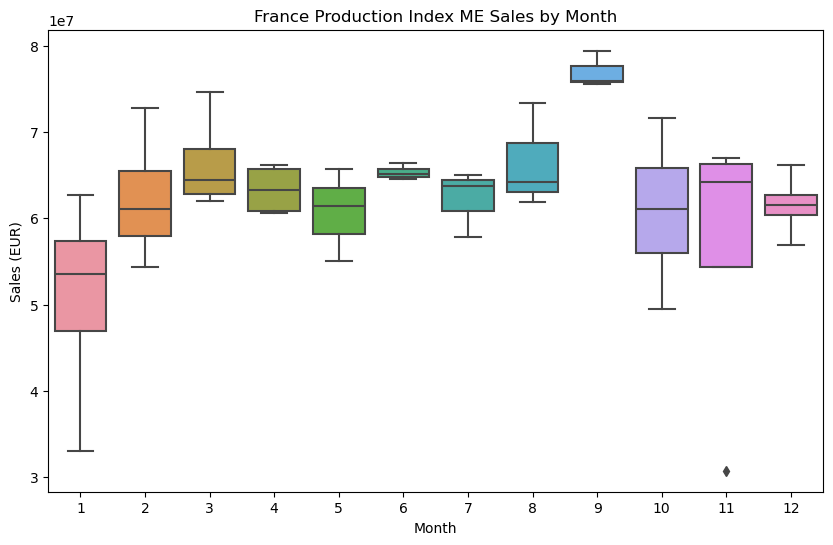

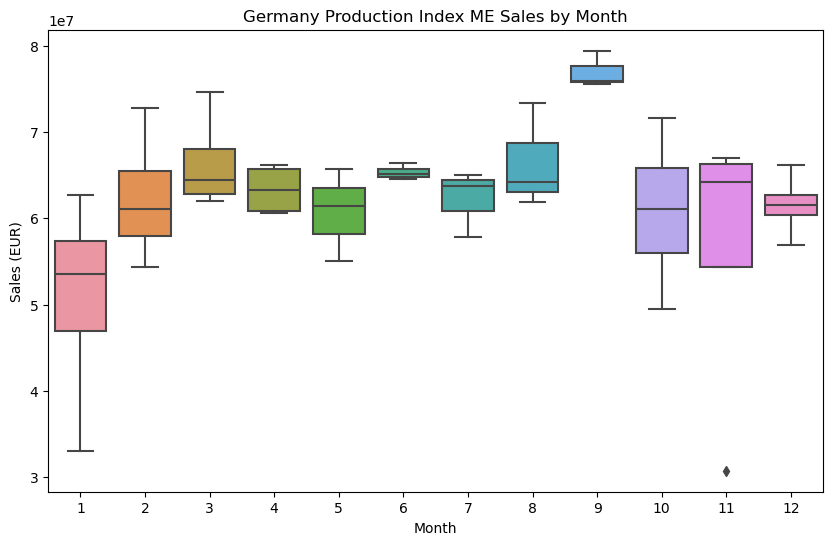

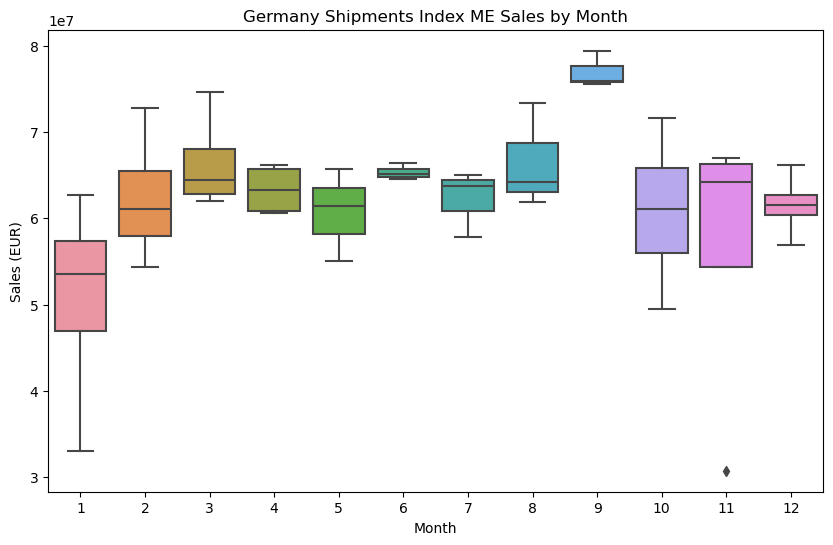

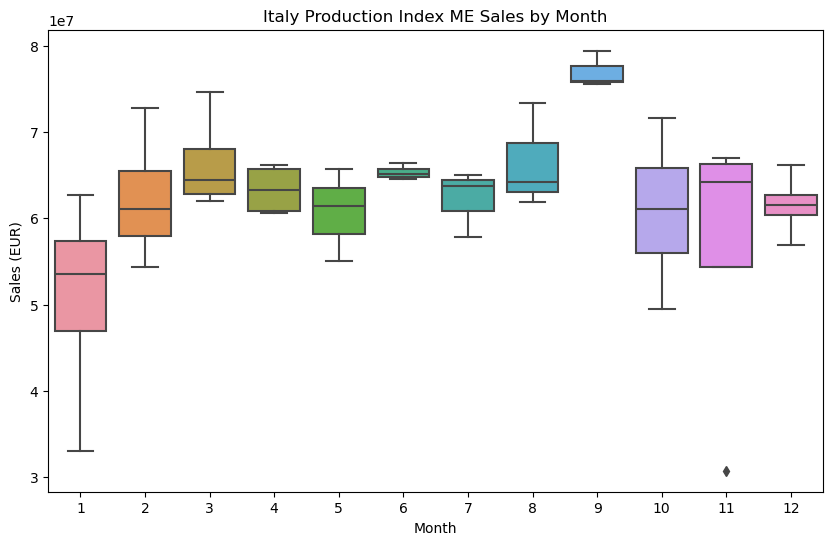

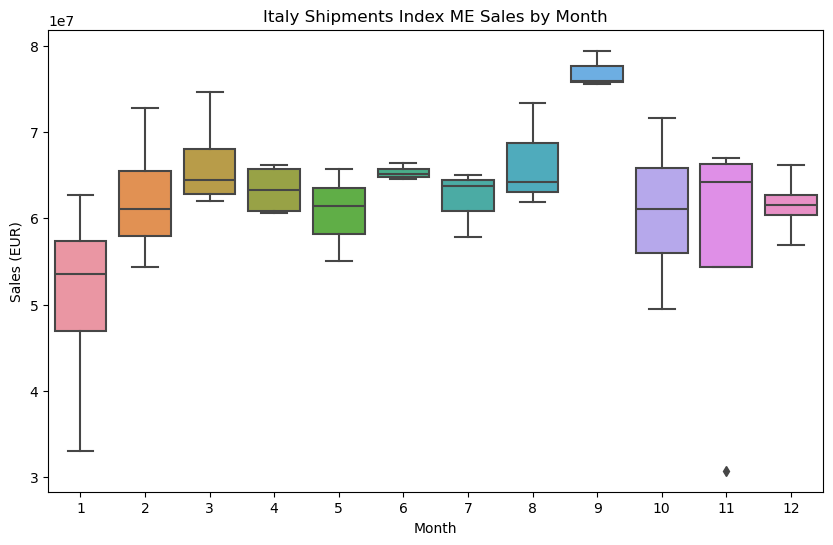

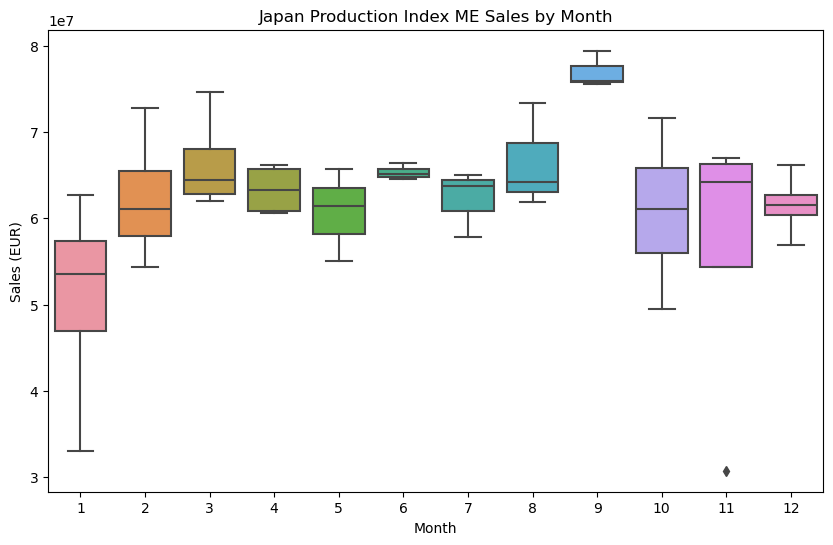

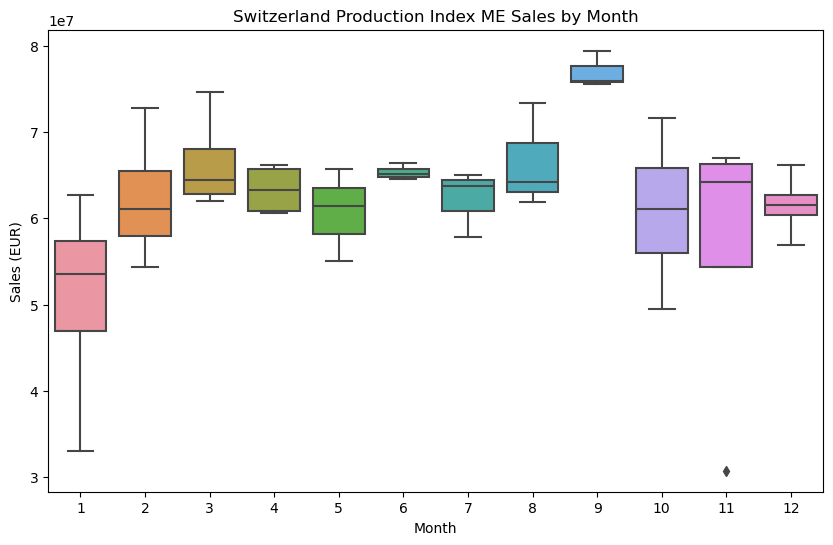

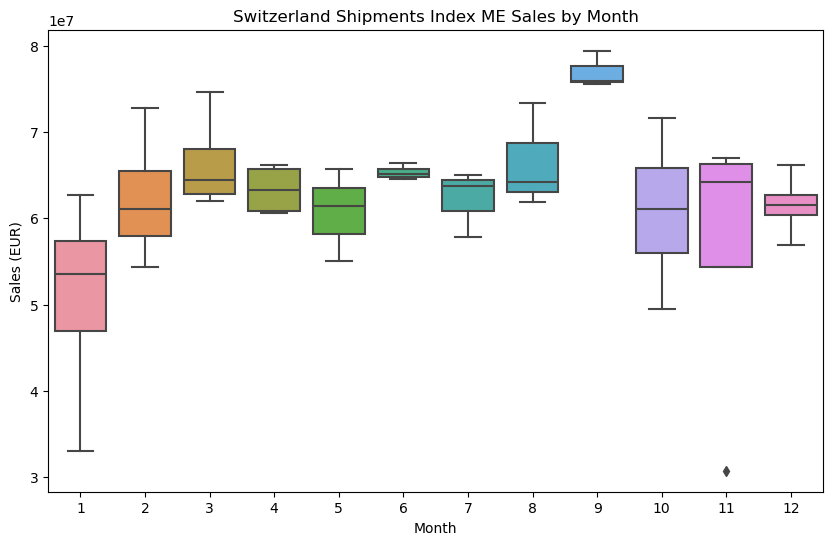

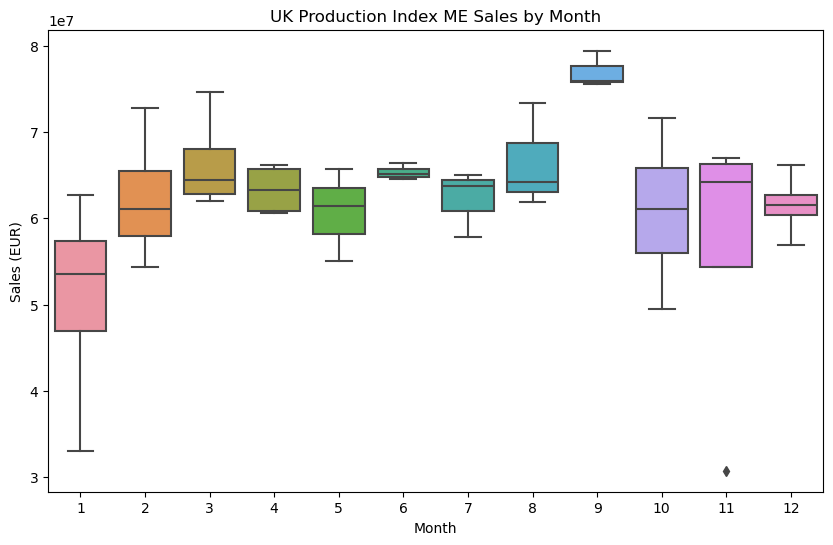

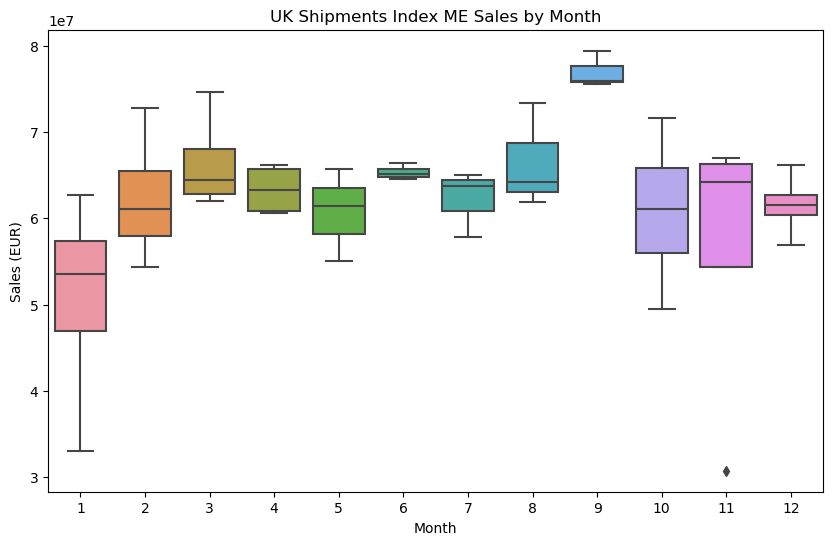

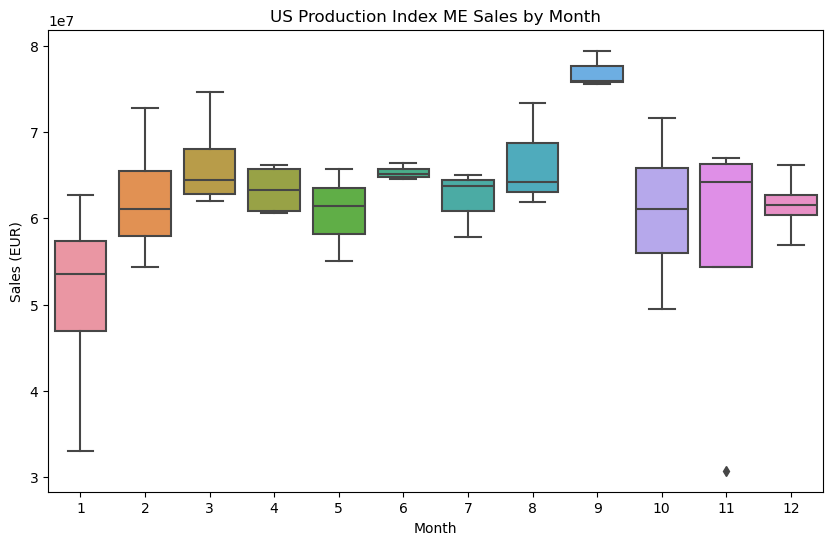

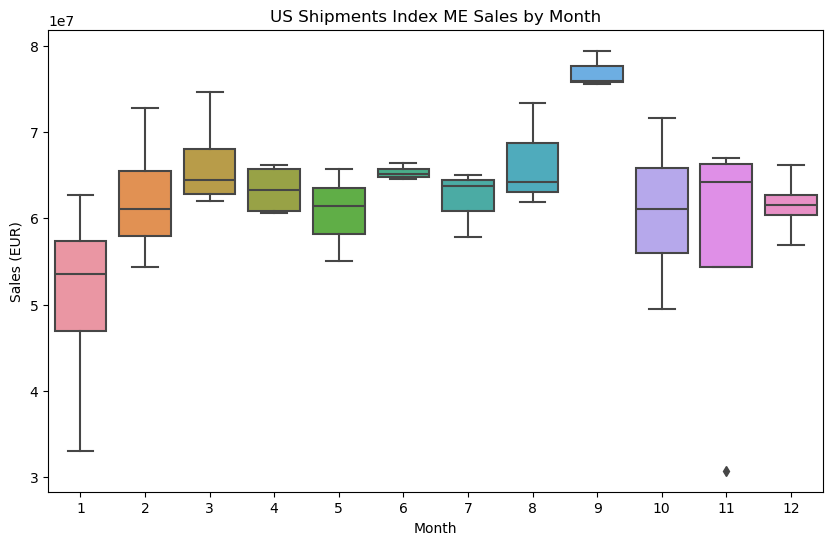

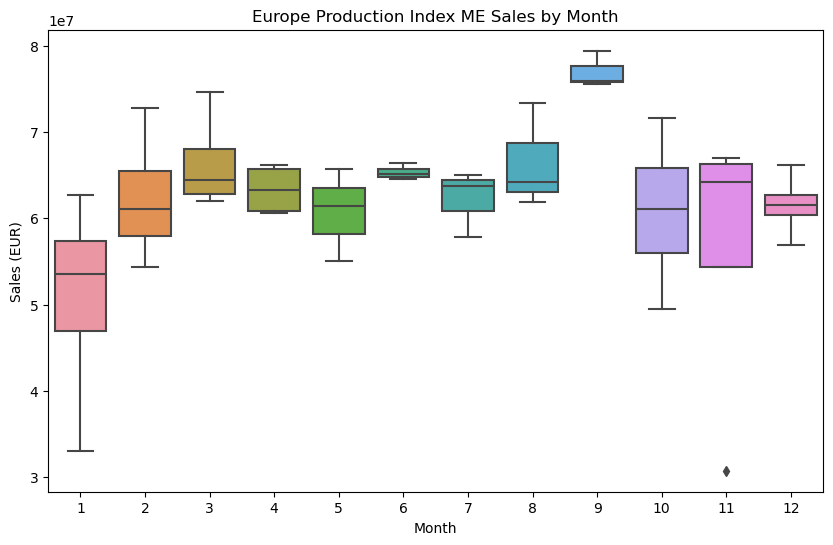

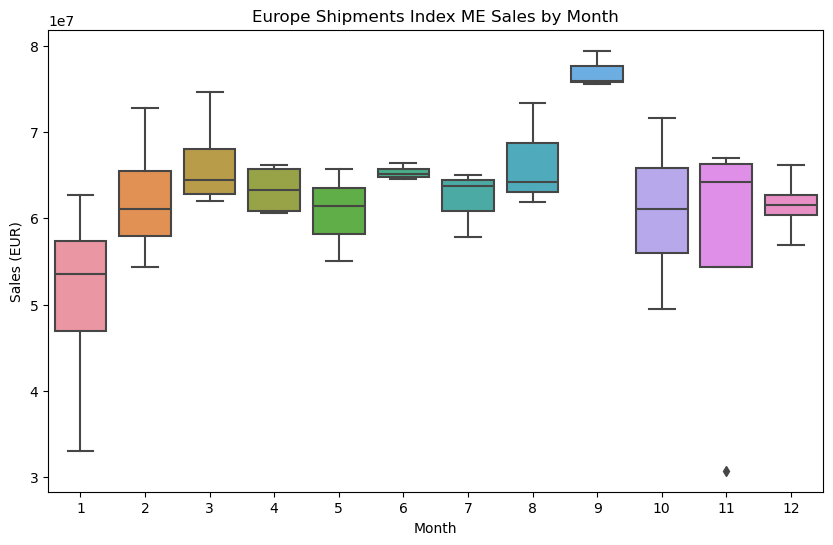

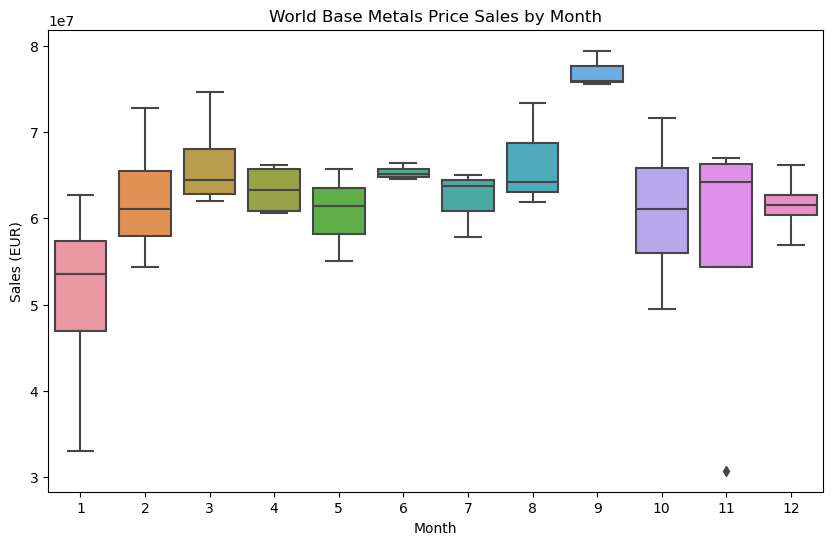

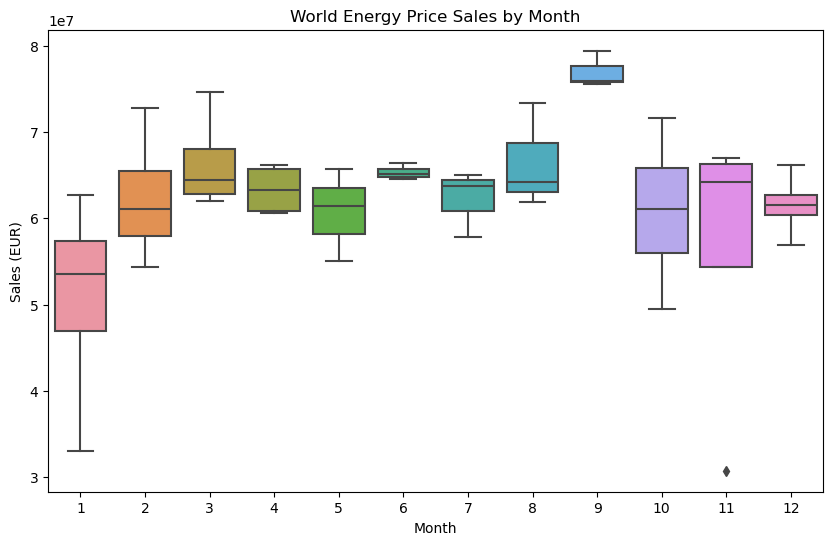

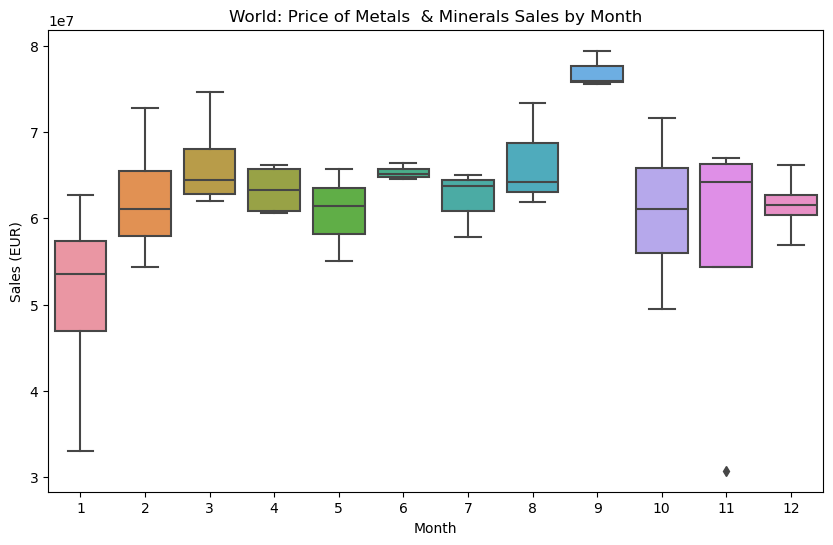

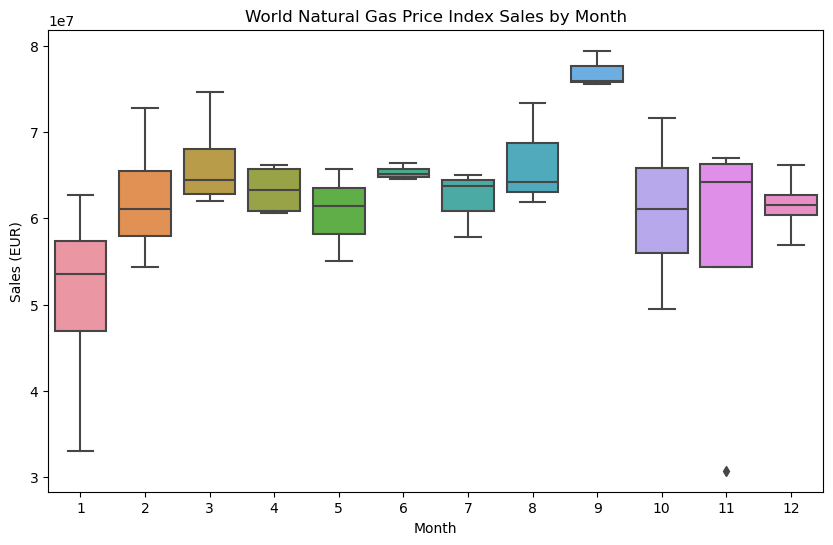

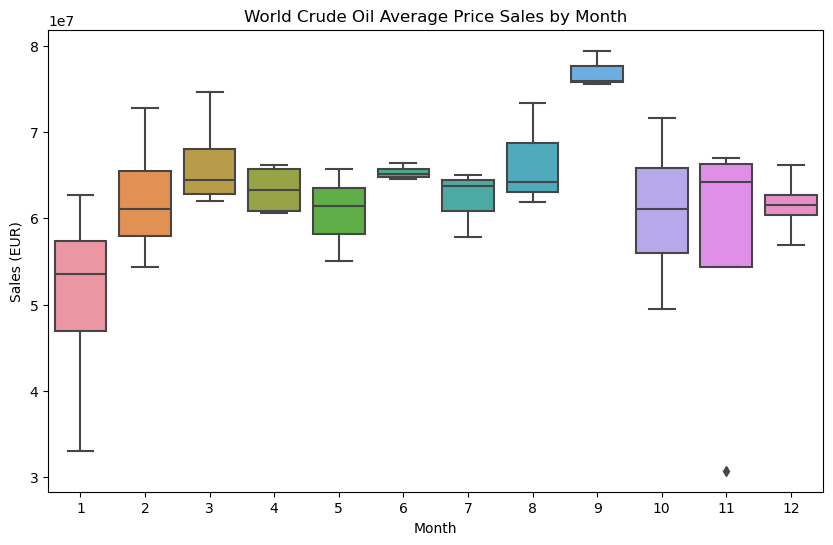

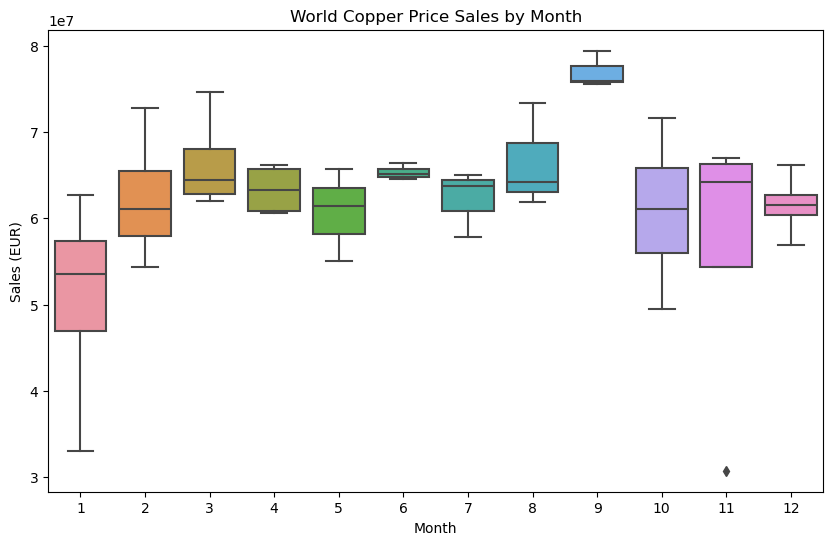

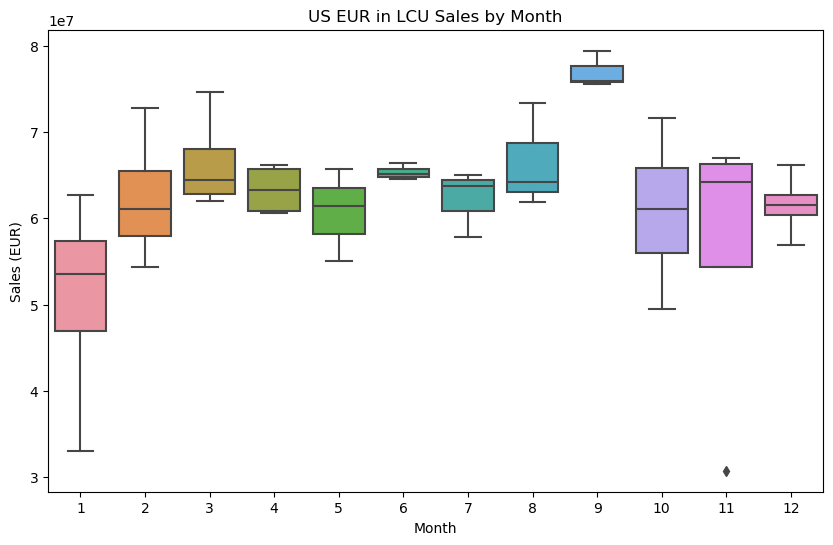

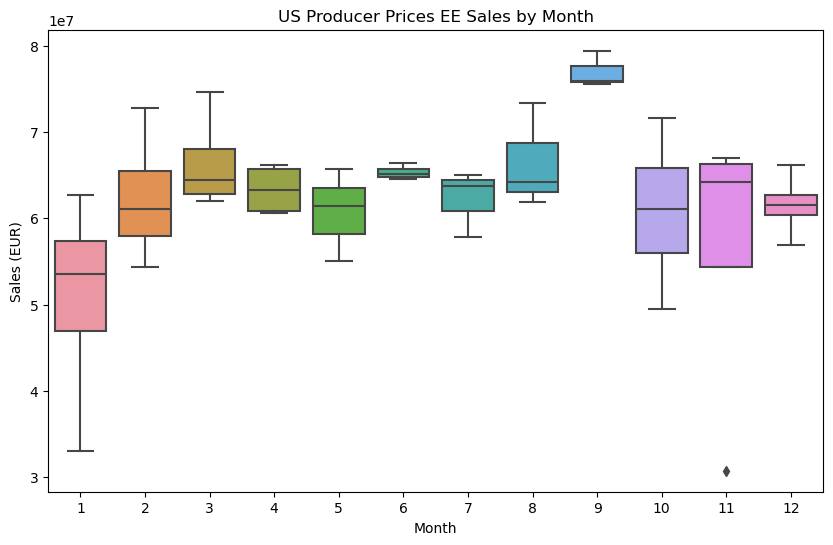

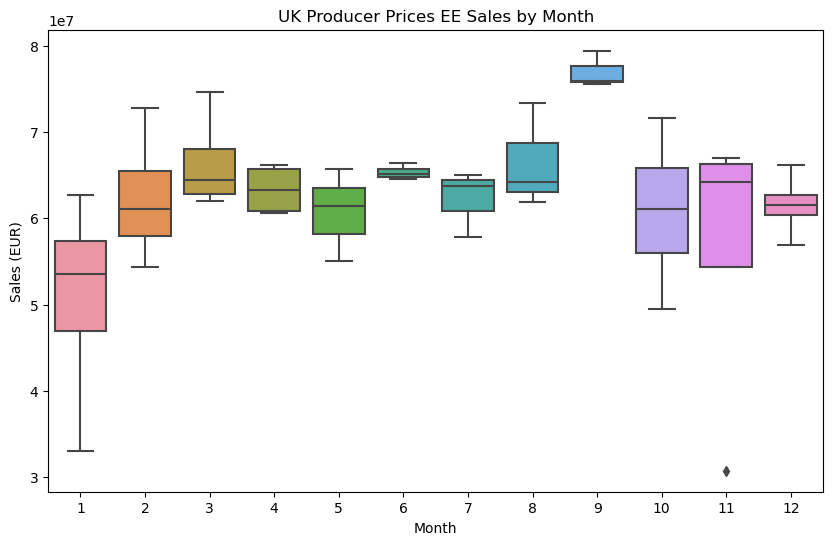

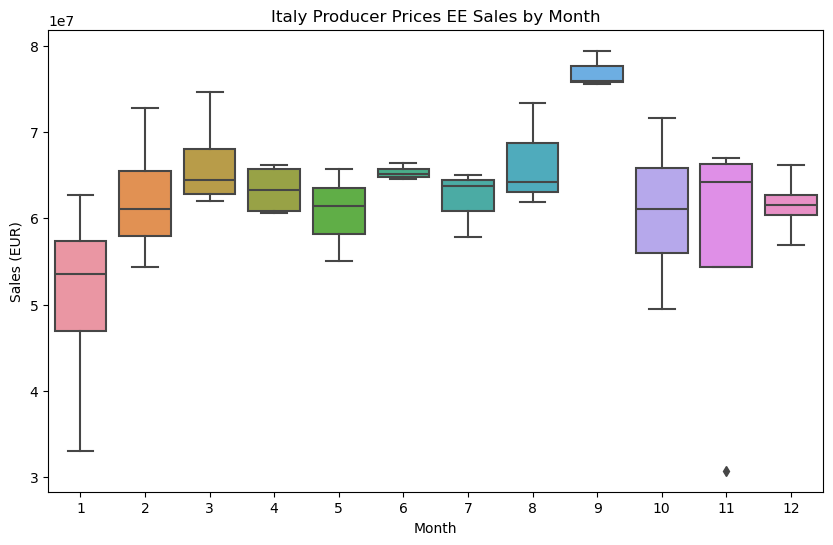

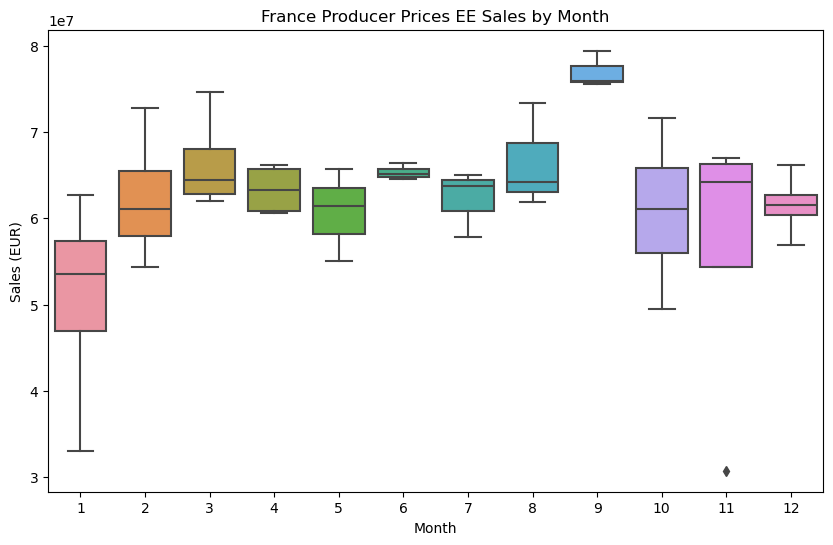

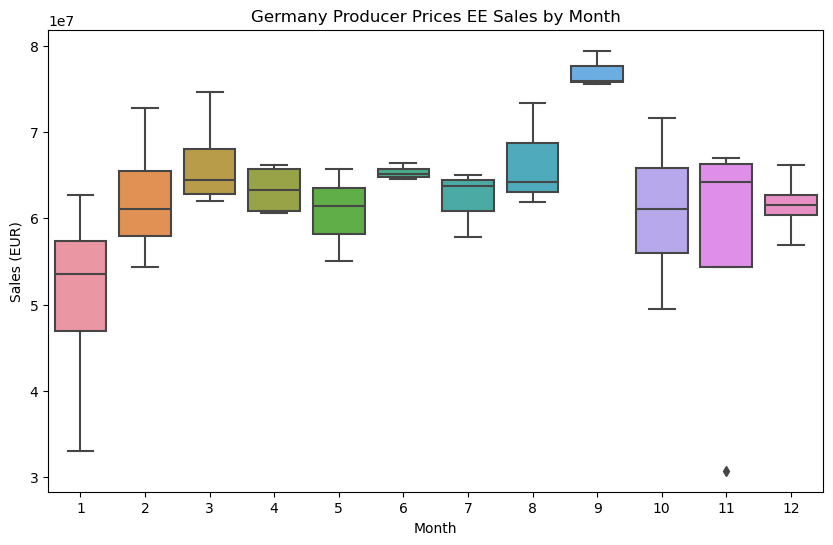

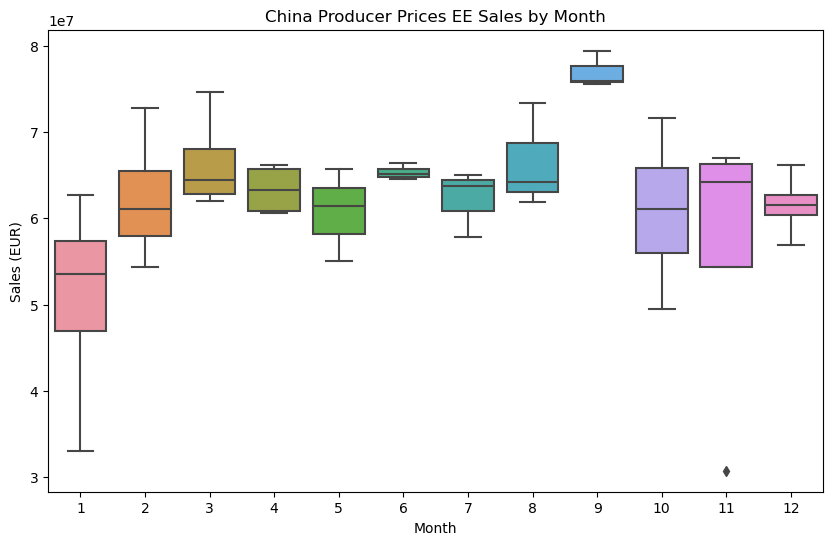

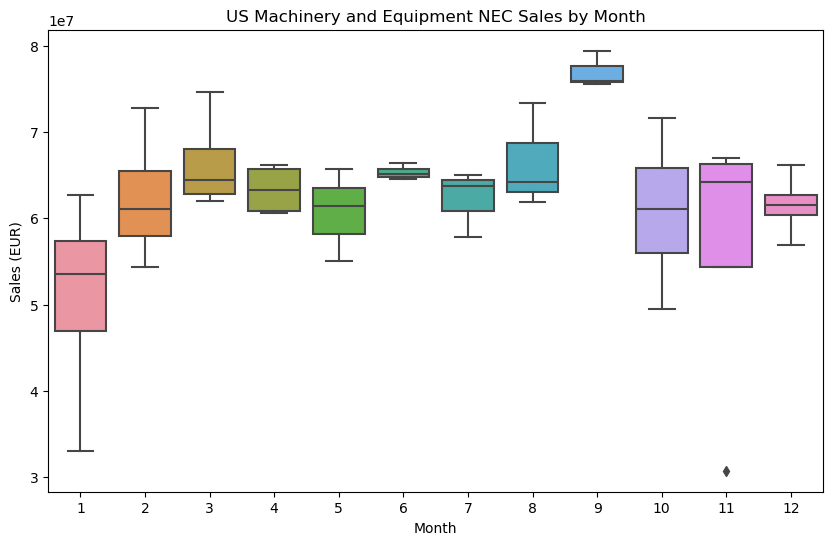

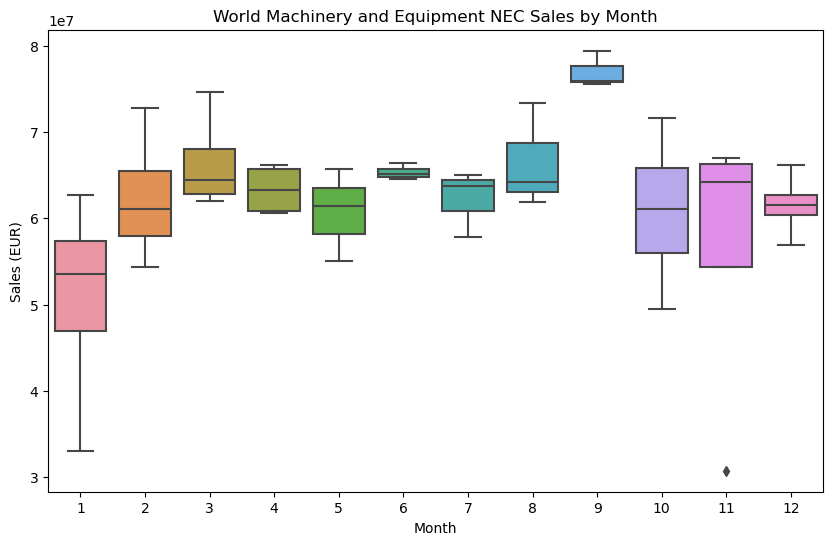

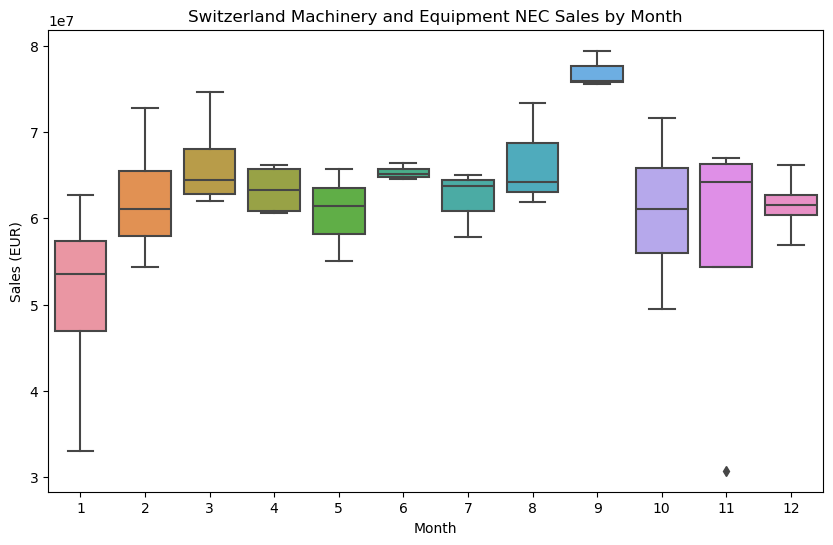

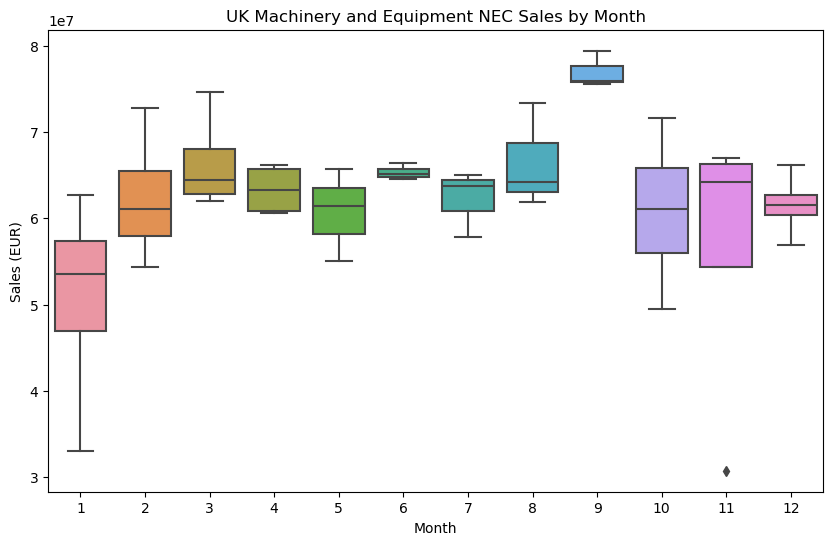

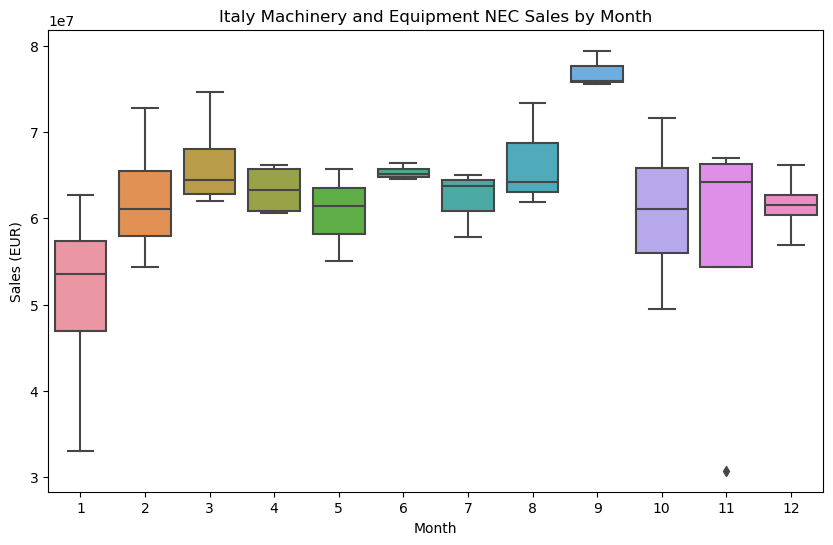

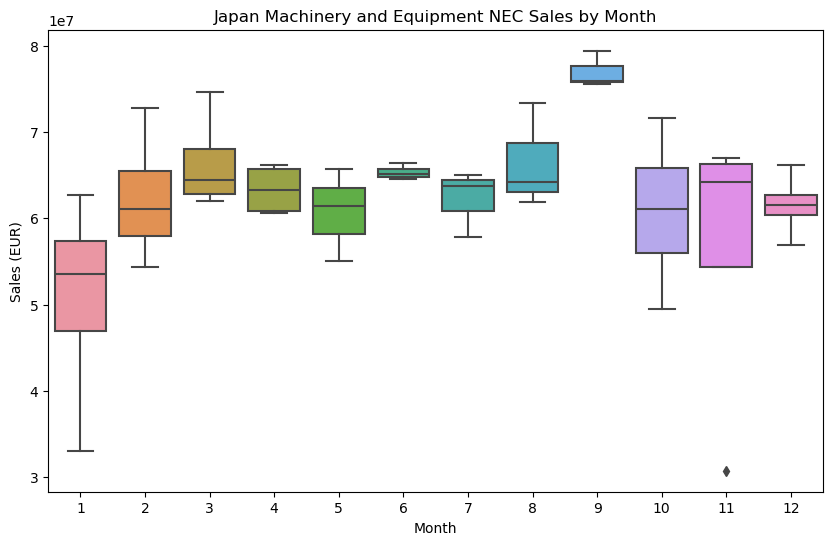

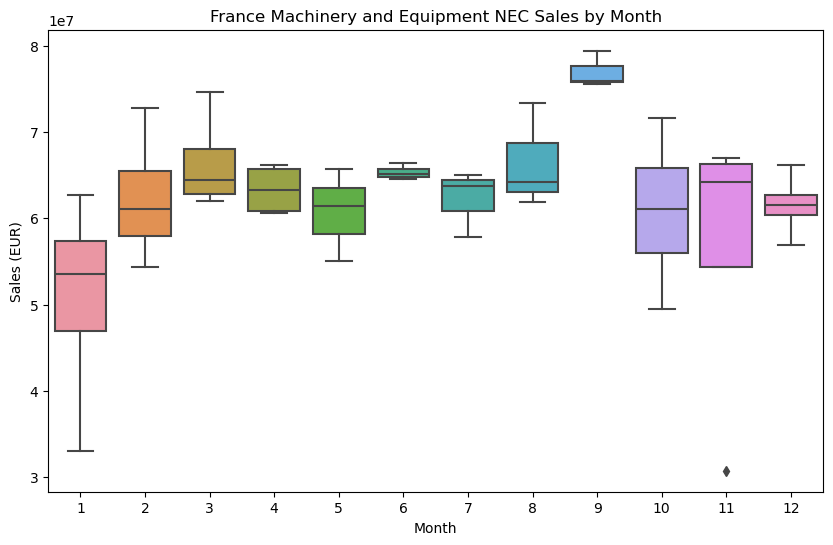

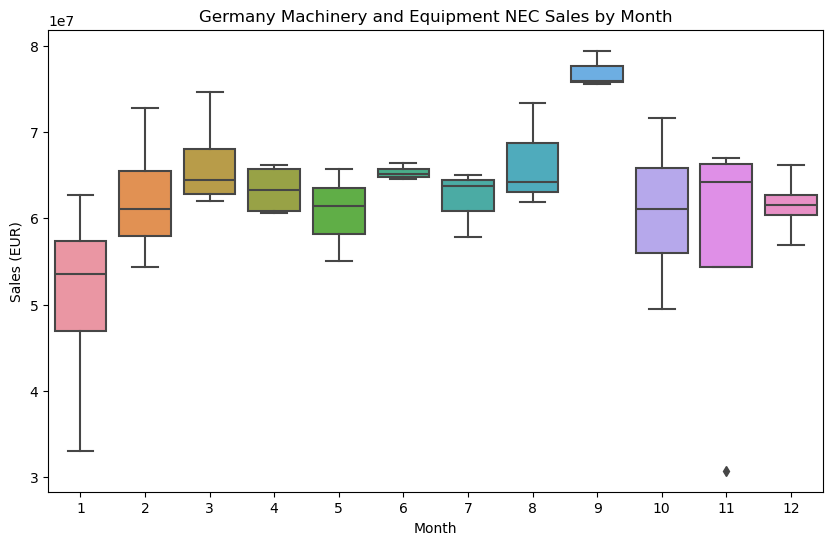

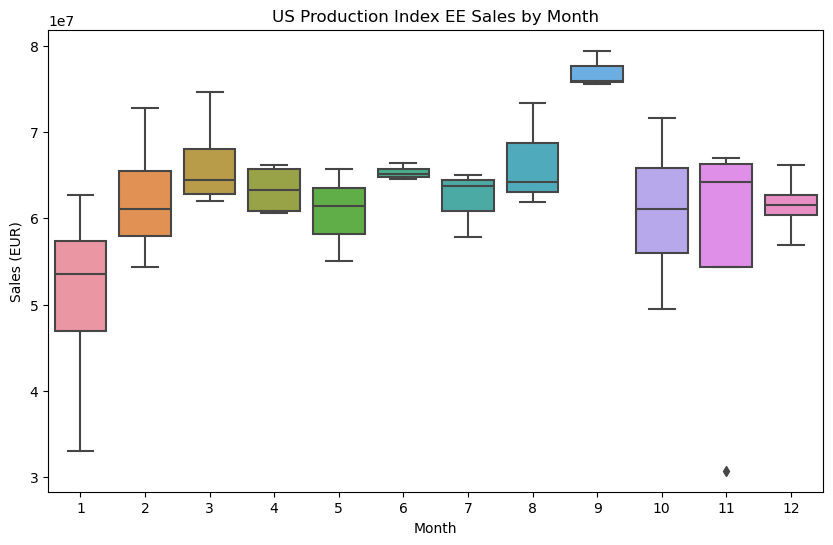

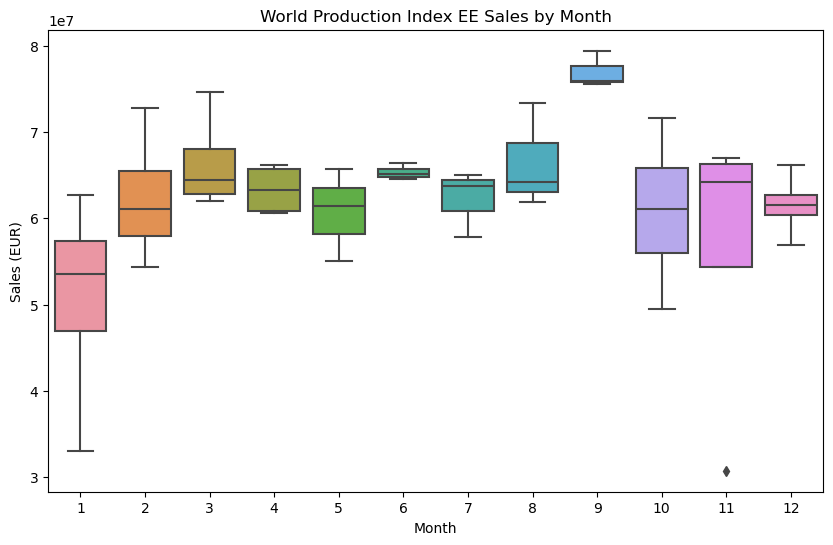

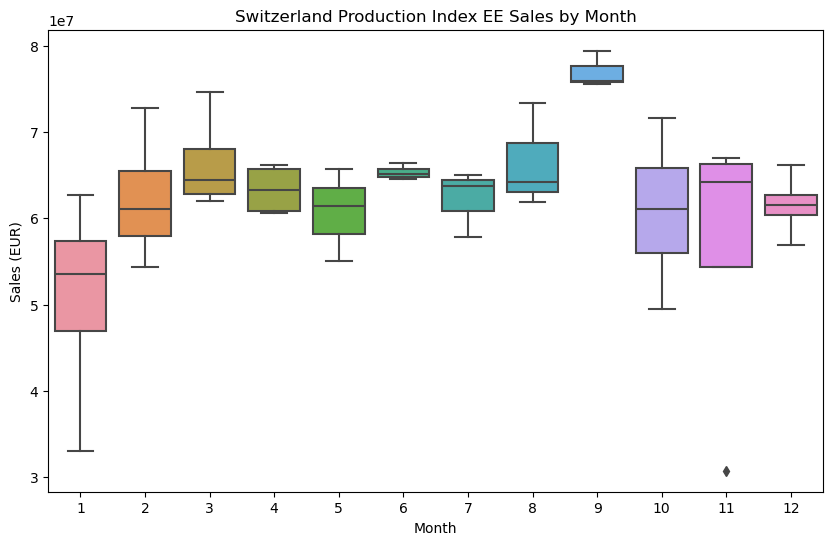

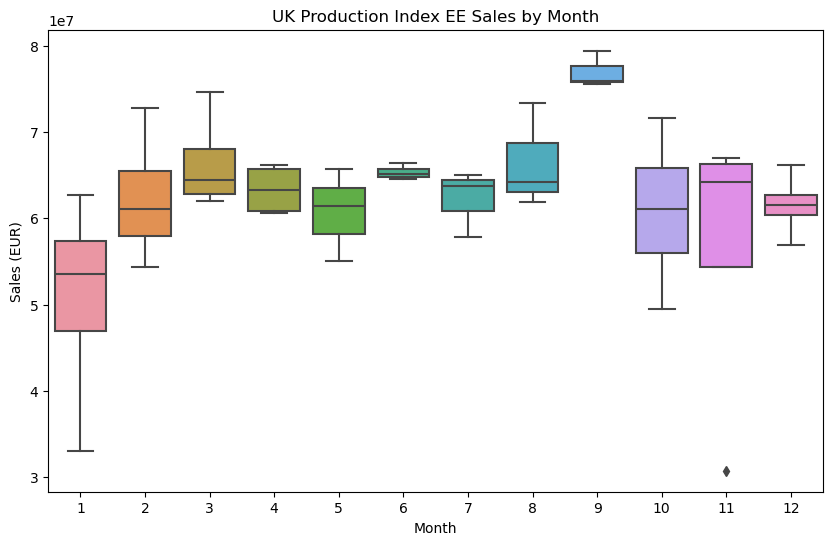

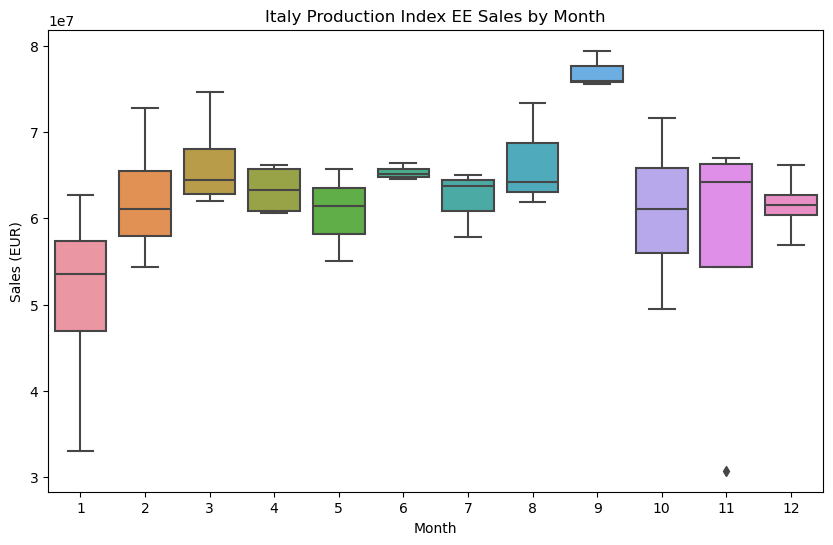

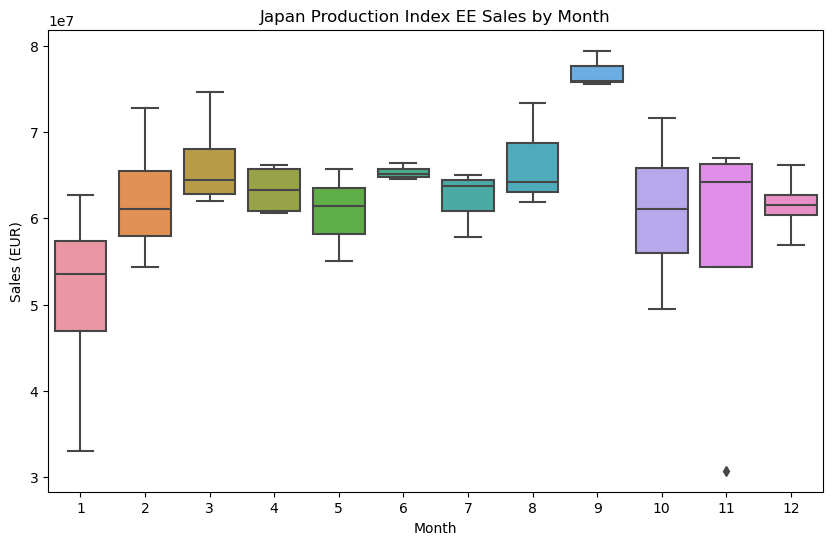

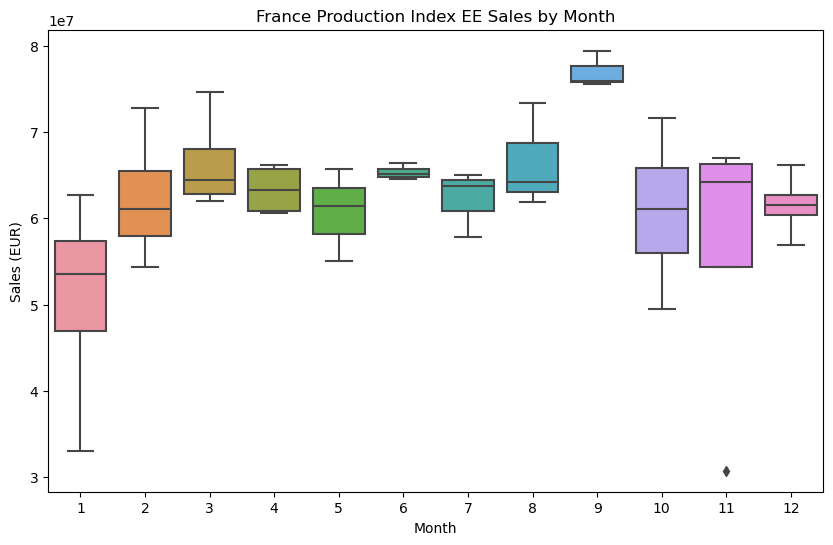

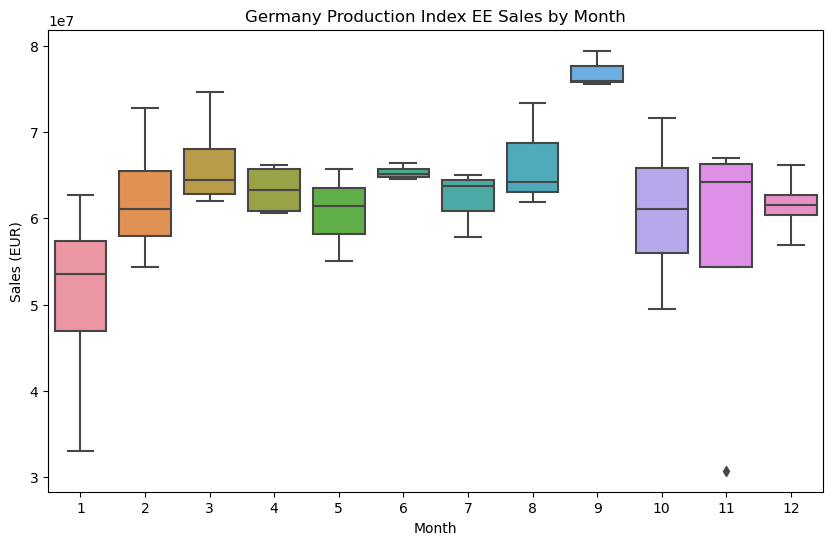

In [71]:
unique_products = [
    'China Production Index ME', 'France Production Index ME', 'France Shipments Index ME', 'Germany Production Index ME', 
    'Germany Shipments Index ME', 'Italy Production Index ME', 'Italy Shipments Index ME', 'Japan Production Index ME', 'Japan Shipments Index ME',
    'Switzerland Production Index ME', 'Switzerland Shipments Index ME', 'UK Production Index ME', 'UK Shipments Index ME', 
    'US Production Index ME', 'US Shipments Index ME', 'Europe Production Index ME', 'Europe Shipments Index ME', 'World Base Metals Price', 
    'World Energy Price', 'World: Price of Metals  & Minerals', 'World Natural Gas Price Index', 'World Crude Oil Average Price', 
    'World Copper Price', 'US EUR in LCU', 'US Producer Prices EE', 'UK Producer Prices EE', 'Italy Producer Prices EE', 
    'France Producer Prices EE', 'Germany Producer Prices EE', 'China Producer Prices EE','US Machinery and Equipment NEC', 
    'World Machinery and Equipment NEC','Switzerland Machinery and Equipment NEC','UK Machinery and Equipment NEC', 
    'Italy Machinery and Equipment NEC','Japan Machinery and Equipment NEC','France Machinery and Equipment NEC',
    'Germany Machinery and Equipment NEC', 'US Production Index EE','World Production Index EE', 'Switzerland Production Index EE',
    'UK Production Index EE', 'Italy Production Index EE','Japan Production Index EE', 'France Production Index EE', 'Germany Production Index EE',
    'Covid_boolean', 'Year_closure_boolean'
]

for product in unique_products:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=merged_data, x=merged_data['Month'], y=merged_data['Total Sales'])
    plt.title(f'{product} Sales by Month')
    plt.xlabel('Month')
    plt.ylabel('Sales (EUR)')
    plt.show()

#Source: Kaggle

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


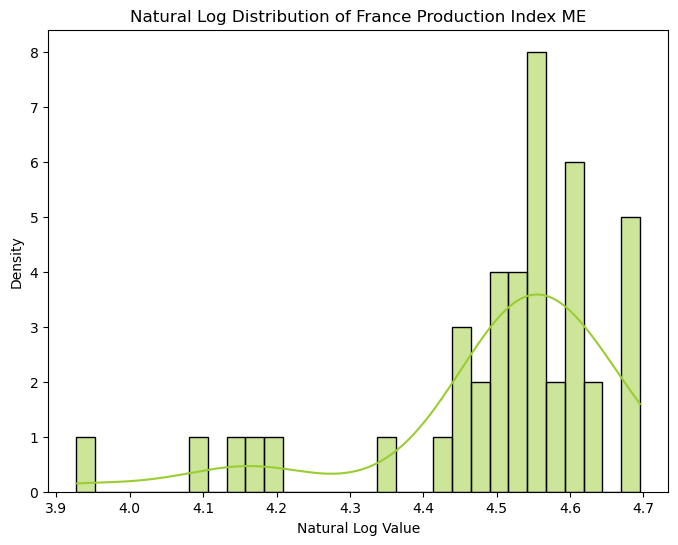

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


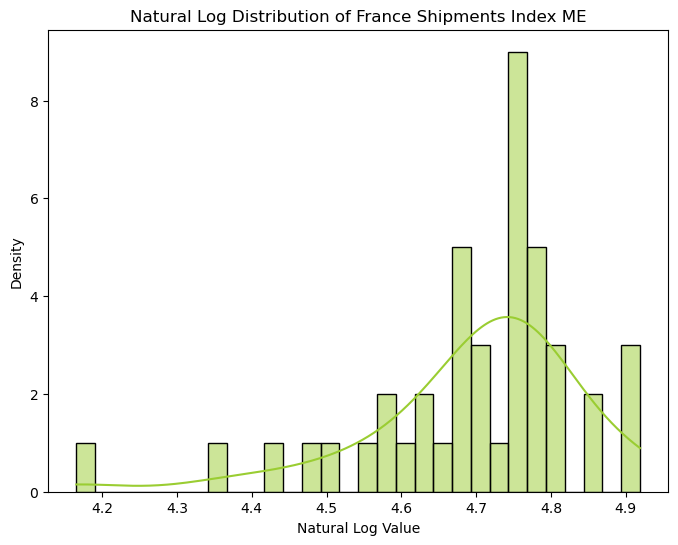

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


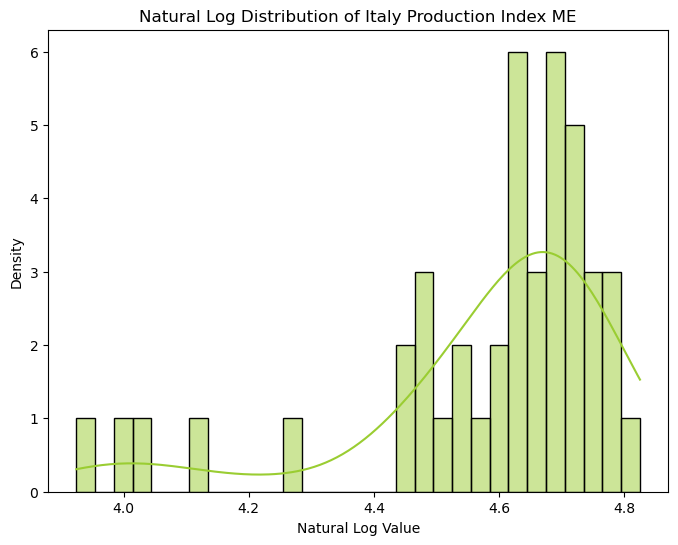

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


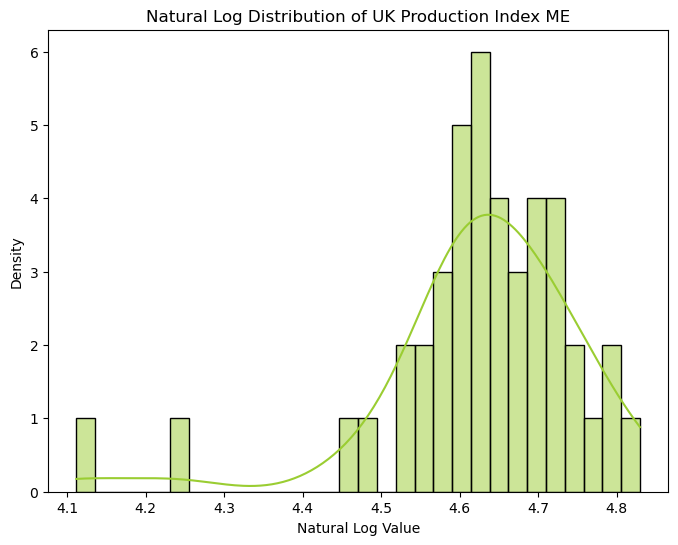

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


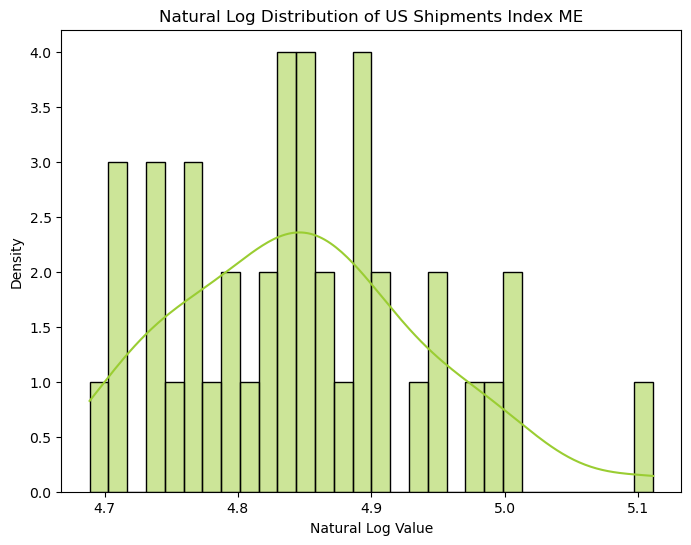

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


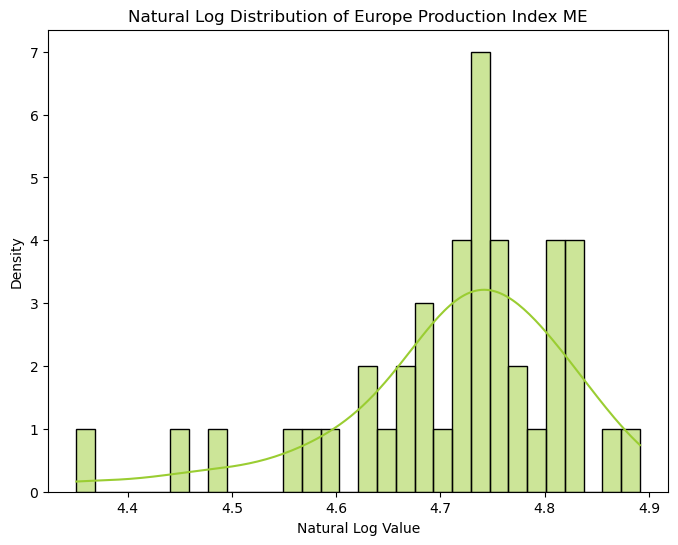

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


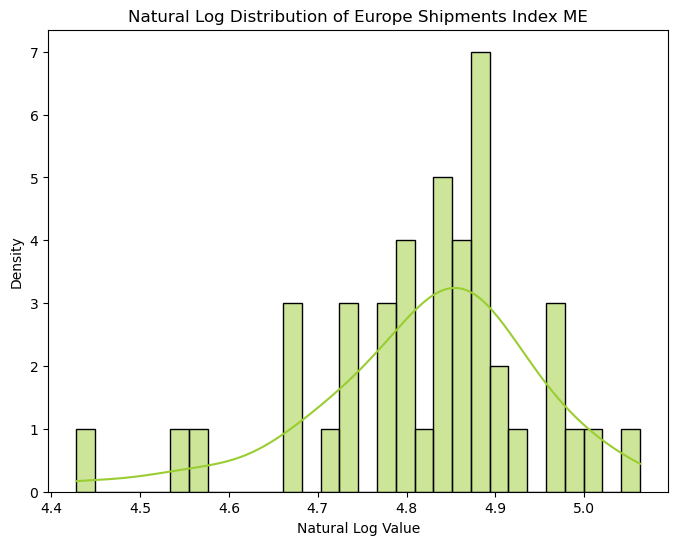

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


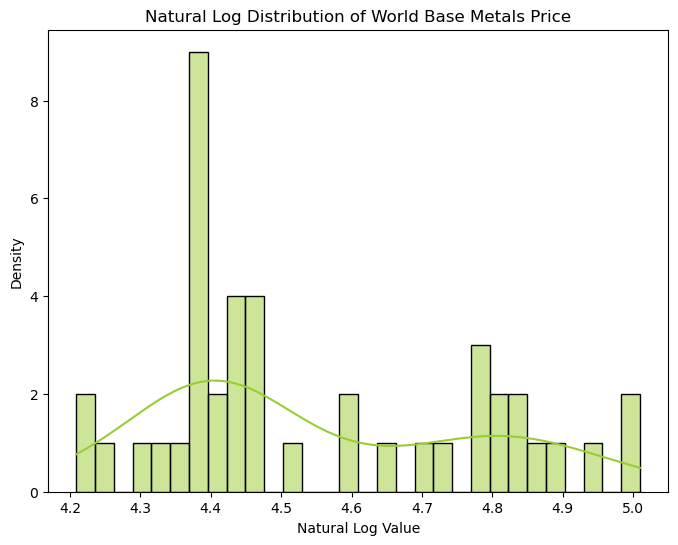

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


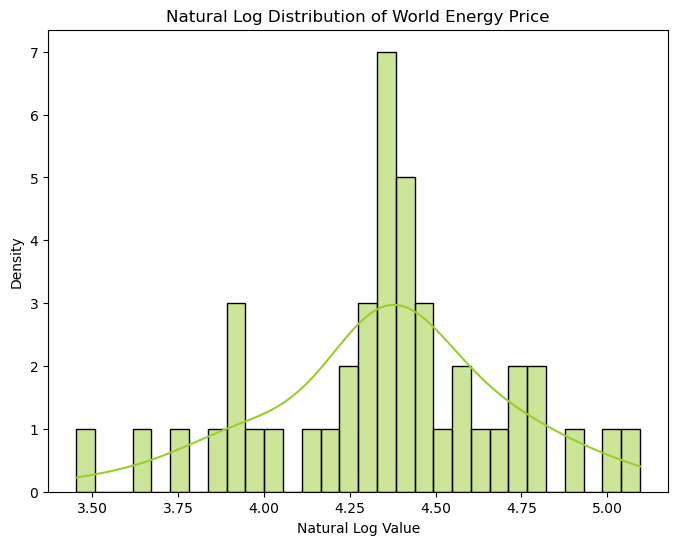

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


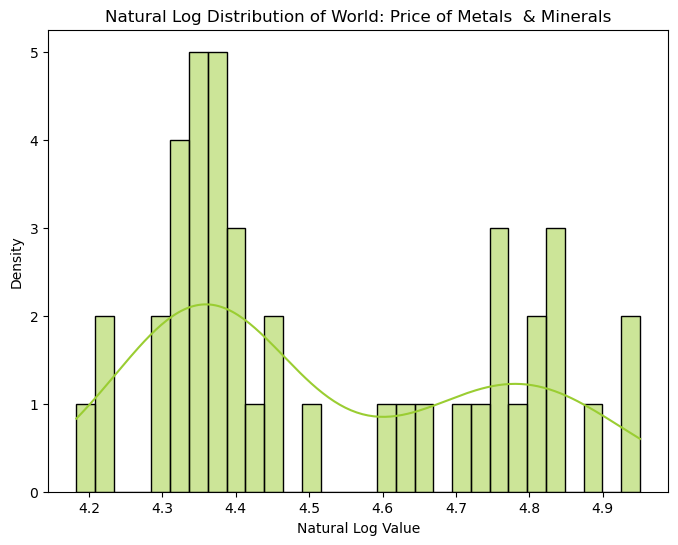

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


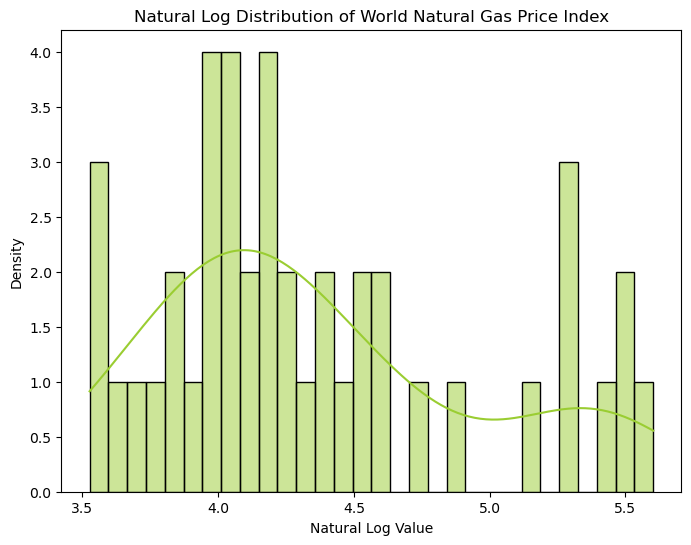

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


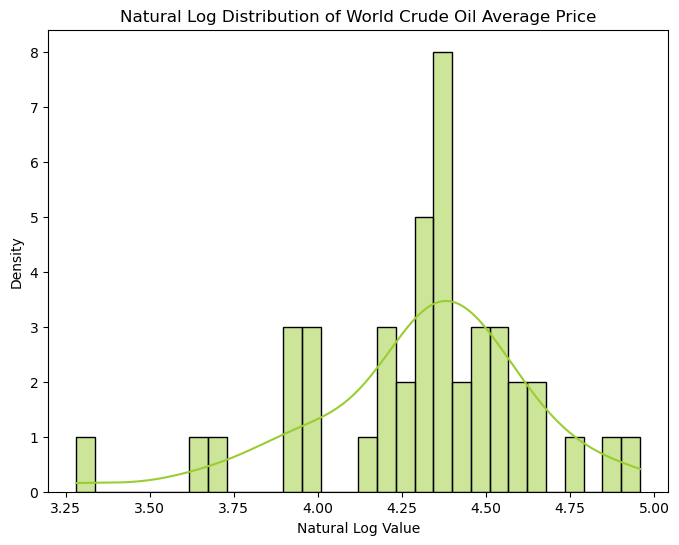

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


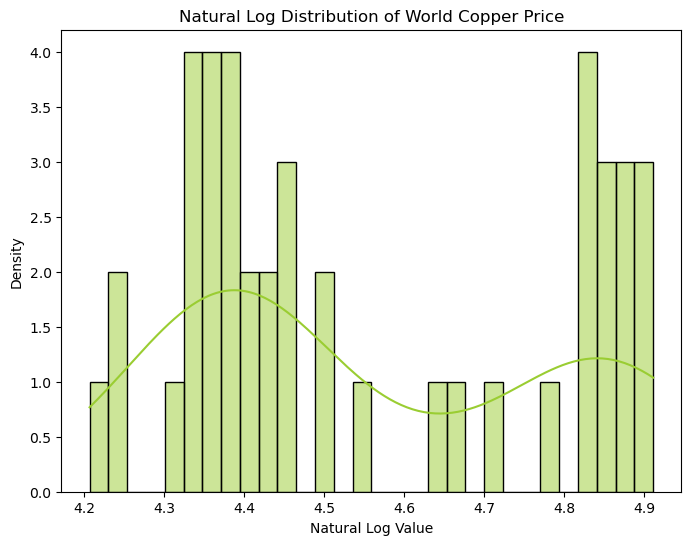

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


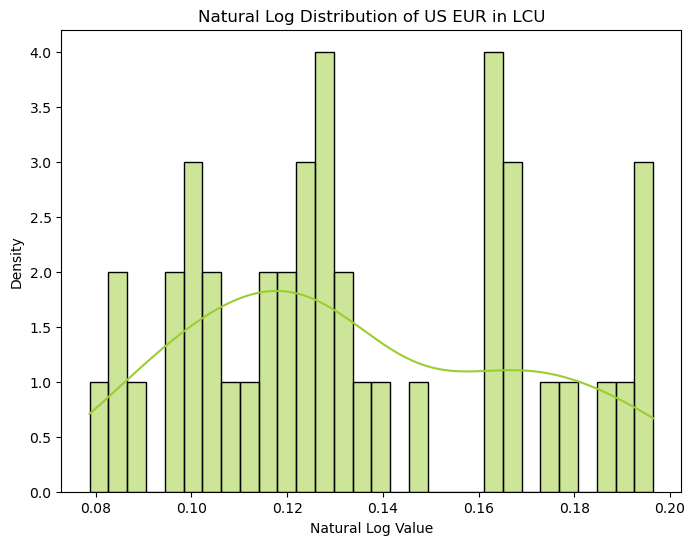

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


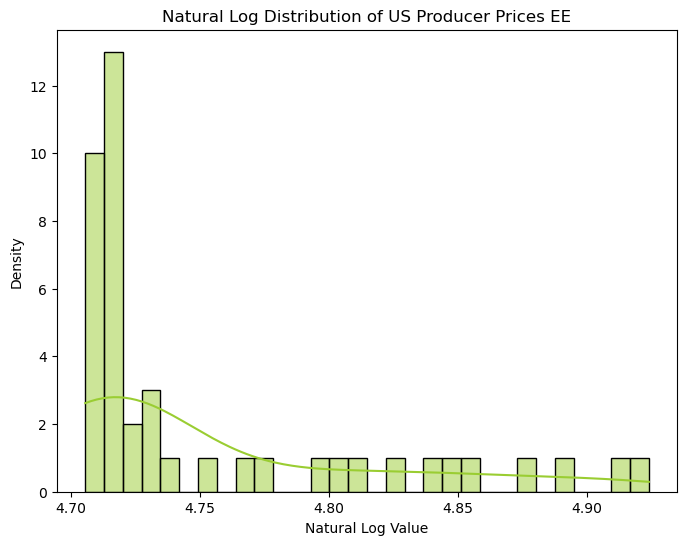

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


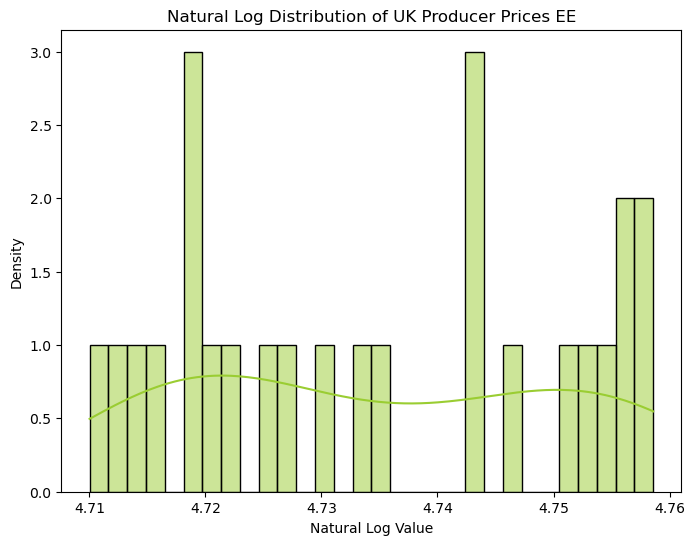

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


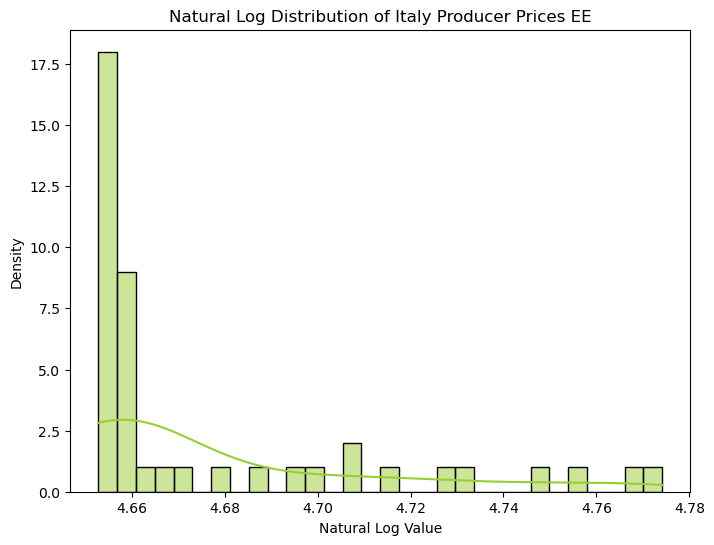

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


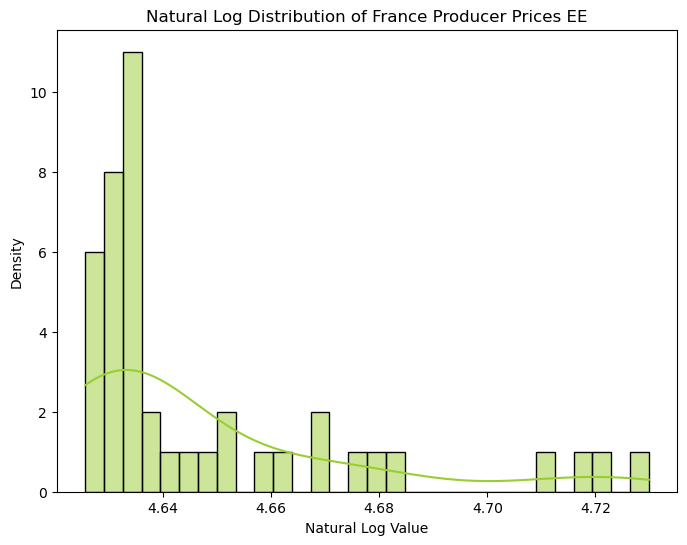

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


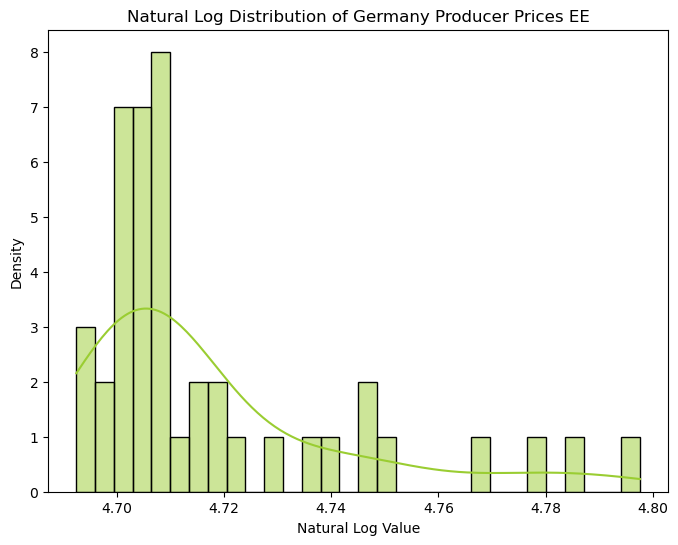

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


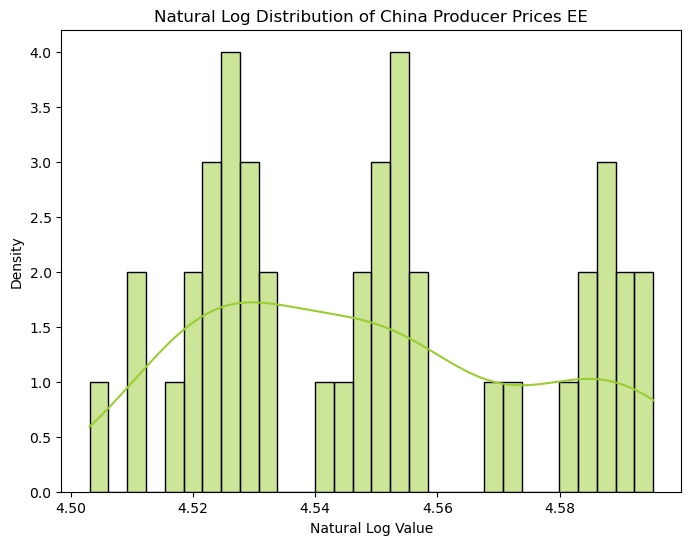

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


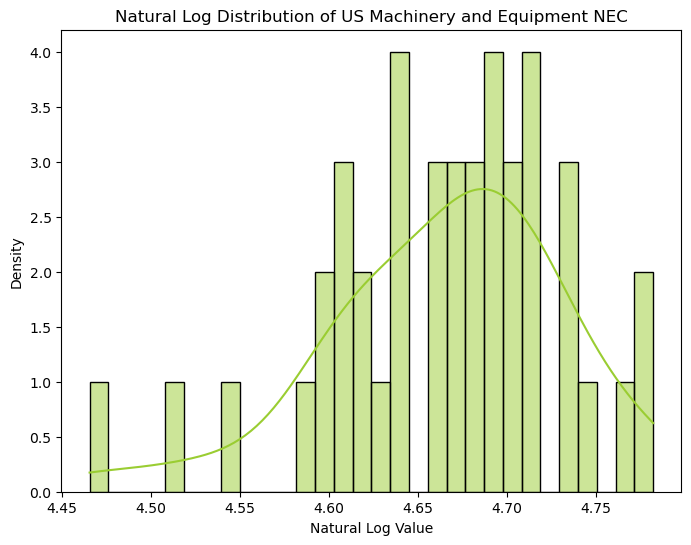

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


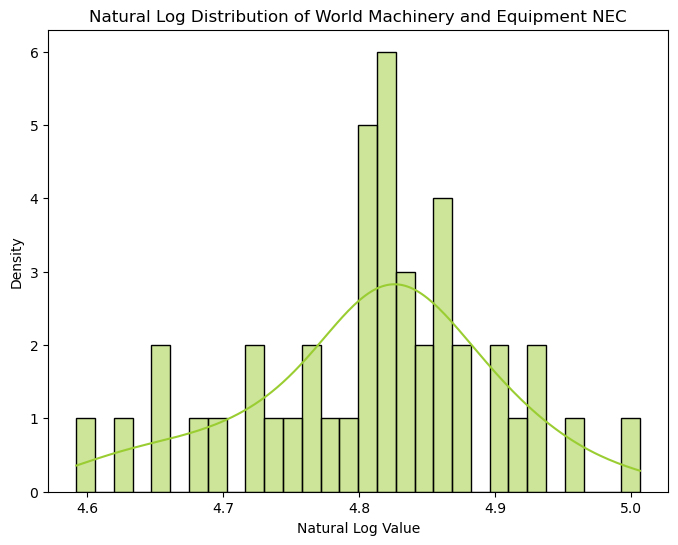

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


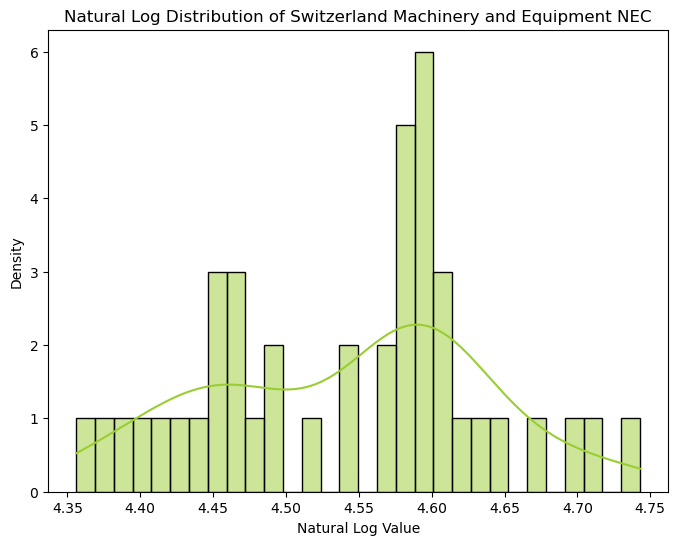

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


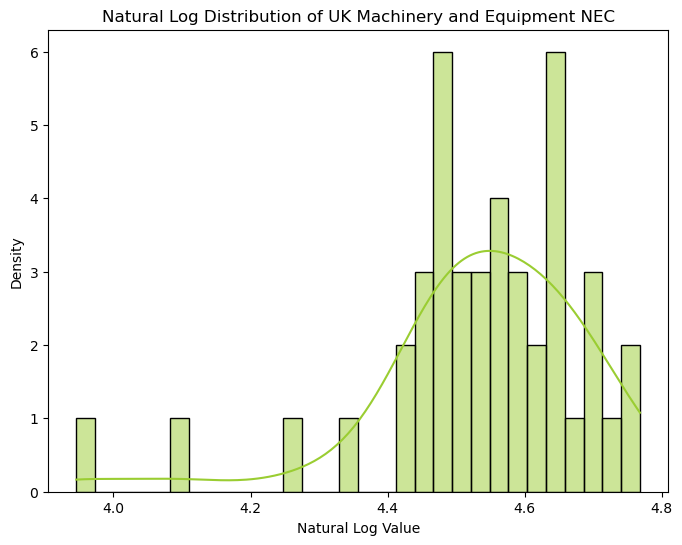

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


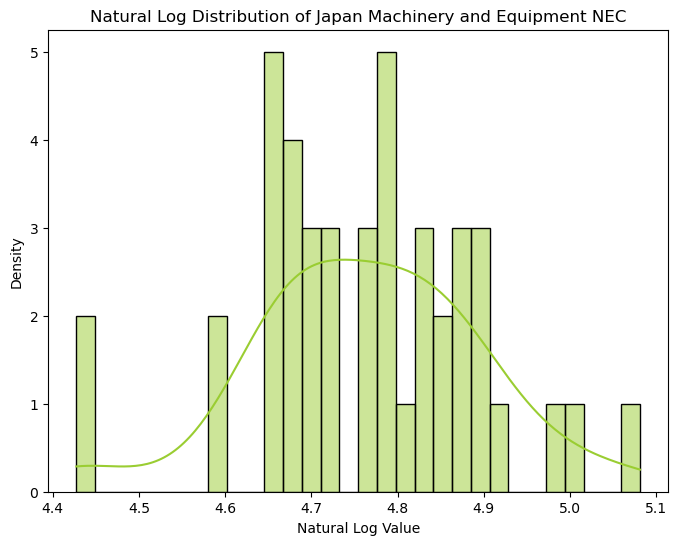

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


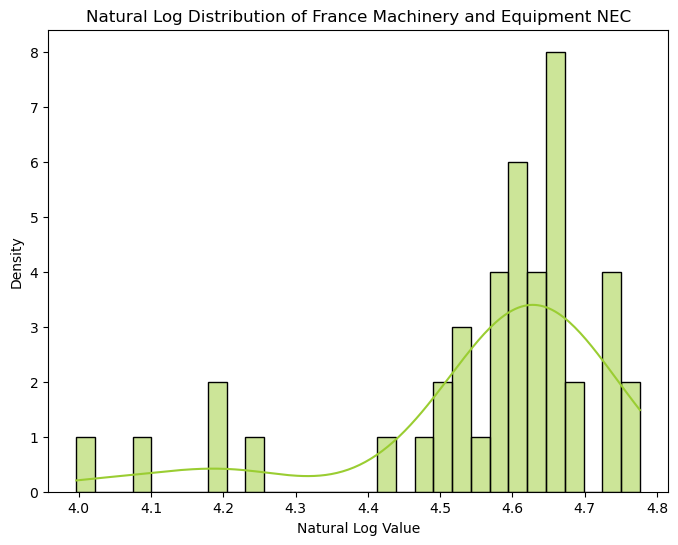

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


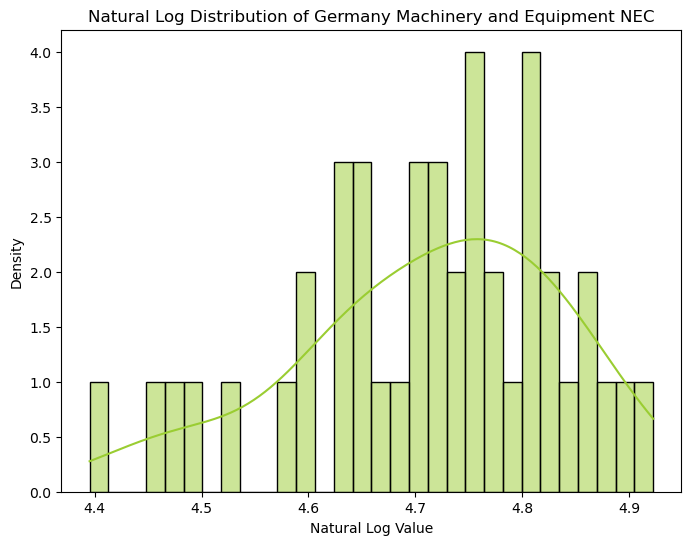

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


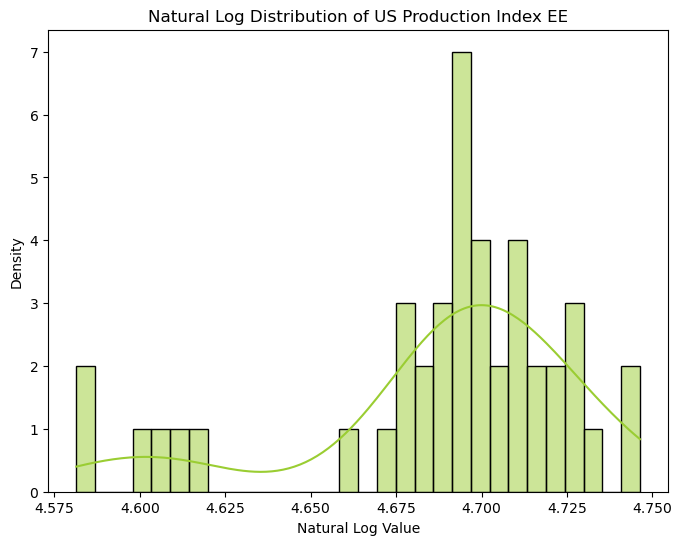

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


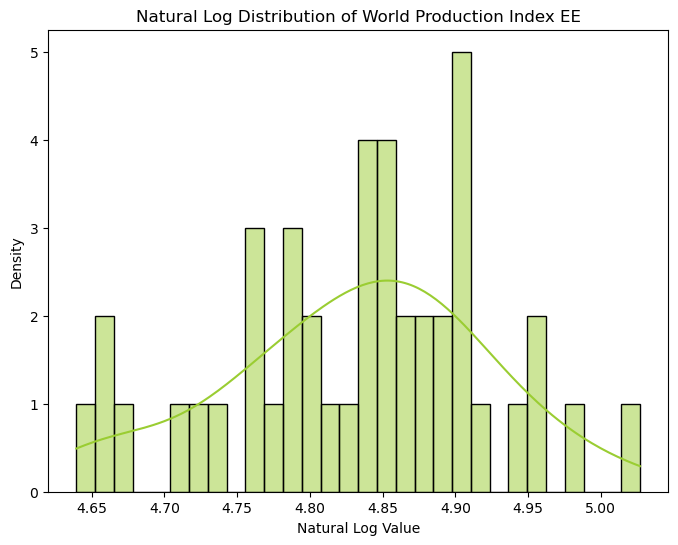

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


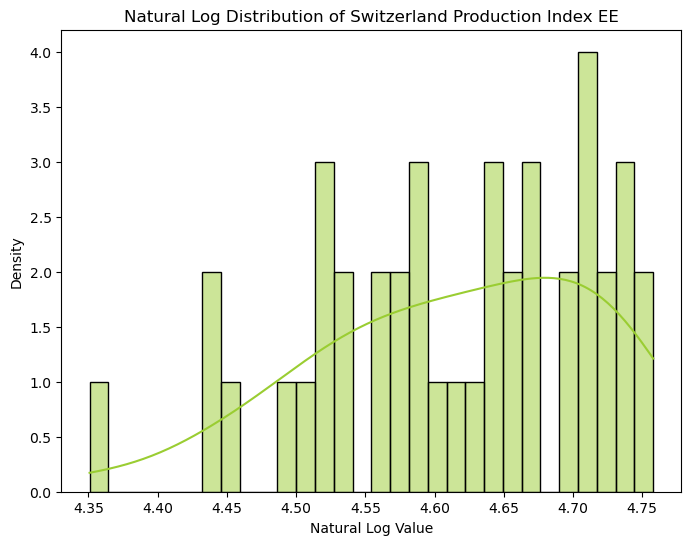

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


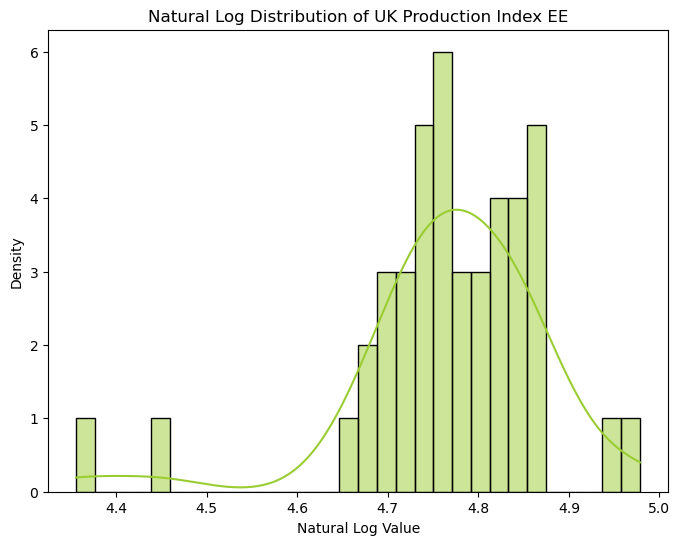

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


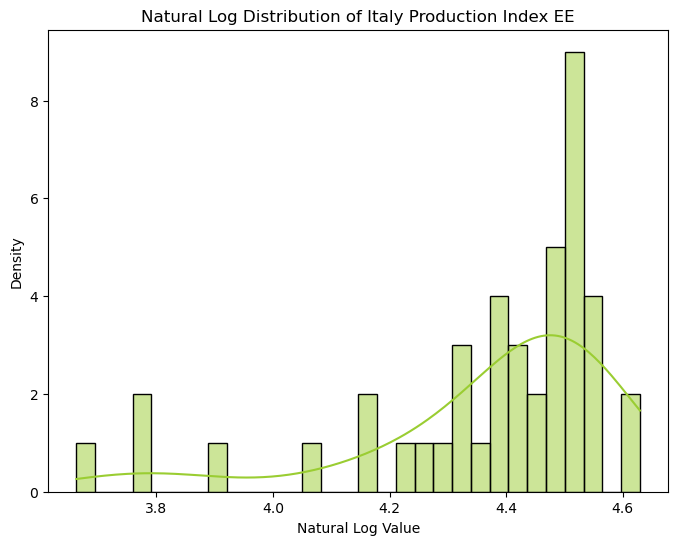

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


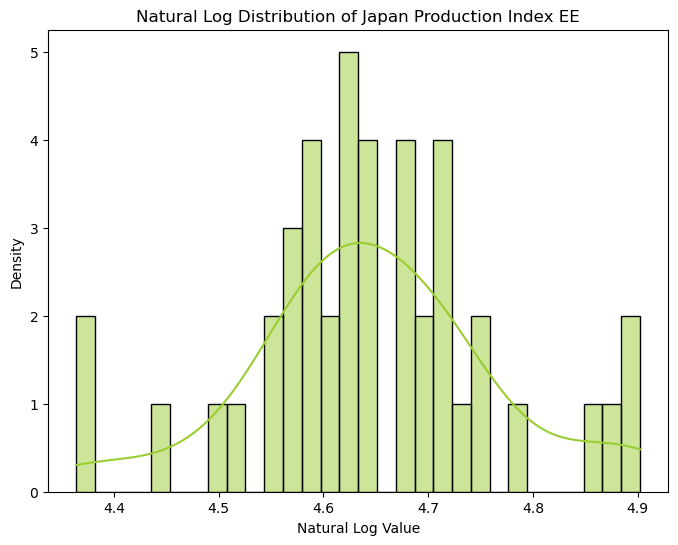

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


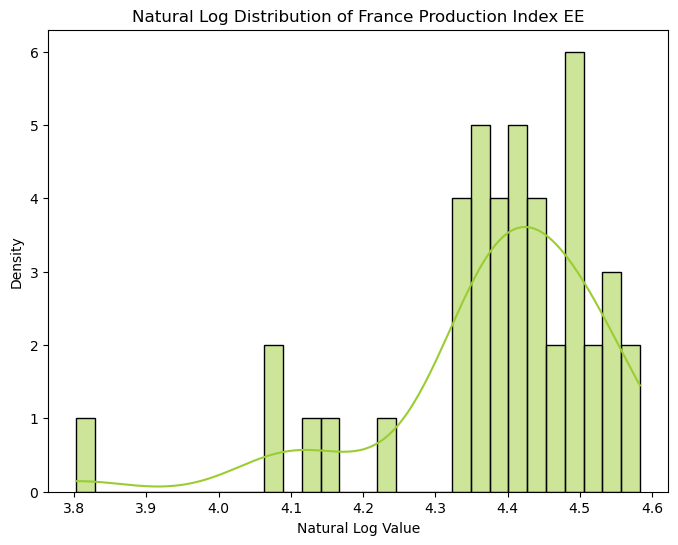

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


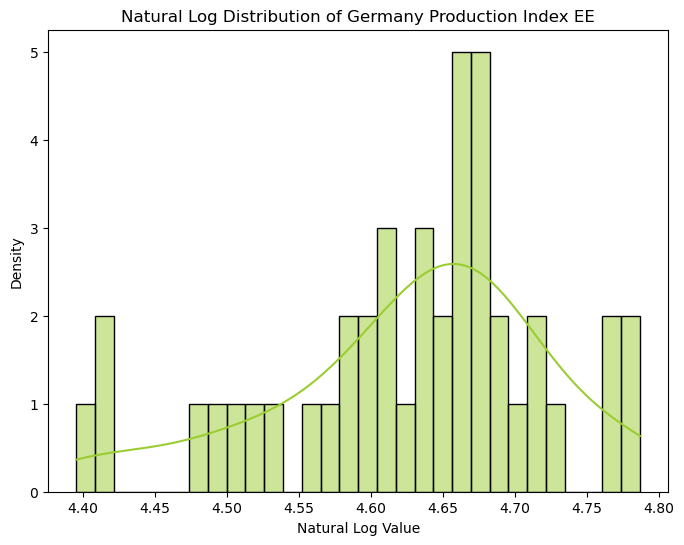

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_40756\3186762242.py:12: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(merged_data[column].values), kde=True, color="yellowgreen", bins=30)
c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


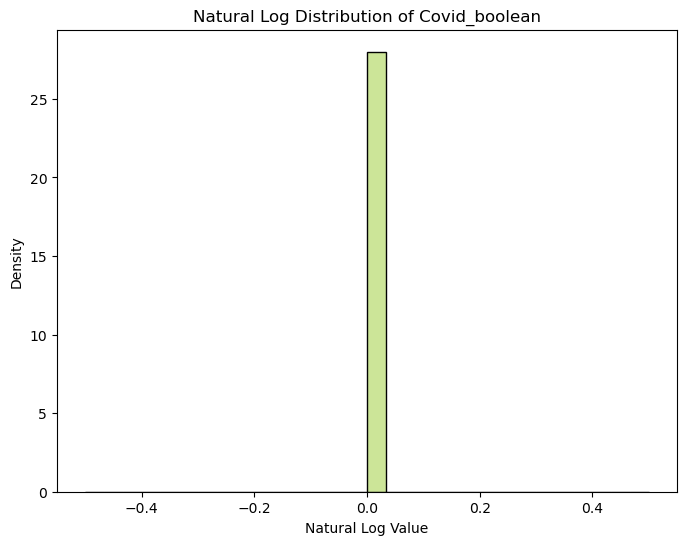

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_40756\3186762242.py:12: RuntimeWarning: divide by zero encountered in log
  sns.histplot(np.log(merged_data[column].values), kde=True, color="yellowgreen", bins=30)
c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


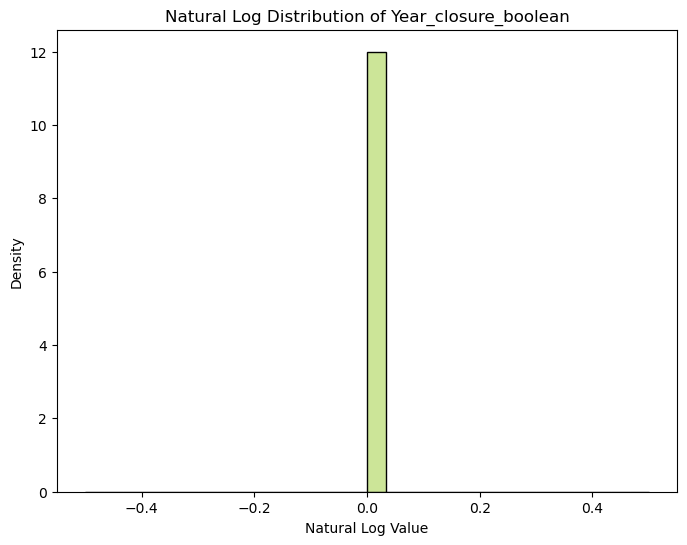

In [72]:
# Exclude specific columns
exclude_columns = ["Month", "Year", "Total Sales"]

# Iterate over each column
for column in merged_data.columns:
    # Check if the column contains numeric data and is not in the exclude list
    if np.issubdtype(merged_data[column].dtype, np.number) and column not in exclude_columns:
        # Create a new figure and axis for each column
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # Plot the natural logarithm distribution of the column
        sns.histplot(np.log(merged_data[column].values), kde=True, color="yellowgreen", bins=30)
        
        # Set title and labels
        ax.set_title(f"Natural Log Distribution of {column}")
        ax.set_xlabel("Natural Log Value")
        ax.set_ylabel("Density")
        
        # Show plot
        plt.show()

#Source: Kaggle

In [73]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("Greens")
    ax = sns.lineplot(x=X[freq], 
                      y=X[y],
                      ax=ax, 
                      hue=X[period],
                      palette=palette, 
                      legend=False)
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(name, 
                    xy=(1, y_), 
                    xytext=(6, 0), 
                    color=line.get_color(), 
                    xycoords=ax.get_yaxis_transform(), 
                    textcoords="offset points", 
                    size=14, 
                    va="center")
    return ax

#Source: Kaggle

In [74]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(ts, fs=fs, detrend=detrend, window="boxcar", scaling='spectrum')
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(["Annual (1)", "Semiannual (2)", "Quarterly (4)", 
                        "Bimonthly (6)", "Monthly (12)", "Biweekly (26)", 
                        "Weekly (52)", "Semiweekly (104)"], rotation=30)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

#Source: Kaggle

In [75]:
def grouped(df, key, freq, col):
    """ GROUP DATA WITH CERTAIN FREQUENCY """
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

#Source: Kaggle

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


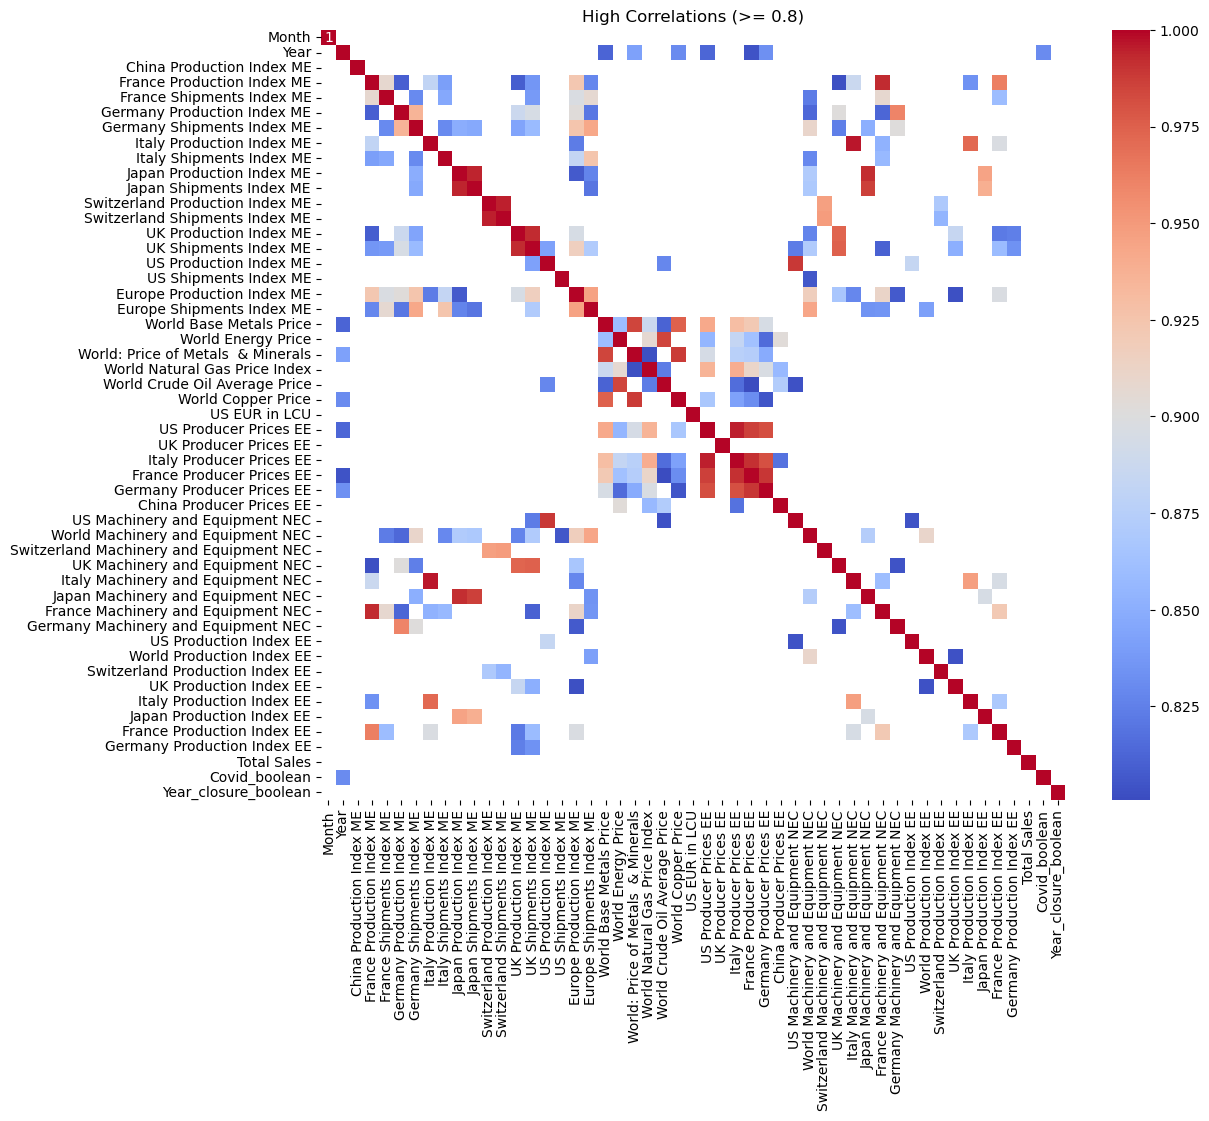

In [76]:
# correlation matrix between market variables and sales
correlation_matrix = merged_data.corr()

# Filter correlations higher than 0.8
high_correlations = correlation_matrix[correlation_matrix > 0.8]

# Visualize high correlations using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(high_correlations, annot=True, cmap='coolwarm')
plt.title('High Correlations (>= 0.8)')
plt.show()

#Source: ChatGPT

Overall, we can say that production and shipment index are highly correlated, meaning data when the the production index rises the shipment index will rise too. Since we already drop shipment index of China, it was already an indication that something else was happening besides a random mistake. Therefore, we will drop all shipment indexes.

Also, due to exportations, is normal to see that the production index are correlated between countries.

Moreover, is interesting to not that the France, Germany and US producer prices are highly correlated with the month (probably, their prices vary more on a monthy basis). Also, US plays a huge role on setting other countries producer prices.

In [77]:
merged_data = merged_data.drop(merged_data.filter(regex='.*Shipment.*').columns, axis=1)

#Source: ChatGPT

c:\Users\Utilizador\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


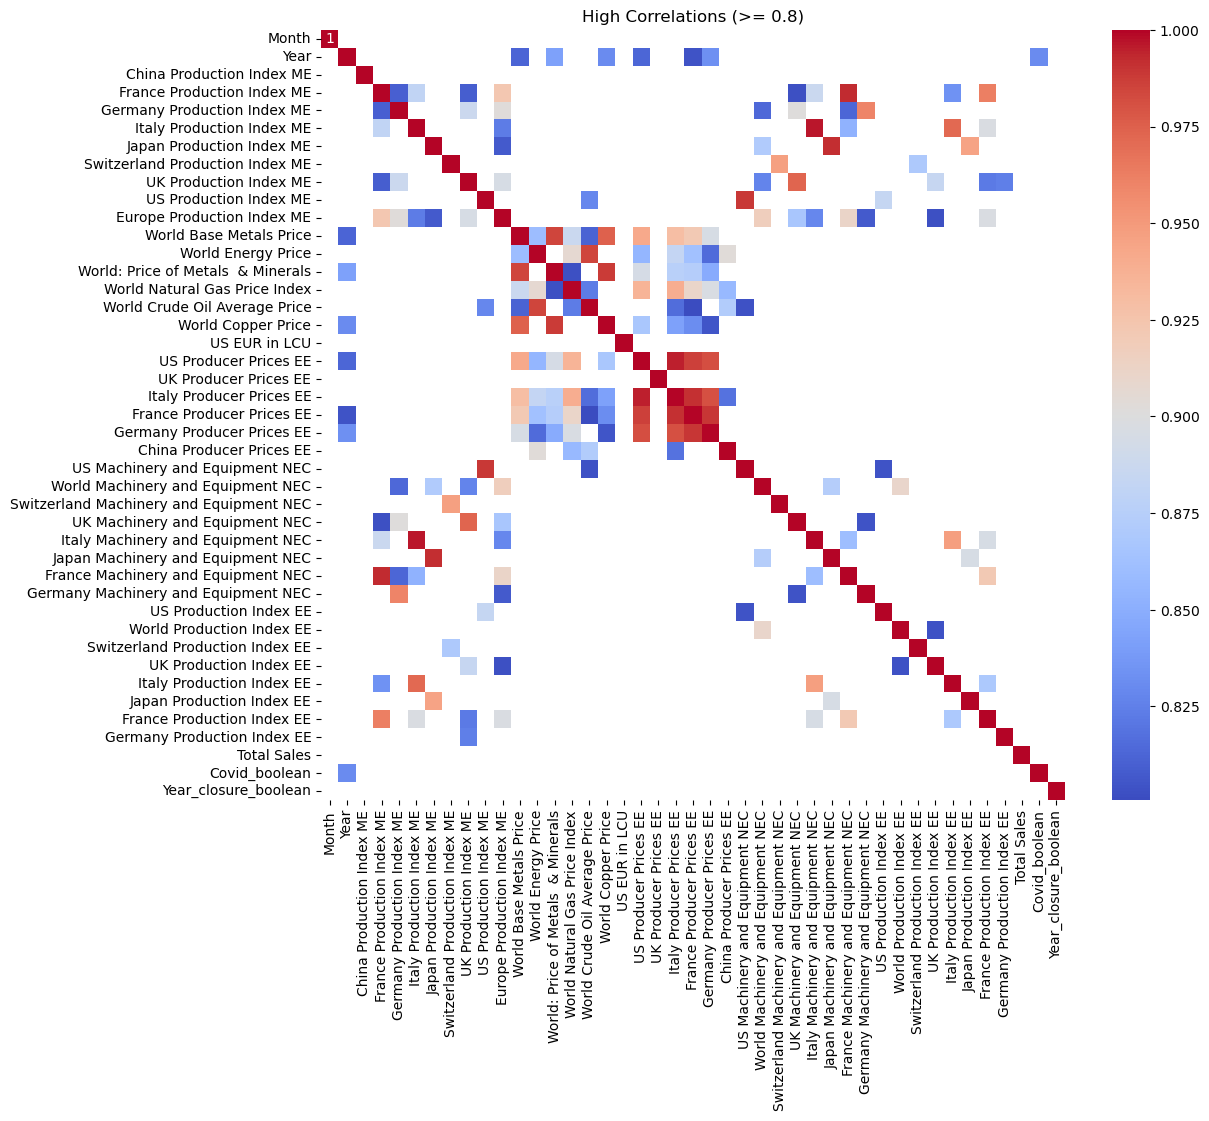

In [78]:
# correlation matrix between market variables and sales
correlation_matrix = merged_data.corr()

# Filter correlations higher than 0.8
high_correlations = correlation_matrix[correlation_matrix > 0.8]

# Visualize high correlations using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(high_correlations, annot=True, cmap='coolwarm')
plt.title('High Correlations (>= 0.8)')
plt.show()

#Source: ChatGPT

In [79]:
merged_data.drop(columns=['US EUR in LCU'], inplace=True)

# Data Exploration

In [80]:
# Function to extract sales for a specific product
def extract_product_sales(monthly_sales, product_name):
    # Selecting only the 'Date' column and the column corresponding to the product
    product_sales = monthly_sales[['Date', product_name]]
    return product_sales

## Product Group 20

In [81]:
# Create a new dataframe displaying only the sales for GCK 20 
df_20 = extract_product_sales(monthly_sales, 'GCK_20')
df_20.head(10)

Date   GCK_20
0 2018-10-01  4563.14
1 2018-11-01  5798.14
2 2018-12-01   918.65
3 2019-01-01  2399.18
4 2019-02-01   620.66
5 2019-03-01  3369.55
6 2019-04-01  3635.26
7 2019-05-01   944.00
8 2019-06-01   772.94
9 2019-07-01   577.60

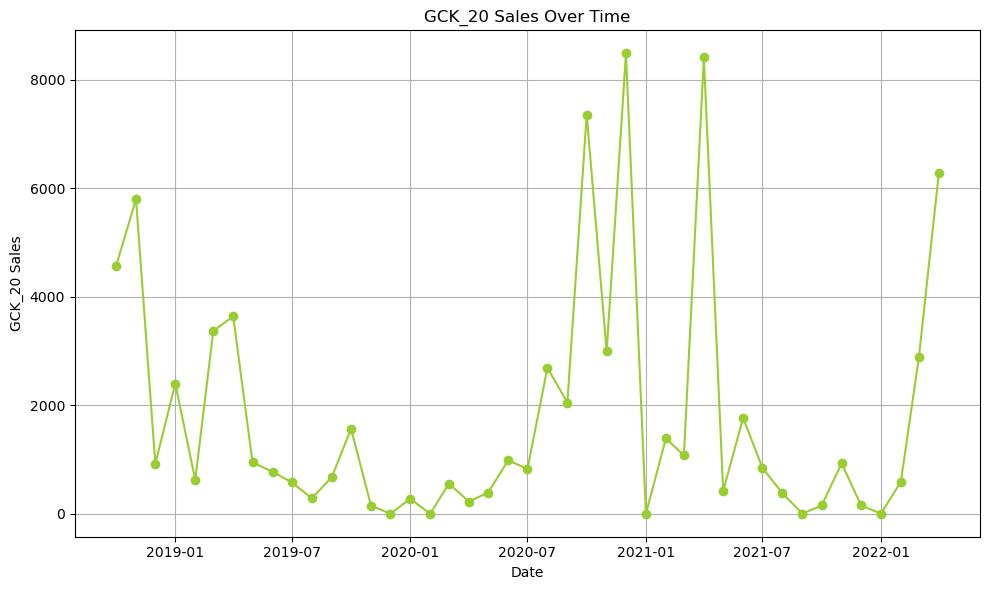

In [82]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_20['Date'], df_20['GCK_20'], marker='o', linestyle='-', color='yellowgreen')

# Adding labels and title
plt.title('GCK_20 Sales Over Time')
plt.xlabel('Date')
plt.ylabel('GCK_20 Sales')

# Show plot
plt.tight_layout()
plt.grid(True)
plt.show()

We can denote sales peak in november 2019, october and december 2020, as weel as april 2021 and 2022

In [83]:
# ADF test
result = adfuller(df_20['GCK_20'])
print('ADF test statistic:', result[0])
print('p-value:', result[1])
print('Critical values:', result[4])
if result[1] < 0.05:
    print('The time series is stationary')
else:
    print('The time series is non-stationary')

ADF test statistic: -3.1254576383830095
p-value: 0.024725679063600545
Critical values: {'1%': -3.60098336718852, '5%': -2.9351348158036012, '10%': -2.6059629803688282}
The time series is stationary


Product Group 20 is stationary meaning it is not time dependent. it means that its behavior does not exhibit trends, seasonality, or other systematic patterns that would make forecasting difficult.

In [84]:
# Function to create lagged DataFrame
def create_lagged_data(df, lag_months):
    # Copy the original DataFrame
    lagged_df = df.copy()
    # Shift the index by the specified number of months
    lagged_df.index = lagged_df.index - pd.DateOffset(months=lag_months)
    return lagged_df

# Create separate DataFrames for each monthly lag
for i in range(1, 13):  # for 12 months
    globals()[f"df_20_lag{i}"] = create_lagged_data(merged_data, i)

In [85]:
def create_lag_features(df, lag_months=12, exclude_vars=None):
    # If no variables are specified to exclude, initialize to an empty list
    if exclude_vars is None:
        exclude_vars = []

    # Make a copy of the original DataFrame
    df_with_lags = df.copy()

    # Loop through each column in the DataFrame
    for col in df.columns:
        # Check if the column is in the list of variables to exclude or if it's not suitable for lagging
        if col not in exclude_vars and col != 'Year' and col != 'Month' and col != 'Total Sales':
            # Create lagged features for the current column
            for i in range(1, lag_months + 1):
                df_with_lags[f"{col}_lag_{i}"] = df_with_lags[col].shift(i)

    return df_with_lags

#Source: ChatGPT

In [86]:
lagged_data_20 = create_lag_features(merged_data, lag_months=12, exclude_vars=["Year", "Month", "Total Sales"])
lagged_data_20.head(10)

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_40756\394514932.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_lags[f"{col}_lag_{i}"] = df_with_lags[col].shift(i)
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_40756\394514932.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_lags[f"{col}_lag_{i}"] = df_with_lags[col].shift(i)
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_40756\394514932.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

Month  Year  China Production Index ME  \
Date                                                 
2018-10-01     10  2018                 211.955755   
2018-11-01     11  2018                 220.519655   
2018-12-01     12  2018                 241.846854   
2019-01-01      1  2019                 175.668147   
2019-02-01      2  2019                 175.668147   
2019-03-01      3  2019                 261.642802   
2019-04-01      4  2019                 219.595813   
2019-05-01      5  2019                 234.169196   
2019-06-01      6  2019                 261.126350   
2019-07-01      7  2019                 217.053447   

            France Production Index ME  Germany Production Index ME  \
Date                                                                  
2018-10-01                  108.280608                   124.227879   
2018-11-01                   99.636911                   127.404132   
2018-12-01                   94.690312                   120.518565   
2019-01-01                   90.143775                   104.776326   
2019-02-01                   92.551521                   109.597012   
2019-03-01                  107.861788                   122.534648   
2019-04-01                   98.677844                   110.612414   
2019-05-01                   94.779550                   115.712333   
2019-06-01                   98.978105                   108.917455   
2019-07-01                  100.354372                   117.126331   

            Italy Production Index ME  Japan Production Index ME  \
Date                                                               
2018-10-01                 118.350514                 125.209957   
2018-11-01                 107.719260                 122.624695   
2018-12-01                  88.783181                 122.991956   
2019-01-01                  99.275113                 105.514024   
2019-02-01                 104.586684                 114.466647   
2019-03-01                 114.299549                 141.637717   
2019-04-01                  99.732969                 107.150653   
2019-05-01                 118.006286                 108.940926   
2019-06-01                 108.231888                 117.747574   
2019-07-01                 114.705312                 118.878856   

            Switzerland Production Index ME  UK Production Index ME  \
Date                                                                  
2018-10-01                       109.077781              113.659322   
2018-11-01                       112.241491              115.088417   
2018-12-01                       115.405201              101.556108   
2019-01-01                       109.621788              101.799754   
2019-02-01                       103.838375              103.495768   
2019-03-01                        98.054962              120.754768   
2019-04-01                        97.088932              106.691164   
2019-05-01                        96.122902              109.719699   
2019-06-01                        95.156872              111.546958   
2019-07-01                        97.909288              110.593756   

            US Production Index ME  ...  Year_closure_boolean_lag_3  \
Date                                ...                               
2018-10-01              111.902540  ...                         NaN   
2018-11-01              110.880401  ...                         NaN   
2018-12-01              106.257796  ...                         NaN   
2019-01-01              107.510808  ...                         0.0   
2019-02-01              109.817608  ...                         0.0   
2019-03-01              111.664057  ...                         0.0   
2019-04-01              109.276379  ...                         0.0   
2019-05-01              110.063707  ...                         0.0   
2019-06-01              111.717569  ...                         0.0   
2019-07-01              103.461891  ...                    

In [87]:
lagged_data_20.columns.tolist()

['Month',
 'Year',
 'China Production Index ME',
 'France Production Index ME',
 'Germany Production Index ME',
 'Italy Production Index ME',
 'Japan Production Index ME',
 'Switzerland Production Index ME',
 'UK Production Index ME',
 'US Production Index ME',
 'Europe Production Index ME',
 'World Base Metals Price',
 'World Energy Price',
 'World: Price of Metals  & Minerals',
 'World Natural Gas Price Index',
 'World Crude Oil Average Price',
 'World Copper Price',
 'US Producer Prices EE',
 'UK Producer Prices EE',
 'Italy Producer Prices EE',
 'France Producer Prices EE',
 'Germany Producer Prices EE',
 'China Producer Prices EE',
 'US Machinery and Equipment NEC',
 'World Machinery and Equipment NEC',
 'Switzerland Machinery and Equipment NEC',
 'UK Machinery and Equipment NEC',
 'Italy Machinery and Equipment NEC',
 'Japan Machinery and Equipment NEC',
 'France Machinery and Equipment NEC',
 'Germany Machinery and Equipment NEC',
 'US Production Index EE',
 'World Production In

In [88]:
correlations = {}

# Iterate over columns to find lagged variables
lagged_variables = set()
for column in lagged_data_20.columns:
    if 'lag' in column.lower():
        variable_name = column.split("_")[0]  # Extract variable name from column name
        lagged_variables.add(variable_name)

# Iterate over lagged variables to find lag with highest correlation
for variable_name in lagged_variables:
    max_corr_value = -1  # Initialize max correlation value
    max_corr_lag = None  # Initialize lag with max correlation
    for lag_column in lagged_data_20.columns:
        if 'lag' in lag_column.lower() and variable_name in lag_column:
            # Calculate correlation for each lag column of the variable
            corr = lagged_data_20["Total Sales"].corr(lagged_data_20[lag_column])
            if corr > max_corr_value:
                max_corr_value = corr
                max_corr_lag = lag_column
    correlations[variable_name] = {"lag": max_corr_lag, "correlation": max_corr_value}

# Print results
for variable_name, data in correlations.items():
    print(data['lag'])

# Source: ChatGPT

Italy Production Index EE_lag_5
China Production Index ME_lag_11
Europe Production Index ME_lag_9
Switzerland Machinery and Equipment NEC_lag_9
US Machinery and Equipment NEC_lag_6
Switzerland Production Index ME_lag_7
US Producer Prices EE_lag_1
France Production Index EE_lag_9
France Production Index ME_lag_9
UK Producer Prices EE_lag_12
Italy Machinery and Equipment NEC_lag_5
China Producer Prices EE_lag_2
Germany Production Index EE_lag_5
Italy Producer Prices EE_lag_2
US Production Index EE_lag_6
World Machinery and Equipment NEC_lag_6
Switzerland Production Index EE_lag_7
UK Production Index EE_lag_8
Covid_boolean_lag_12
World Base Metals Price_lag_8
World Natural Gas Price Index_lag_8
Italy Production Index ME_lag_5
France Machinery and Equipment NEC_lag_9
Germany Machinery and Equipment NEC_lag_9
UK Machinery and Equipment NEC_lag_6
Year_closure_boolean_lag_2
France Producer Prices EE_lag_1
Germany Producer Prices EE_lag_1
World Crude Oil Average Price_lag_2
World Production In

In [89]:
# Select the variables to include in the new dataset
lagged_variables = [
    'World Energy Price_lag_8', 'Italy Production Index ME_lag_5', 'Switzerland Production Index EE_lag_7',
    'UK Production Index ME_lag_6', 'Europe Production Index ME_lag_9', 'World Copper Price_lag_8',
    'UK Producer Prices EE_lag_12', 'Germany Production Index EE_lag_5', 'Germany Production Index ME_lag_9',
    'World Production Index EE_lag_11', 'Japan Production Index ME_lag_6', 'World Base Metals Price_lag_8',
    'Covid_boolean_lag_12', 'Italy Machinery and Equipment NEC_lag_5', 'Year_closure_boolean_lag_2',
    'US Production Index EE_lag_6', 'Switzerland Production Index ME_lag_7', 'France Production Index ME_lag_9',
    'US Production Index ME_lag_6', 'Japan Machinery and Equipment NEC_lag_6', 'World Machinery and Equipment NEC_lag_6',
    'China Production Index ME_lag_11', 'Japan Production Index EE_lag_6', 'Italy Production Index EE_lag_5',
    'Germany Producer Prices EE_lag_1', 'France Machinery and Equipment NEC_lag_9', 'World: Price of Metals  & Minerals_lag_2',
    'UK Production Index EE_lag_8', 'UK Machinery and Equipment NEC_lag_6', 'Switzerland Machinery and Equipment NEC_lag_9',
    'China Producer Prices EE_lag_2', 'France Producer Prices EE_lag_1', 'US Machinery and Equipment NEC_lag_6',
    'US Producer Prices EE_lag_1', 'World Natural Gas Price Index_lag_8', 'World Crude Oil Average Price_lag_2',
    'Italy Producer Prices EE_lag_2', 'France Production Index EE_lag_9', 'Germany Machinery and Equipment NEC_lag_9'
]

# Create a new DataFrame with lagged variables aligned with the index of 'merged_data'
best_lags_20 = lagged_data_20[lagged_variables].loc[merged_data.index]

# Display the new dataset
best_lags_20.head(10)

World Energy Price_lag_8  Italy Production Index ME_lag_5  \
Date                                                                    
2018-10-01                       NaN                              NaN   
2018-11-01                       NaN                              NaN   
2018-12-01                       NaN                              NaN   
2019-01-01                       NaN                              NaN   
2019-02-01                       NaN                              NaN   
2019-03-01                       NaN                       118.350514   
2019-04-01                       NaN                       107.719260   
2019-05-01                       NaN                        88.783181   
2019-06-01                100.222169                        99.275113   
2019-07-01                 84.436807                       104.586684   

            Switzerland Production Index EE_lag_7  \
Date                                                
2018-10-01                                    NaN   
2018-11-01                                    NaN   
2018-12-01                                    NaN   
2019-01-01                                    NaN   
2019-02-01                                    NaN   
2019-03-01                                    NaN   
2019-04-01                                    NaN   
2019-05-01                             112.970843   
2019-06-01                             114.736013   
2019-07-01                             116.501182   

            UK Production Index ME_lag_6  Europe Production Index ME_lag_9  \
Date                                                                         
2018-10-01                           NaN                               NaN   
2018-11-01                           NaN                               NaN   
2018-12-01                           NaN                               NaN   
2019-01-01                           NaN                               NaN   
2019-02-01                           NaN                               NaN   
2019-03-01                           NaN                               NaN   
2019-04-01                    113.659322                               NaN   
2019-05-01                    115.088417                               NaN   
2019-06-01                    101.556108                               NaN   
2019-07-01                    101.799754                        124.391967   

            World Copper Price_lag_8  UK Producer Prices EE_lag_12  \
Date                                                                 
2018-10-01                       NaN                           NaN   
2018-11-01                       NaN                           NaN   
2018-12-01                       NaN                           NaN   
2019-01-01                       NaN                           NaN   
2019-02-01                       NaN                           NaN   
2019-03-01                       NaN                           NaN   
2019-04-01                       NaN                           NaN   
2019-05-01                       NaN                           NaN   
2019-06-01                 82.545082                           NaN   
2019-07-01                 82.230939                           NaN   

            Germany Production Index EE_lag_5  \
Date                                            
2018-10-01                                NaN   
2018-11-01                                NaN   
2018-12-01                                NaN   
2019-01-01                                NaN   
2019-02-01                                NaN   
2019-03-01                         118.298233   
2019-04-01                         117.163727   
2019-05-01                          89.626122   
2019-06-01                         105.406097   
2019-07-01                         103.652771   

            Germany Production Index ME_lag_9  \
Date                                            
2018-10-01                       

In [90]:
# Merge the DataFrames based on the common column
best_lags_20 = pd.merge(best_lags_20, merged_data[['Total Sales']], on='Date', how='left')
best_lags_20.head(10)

World Energy Price_lag_8  Italy Production Index ME_lag_5  \
Date                                                                    
2018-10-01                       NaN                              NaN   
2018-11-01                       NaN                              NaN   
2018-12-01                       NaN                              NaN   
2019-01-01                       NaN                              NaN   
2019-02-01                       NaN                              NaN   
2019-03-01                       NaN                       118.350514   
2019-04-01                       NaN                       107.719260   
2019-05-01                       NaN                        88.783181   
2019-06-01                100.222169                        99.275113   
2019-07-01                 84.436807                       104.586684   

            Switzerland Production Index EE_lag_7  \
Date                                                
2018-10-01                                    NaN   
2018-11-01                                    NaN   
2018-12-01                                    NaN   
2019-01-01                                    NaN   
2019-02-01                                    NaN   
2019-03-01                                    NaN   
2019-04-01                                    NaN   
2019-05-01                             112.970843   
2019-06-01                             114.736013   
2019-07-01                             116.501182   

            UK Production Index ME_lag_6  Europe Production Index ME_lag_9  \
Date                                                                         
2018-10-01                           NaN                               NaN   
2018-11-01                           NaN                               NaN   
2018-12-01                           NaN                               NaN   
2019-01-01                           NaN                               NaN   
2019-02-01                           NaN                               NaN   
2019-03-01                           NaN                               NaN   
2019-04-01                    113.659322                               NaN   
2019-05-01                    115.088417                               NaN   
2019-06-01                    101.556108                               NaN   
2019-07-01                    101.799754                        124.391967   

            World Copper Price_lag_8  UK Producer Prices EE_lag_12  \
Date                                                                 
2018-10-01                       NaN                           NaN   
2018-11-01                       NaN                           NaN   
2018-12-01                       NaN                           NaN   
2019-01-01                       NaN                           NaN   
2019-02-01                       NaN                           NaN   
2019-03-01                       NaN                           NaN   
2019-04-01                       NaN                           NaN   
2019-05-01                       NaN                           NaN   
2019-06-01                 82.545082                           NaN   
2019-07-01                 82.230939                           NaN   

            Germany Production Index EE_lag_5  \
Date                                            
2018-10-01                                NaN   
2018-11-01                                NaN   
2018-12-01                                NaN   
2019-01-01                                NaN   
2019-02-01                                NaN   
2019-03-01                         118.298233   
2019-04-01                         117.163727   
2019-05-01                          89.626122   
2019-06-01                         105.406097   
2019-07-01                         103.652771   

            Germany Production Index ME_lag_9  \
Date                                            
2018-10-01                       

### Train/ Test Split

This allows you to evaluate your model's performance on multiple test sets across different time periods

In [108]:
# Sort the data by date for both datasets
df_20 = df_20.sort_values(by='Date')
best_lags_20 = best_lags_20.sort_values(by='Date')

# Define the sliding window parameters for both datasets
window_size = 6  # Weeks of training data
test_size = 2    # Weeks of testing data
gap = 0          # Gap between the end of training and start of testing

# Calculate total number of splits for both datasets
num_splits_sales = (len(df_20) - window_size - test_size + 1) // (window_size + test_size)
num_splits_market = (len(best_lags_20) - window_size - test_size + 1) // (window_size + test_size)

# Initialize TimeSeriesSplit with the number of splits for both datasets
tscv_sales = TimeSeriesSplit(n_splits=num_splits_sales)
tscv_market = TimeSeriesSplit(n_splits=num_splits_market)

# Lists to store train-test splits for both datasets
train_indices_sales = []
test_indices_sales = []
train_indices_market = []
test_indices_market = []

# Generate train-test splits using sliding window approach for monthly sales dataset
for train_index, test_index in tscv_sales.split(df_20):
    train_indices_sales.append(train_index)
    test_indices_sales.append(test_index)

# Generate train-test splits using sliding window approach for market dataset
for train_index, test_index in tscv_market.split(best_lags_20):
    train_indices_market.append(train_index)
    test_indices_market.append(test_index)

# Extracting data for each train-test split for monthly sales dataset
for i in range(len(train_indices_sales)):
    train_start = train_indices_sales[i][0]
    train_end = train_start + window_size
    test_start = train_end + gap
    test_end = test_start + test_size

    train_data_sales_20 = df_20.iloc[train_start:train_end]
    train_target_sales = train_data_sales_20['GCK_20']
    
    test_data_sales_20 = df_20.iloc[test_start:test_end]
    test_target_sales = test_data_sales_20['GCK_20']

# Extracting data for each train-test split for market dataset
for i in range(len(train_indices_market)):
    train_start = train_indices_market[i][0]
    train_end = train_start + window_size
    test_start = train_end + gap
    test_end = test_start + test_size

    train_data_market_20 = best_lags_20.iloc[train_start:train_end]
    # Assuming 'Total Sales' is the target variable in your market dataset as well
    train_target_market = train_data_market_20['Total Sales']
    
    test_data_market_20 = best_lags_20.iloc[test_start:test_end]
    test_target_market = test_data_market_20['Total Sales']

# Source: ChatGPT

In [109]:
train_size = len(train_data_sales_20) - len(test_data_sales_20)
print("Size of the sales train set:", train_size)

test_size = len(test_data_market_20)
print("Size of the market test set:", test_size)

#Source: ChatGPT

Size of the sales train set: 4
Size of the market test set: 2


### Feature Selection

## Product Group 36

In [91]:
# Create a new dataframe displaying only the sales for GCK 36 
df_36 = extract_product_sales(monthly_sales, 'GCK_36')
df_36.head(10)

Date    GCK_36
0 2018-10-01   6474.60
1 2018-11-01  21986.89
2 2018-12-01  13924.52
3 2019-01-01  15444.39
4 2019-02-01   8051.15
5 2019-03-01   7373.42
6 2019-04-01   4526.60
7 2019-05-01  16905.32
8 2019-06-01  17296.03
9 2019-07-01  33334.41

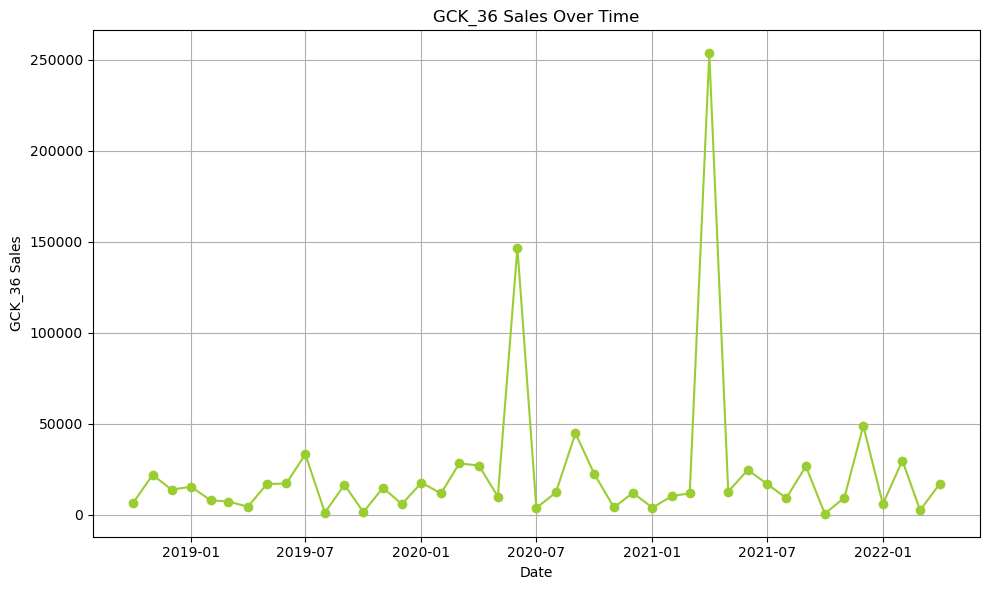

In [92]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_36['Date'], df_36['GCK_36'], marker='o', linestyle='-', color='yellowgreen')

# Adding labels and title
plt.title('GCK_36 Sales Over Time')
plt.xlabel('Date')
plt.ylabel('GCK_36 Sales')

# Show plot
plt.tight_layout()
plt.grid(True)
plt.show()

We can denote a sales peak in june 2020 and april 2021.

In [93]:
# ADF test
result = adfuller(df_36['GCK_36'])
print('ADF test statistic:', result[0])
print('p-value:', result[1])
print('Critical values:', result[4])
if result[1] < 0.05:
    print('The time series is stationary')
else:
    print('The time series is non-stationary')

ADF test statistic: -7.007142159329742
p-value: 7.074123428812795e-10
Critical values: {'1%': -3.596635636000432, '5%': -2.933297331821618, '10%': -2.6049909750566895}
The time series is stationary


Product Group 36 is stationary meaning it is not time dependent. it means that its behavior does not exhibit trends, seasonality, or other systematic patterns that would make forecasting difficult.

In [94]:
lagged_data_36 = create_lag_features(merged_data, lag_months=12, exclude_vars=["Year", "Month", "Total Sales"])
lagged_data_36.head(10)

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_40756\394514932.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_lags[f"{col}_lag_{i}"] = df_with_lags[col].shift(i)
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_40756\394514932.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_lags[f"{col}_lag_{i}"] = df_with_lags[col].shift(i)
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_40756\394514932.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

Month  Year  China Production Index ME  \
Date                                                 
2018-10-01     10  2018                 211.955755   
2018-11-01     11  2018                 220.519655   
2018-12-01     12  2018                 241.846854   
2019-01-01      1  2019                 175.668147   
2019-02-01      2  2019                 175.668147   
2019-03-01      3  2019                 261.642802   
2019-04-01      4  2019                 219.595813   
2019-05-01      5  2019                 234.169196   
2019-06-01      6  2019                 261.126350   
2019-07-01      7  2019                 217.053447   

            France Production Index ME  Germany Production Index ME  \
Date                                                                  
2018-10-01                  108.280608                   124.227879   
2018-11-01                   99.636911                   127.404132   
2018-12-01                   94.690312                   120.518565   
2019-01-01                   90.143775                   104.776326   
2019-02-01                   92.551521                   109.597012   
2019-03-01                  107.861788                   122.534648   
2019-04-01                   98.677844                   110.612414   
2019-05-01                   94.779550                   115.712333   
2019-06-01                   98.978105                   108.917455   
2019-07-01                  100.354372                   117.126331   

            Italy Production Index ME  Japan Production Index ME  \
Date                                                               
2018-10-01                 118.350514                 125.209957   
2018-11-01                 107.719260                 122.624695   
2018-12-01                  88.783181                 122.991956   
2019-01-01                  99.275113                 105.514024   
2019-02-01                 104.586684                 114.466647   
2019-03-01                 114.299549                 141.637717   
2019-04-01                  99.732969                 107.150653   
2019-05-01                 118.006286                 108.940926   
2019-06-01                 108.231888                 117.747574   
2019-07-01                 114.705312                 118.878856   

            Switzerland Production Index ME  UK Production Index ME  \
Date                                                                  
2018-10-01                       109.077781              113.659322   
2018-11-01                       112.241491              115.088417   
2018-12-01                       115.405201              101.556108   
2019-01-01                       109.621788              101.799754   
2019-02-01                       103.838375              103.495768   
2019-03-01                        98.054962              120.754768   
2019-04-01                        97.088932              106.691164   
2019-05-01                        96.122902              109.719699   
2019-06-01                        95.156872              111.546958   
2019-07-01                        97.909288              110.593756   

            US Production Index ME  ...  Year_closure_boolean_lag_3  \
Date                                ...                               
2018-10-01              111.902540  ...                         NaN   
2018-11-01              110.880401  ...                         NaN   
2018-12-01              106.257796  ...                         NaN   
2019-01-01              107.510808  ...                         0.0   
2019-02-01              109.817608  ...                         0.0   
2019-03-01              111.664057  ...                         0.0   
2019-04-01              109.276379  ...                         0.0   
2019-05-01              110.063707  ...                         0.0   
2019-06-01              111.717569  ...                         0.0   
2019-07-01              103.461891  ...                    

In [95]:
lagged_data_36.columns.tolist()

['Month',
 'Year',
 'China Production Index ME',
 'France Production Index ME',
 'Germany Production Index ME',
 'Italy Production Index ME',
 'Japan Production Index ME',
 'Switzerland Production Index ME',
 'UK Production Index ME',
 'US Production Index ME',
 'Europe Production Index ME',
 'World Base Metals Price',
 'World Energy Price',
 'World: Price of Metals  & Minerals',
 'World Natural Gas Price Index',
 'World Crude Oil Average Price',
 'World Copper Price',
 'US Producer Prices EE',
 'UK Producer Prices EE',
 'Italy Producer Prices EE',
 'France Producer Prices EE',
 'Germany Producer Prices EE',
 'China Producer Prices EE',
 'US Machinery and Equipment NEC',
 'World Machinery and Equipment NEC',
 'Switzerland Machinery and Equipment NEC',
 'UK Machinery and Equipment NEC',
 'Italy Machinery and Equipment NEC',
 'Japan Machinery and Equipment NEC',
 'France Machinery and Equipment NEC',
 'Germany Machinery and Equipment NEC',
 'US Production Index EE',
 'World Production In

In [96]:
correlations = {}

# Iterate over columns to find lagged variables
lagged_variables = set()
for column in lagged_data_36.columns:
    if 'lag' in column.lower():
        variable_name = column.split("_")[0]  # Extract variable name from column name
        lagged_variables.add(variable_name)

# Iterate over lagged variables to find lag with highest correlation
for variable_name in lagged_variables:
    max_corr_value = -1  # Initialize max correlation value
    max_corr_lag = None  # Initialize lag with max correlation
    for lag_column in lagged_data_36.columns:
        if 'lag' in lag_column.lower() and variable_name in lag_column:
            # Calculate correlation for each lag column of the variable
            corr = lagged_data_36["Total Sales"].corr(lagged_data_36[lag_column])
            if corr > max_corr_value:
                max_corr_value = corr
                max_corr_lag = lag_column
    correlations[variable_name] = {"lag": max_corr_lag, "correlation": max_corr_value}

# Print results
for variable_name, data in correlations.items():
    print(data['lag'])

# Source: ChatGPT

Italy Production Index EE_lag_5
China Production Index ME_lag_11
Europe Production Index ME_lag_9
Switzerland Machinery and Equipment NEC_lag_9
US Machinery and Equipment NEC_lag_6
Switzerland Production Index ME_lag_7
US Producer Prices EE_lag_1
France Production Index EE_lag_9
France Production Index ME_lag_9
UK Producer Prices EE_lag_12
Italy Machinery and Equipment NEC_lag_5
China Producer Prices EE_lag_2
Germany Production Index EE_lag_5
Italy Producer Prices EE_lag_2
US Production Index EE_lag_6
World Machinery and Equipment NEC_lag_6
Switzerland Production Index EE_lag_7
UK Production Index EE_lag_8
Covid_boolean_lag_12
World Base Metals Price_lag_8
World Natural Gas Price Index_lag_8
Italy Production Index ME_lag_5
France Machinery and Equipment NEC_lag_9
Germany Machinery and Equipment NEC_lag_9
UK Machinery and Equipment NEC_lag_6
Year_closure_boolean_lag_2
France Producer Prices EE_lag_1
Germany Producer Prices EE_lag_1
World Crude Oil Average Price_lag_2
World Production In

In [97]:
# Select the lagged variables listed above
lagged_variables = [
    'World Energy Price_lag_8', 'Italy Production Index ME_lag_5', 'Switzerland Production Index EE_lag_7',
    'UK Production Index ME_lag_6', 'Europe Production Index ME_lag_9', 'World Copper Price_lag_8',
    'UK Producer Prices EE_lag_12', 'Germany Production Index EE_lag_5', 'Germany Production Index ME_lag_9',
    'World Production Index EE_lag_11', 'Japan Production Index ME_lag_6', 'World Base Metals Price_lag_8',
    'Covid_boolean_lag_12', 'Italy Machinery and Equipment NEC_lag_5', 'Year_closure_boolean_lag_2',
    'US Production Index EE_lag_6', 'Switzerland Production Index ME_lag_7', 'France Production Index ME_lag_9',
    'US Production Index ME_lag_6', 'Japan Machinery and Equipment NEC_lag_6', 'World Machinery and Equipment NEC_lag_6',
    'China Production Index ME_lag_11', 'Japan Production Index EE_lag_6', 'Italy Production Index EE_lag_5',
    'Germany Producer Prices EE_lag_1', 'France Machinery and Equipment NEC_lag_9', 'World: Price of Metals  & Minerals_lag_2',
    'UK Production Index EE_lag_8', 'UK Machinery and Equipment NEC_lag_6', 'Switzerland Machinery and Equipment NEC_lag_9',
    'China Producer Prices EE_lag_2', 'France Producer Prices EE_lag_1', 'US Machinery and Equipment NEC_lag_6',
    'US Producer Prices EE_lag_1', 'World Natural Gas Price Index_lag_8', 'World Crude Oil Average Price_lag_2',
    'Italy Producer Prices EE_lag_2', 'France Production Index EE_lag_9', 'Germany Machinery and Equipment NEC_lag_9'
]

# Create a new DataFrame with lagged variables aligned with the index of 'merged_data'
best_lags_36 = lagged_data_36[lagged_variables].loc[merged_data.index]

# Display the new dataset
best_lags_36.head(10)

World Energy Price_lag_8  Italy Production Index ME_lag_5  \
Date                                                                    
2018-10-01                       NaN                              NaN   
2018-11-01                       NaN                              NaN   
2018-12-01                       NaN                              NaN   
2019-01-01                       NaN                              NaN   
2019-02-01                       NaN                              NaN   
2019-03-01                       NaN                       118.350514   
2019-04-01                       NaN                       107.719260   
2019-05-01                       NaN                        88.783181   
2019-06-01                100.222169                        99.275113   
2019-07-01                 84.436807                       104.586684   

            Switzerland Production Index EE_lag_7  \
Date                                                
2018-10-01                                    NaN   
2018-11-01                                    NaN   
2018-12-01                                    NaN   
2019-01-01                                    NaN   
2019-02-01                                    NaN   
2019-03-01                                    NaN   
2019-04-01                                    NaN   
2019-05-01                             112.970843   
2019-06-01                             114.736013   
2019-07-01                             116.501182   

            UK Production Index ME_lag_6  Europe Production Index ME_lag_9  \
Date                                                                         
2018-10-01                           NaN                               NaN   
2018-11-01                           NaN                               NaN   
2018-12-01                           NaN                               NaN   
2019-01-01                           NaN                               NaN   
2019-02-01                           NaN                               NaN   
2019-03-01                           NaN                               NaN   
2019-04-01                    113.659322                               NaN   
2019-05-01                    115.088417                               NaN   
2019-06-01                    101.556108                               NaN   
2019-07-01                    101.799754                        124.391967   

            World Copper Price_lag_8  UK Producer Prices EE_lag_12  \
Date                                                                 
2018-10-01                       NaN                           NaN   
2018-11-01                       NaN                           NaN   
2018-12-01                       NaN                           NaN   
2019-01-01                       NaN                           NaN   
2019-02-01                       NaN                           NaN   
2019-03-01                       NaN                           NaN   
2019-04-01                       NaN                           NaN   
2019-05-01                       NaN                           NaN   
2019-06-01                 82.545082                           NaN   
2019-07-01                 82.230939                           NaN   

            Germany Production Index EE_lag_5  \
Date                                            
2018-10-01                                NaN   
2018-11-01                                NaN   
2018-12-01                                NaN   
2019-01-01                                NaN   
2019-02-01                                NaN   
2019-03-01                         118.298233   
2019-04-01                         117.163727   
2019-05-01                          89.626122   
2019-06-01                         105.406097   
2019-07-01                         103.652771   

            Germany Production Index ME_lag_9  \
Date                                            
2018-10-01                       

In [101]:
# Merge the DataFrames based on the common column
best_lags_36 = pd.merge(best_lags_36, merged_data[['Total Sales']], on='Date', how='left')
best_lags_36.head(10)

World Energy Price_lag_8  Italy Production Index ME_lag_5  \
Date                                                                    
2018-10-01                       NaN                              NaN   
2018-11-01                       NaN                              NaN   
2018-12-01                       NaN                              NaN   
2019-01-01                       NaN                              NaN   
2019-02-01                       NaN                              NaN   
2019-03-01                       NaN                       118.350514   
2019-04-01                       NaN                       107.719260   
2019-05-01                       NaN                        88.783181   
2019-06-01                100.222169                        99.275113   
2019-07-01                 84.436807                       104.586684   

            Switzerland Production Index EE_lag_7  \
Date                                                
2018-10-01                                    NaN   
2018-11-01                                    NaN   
2018-12-01                                    NaN   
2019-01-01                                    NaN   
2019-02-01                                    NaN   
2019-03-01                                    NaN   
2019-04-01                                    NaN   
2019-05-01                             112.970843   
2019-06-01                             114.736013   
2019-07-01                             116.501182   

            UK Production Index ME_lag_6  Europe Production Index ME_lag_9  \
Date                                                                         
2018-10-01                           NaN                               NaN   
2018-11-01                           NaN                               NaN   
2018-12-01                           NaN                               NaN   
2019-01-01                           NaN                               NaN   
2019-02-01                           NaN                               NaN   
2019-03-01                           NaN                               NaN   
2019-04-01                    113.659322                               NaN   
2019-05-01                    115.088417                               NaN   
2019-06-01                    101.556108                               NaN   
2019-07-01                    101.799754                        124.391967   

            World Copper Price_lag_8  UK Producer Prices EE_lag_12  \
Date                                                                 
2018-10-01                       NaN                           NaN   
2018-11-01                       NaN                           NaN   
2018-12-01                       NaN                           NaN   
2019-01-01                       NaN                           NaN   
2019-02-01                       NaN                           NaN   
2019-03-01                       NaN                           NaN   
2019-04-01                       NaN                           NaN   
2019-05-01                       NaN                           NaN   
2019-06-01                 82.545082                           NaN   
2019-07-01                 82.230939                           NaN   

            Germany Production Index EE_lag_5  \
Date                                            
2018-10-01                                NaN   
2018-11-01                                NaN   
2018-12-01                                NaN   
2019-01-01                                NaN   
2019-02-01                                NaN   
2019-03-01                         118.298233   
2019-04-01                         117.163727   
2019-05-01                          89.626122   
2019-06-01                         105.406097   
2019-07-01                         103.652771   

            Germany Production Index ME_lag_9  \
Date                                            
2018-10-01                       

### Train/ Test Split

This allows you to evaluate your model's performance on multiple test sets across different time periods

In [106]:
# Sort the data by date for both datasets
df_36 = df_36.sort_values(by='Date')
best_lags_36 = best_lags_36.sort_values(by='Date')

# Define the sliding window parameters for both datasets
window_size = 6  # Weeks of training data
test_size = 2    # Weeks of testing data
gap = 0          # Gap between the end of training and start of testing

# Calculate total number of splits for both datasets
num_splits_sales = (len(df_36) - window_size - test_size + 1) // (window_size + test_size)
num_splits_market = (len(best_lags_36) - window_size - test_size + 1) // (window_size + test_size)

# Initialize TimeSeriesSplit with the number of splits for both datasets
tscv_sales = TimeSeriesSplit(n_splits=num_splits_sales)
tscv_market = TimeSeriesSplit(n_splits=num_splits_market)

# Lists to store train-test splits for both datasets
train_indices_sales = []
test_indices_sales = []
train_indices_market = []
test_indices_market = []

# Generate train-test splits using sliding window approach for monthly sales dataset
for train_index, test_index in tscv_sales.split(df_36):
    train_indices_sales.append(train_index)
    test_indices_sales.append(test_index)

# Generate train-test splits using sliding window approach for market dataset
for train_index, test_index in tscv_market.split(best_lags_36):
    train_indices_market.append(train_index)
    test_indices_market.append(test_index)

# Extracting data for each train-test split for monthly sales dataset
for i in range(len(train_indices_sales)):
    train_start = train_indices_sales[i][0]
    train_end = train_start + window_size
    test_start = train_end + gap
    test_end = test_start + test_size

    train_data_sales_36 = df_36.iloc[train_start:train_end]
    train_target_sales = train_data_sales_36['GCK_36']
    
    test_data_sales_36 = df_36.iloc[test_start:test_end]
    test_target_sales = test_data_sales_36['GCK_36']

# Extracting data for each train-test split for market dataset
for i in range(len(train_indices_market)):
    train_start = train_indices_market[i][0]
    train_end = train_start + window_size
    test_start = train_end + gap
    test_end = test_start + test_size

    train_data_market_36 = best_lags_36.iloc[train_start:train_end]
    # Assuming 'Total Sales' is the target variable in your market dataset as well
    train_target_market = train_data_market_36['Total Sales']
    
    test_data_market_36 = best_lags_36.iloc[test_start:test_end]
    test_target_market = test_data_market_36['Total Sales']

# Source: ChatGPT

In [107]:
train_size = len(train_data_sales_36) - len(test_data_sales_36)
print("Size of the sales train set:", train_size)
            
test_size = len(test_data_market_36)
print("Size of the market test set:", test_size)

#Source: ChatGPT

Size of the sales train set: 4
Size of the market test set: 2


# Deal with Missing Values

In [ ]:
# linear interpolation market data

# Deal with Outliers

In [ ]:
# Winsorizing outliers (only on the upper end)
numeric_columns = train_data.select_dtypes(include=[np.number]).columns

for col in numeric_columns:
    train_data[col] = winsorize(train_data[col], limits=[None, 0.1])

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_3680\86454680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[col] = winsorize(train_data[col], limits=[None, 0.1])


# Data Scaling

In [ ]:
# Initialize the RobustScaler
scaler = RobustScaler()

# Fit the scaler to your training data and transform it
scaled_train_data = scaler.fit_transform(train_data)

# Transform the test data using the same scaler
scaled_test_data = scaler.transform(test_data)

# Convert the scaled data into a dataframe
X_scaled_train= pd.DataFrame(scaled_train_data, columns= train_data.columns,index= train_data.index)
X_scaled_test = pd.DataFrame(scaled_test_data, columns= test_data.columns,index= test_data.index)

TypeError: float() argument must be a string or a real number, not 'Timestamp'

# Feature Selection

In [ ]:
# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_scaled_train, train_target)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Print feature importances
for i, idx in enumerate(sorted_indices):
    print(f"Feature {i+1}: {X_scaled_train.columns[idx]} - Importance: {feature_importances[idx]}")

# Select top features based on a threshold or a fixed number of features
threshold = 0.01  
selected_features = X_scaled_train.columns[sorted_indices[feature_importances[sorted_indices] > threshold]]

# Now selected_features contains the names of the top features based on their importance
print("Selected Features:", selected_features)

#Source: ChatGPT

NameError: name 'X_scaled_train' is not defined

In [ ]:
# Train Random Forest model
model = RandomForestRegressor()
model.fit(X_scaled_train, train_target)
   
feature_importance = model.feature_importances_

feature_importance_pairs = list(zip(X_scaled_train.columns, feature_importance))
feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)
for pair in feature_importance_pairs:
    print(pair)

#getting feature indices and importance scores
feature_indices, importance_scores = zip(*feature_importance_pairs)

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_indices)), importance_scores, tick_label=feature_indices, color='yellowgreen')

plt.xticks(range(len(feature_indices)), feature_indices, rotation='vertical')
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importance')
plt.show()

#Source: previous course's notebook

NameError: name 'X_scaled_train' is not defined

# Modelling - SARIMAX

In [ ]:
# Train SARIMA model
sarima_model = SARIMAX(X_scaled_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Make predictions using SARIMA
sarima_predictions = sarima_result.predict(start=len(X_scaled_train)-len(test_data), end=len(X_scaled_train)-1, dynamic=False)

# Evaluate SARIMA model's performance
sarima_rmse = np.sqrt(mean_squared_error(X_scaled_train[-len(test_data):], sarima_predictions))
print("SARIMA RMSE:", sarima_rmse)

#Source: ChatGPT

# Modelling - Catboost

In [ ]:
# Initialize the CatBoostRegressor
model = CatBoostRegressor(loss_function='RMSE', eval_metric='RMSE')

# Train the model
model.fit(train_data, train_target, verbose=100)

# Make predictions
y_pred = model.predict(test_data)

#Source: ChatGPT

# Model Evaluation - RMSE

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_target, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

#Source: ChatGPT

-------

# Lag Features

To make a lag feature we shift the observations of the target series so that they appear to have occured later in time. Here we've created a 1-step lag feature.

In [ ]:
# Convert 'Month' column to datetime format
df_month['Month'] = pd.to_datetime(df_month['Month'])

# Group by product and month, then sum up the sales
monthly_sales = df_month.groupby(['Mapped_GCK', pd.Grouper(key='Month', freq='M')])['Sales_EUR'].sum().reset_index()

# Create lag features
for i in range(1, 4):  # Assuming you want lags for 3 months
    monthly_sales[f'sales_lag_{i}'] = monthly_sales.groupby('Mapped_GCK')['Sales_EUR'].shift(i)

print(monthly_sales)

#Source: ChatGPT

In [ ]:
plot_acf(monthly_data['Sales_EUR'], lags=43)
plot_pacf(monthly_data['Sales_EUR'], lags=43)

#Source: ChatGPT

# Train/ Test Split

This allows you to evaluate your model's performance on multiple test sets across different time periods

In [ ]:
# Sort the data by date
sales_data = df_month.sort_values(by='DATE')

# Define the sliding window parameters
window_size = 6  # Weeks of training data
test_size = 2    # Weeks of testing data
gap = 0          # Gap between the end of training and start of testing

# Calculate total number of splits
num_splits = (len(sales_data) - window_size - test_size + 1) // (window_size + test_size)

# Initialize TimeSeriesSplit with the number of splits
tscv = TimeSeriesSplit(n_splits=num_splits)

# Lists to store train-test splits
train_indices = []
test_indices = []

# Generate train-test splits using sliding window approach
for train_index, test_index in tscv.split(sales_data):
    train_indices.append(train_index)
    test_indices.append(test_index)

# Extracting data for each train-test split
for i in range(len(train_indices)):
    train_start = train_indices[i][0]
    train_end = train_start + window_size
    test_start = train_end + gap
    test_end = test_start + test_size

    train_data = sales_data.iloc[train_start:train_end]
    train_target = train_data['Sales_EUR']
    
    test_data = sales_data.iloc[test_start:test_end]
    test_target = test_data['Sales_EUR']

#Source: ChatGPT

# Deal with Outliers

In [ ]:
# Winsorizing outliers (only on the upper end)
winsorized_data = winsorize(train_data.values, limits=[None, 0.1])  # Winsorize only the upper end

print("Original data:", train_data)
print("Winsorized data:", train_data)

#Source: ChatGPT

# Categorical Variables encoding

In [ ]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the categorical variable
train_data['Mapped_GCK_encoded'] = label_encoder.fit_transform(train_data['Mapped_GCK'])
train_data['Weekday_encoded'] = label_encoder.fit_transform(train_data['Weekday'])
train_data['Holiday_Status_encoded'] = label_encoder.fit_transform(train_data['Holiday_Status'])

train_data.drop(columns=['Mapped_GCK'], inplace=True)
train_data.drop(columns=['Weekday'], inplace=True)
train_data.drop(columns=['Holiday_Status'], inplace=True)

# Encode the categorical variable
test_data['Mapped_GCK_encoded'] = label_encoder.fit_transform(test_data['Mapped_GCK'])
test_data['Weekday_encoded'] = label_encoder.fit_transform(test_data['Weekday'])
test_data['Holiday_Status_encoded'] = label_encoder.fit_transform(test_data['Holiday_Status'])

test_data.drop(columns=['Mapped_GCK'], inplace=True)
test_data.drop(columns=['Weekday'], inplace=True)
test_data.drop(columns=['Holiday_Status'], inplace=True)

#Source: ChatGPT

# Data Scalling

In [ ]:
# Initialize the RobustScaler
scaler = RobustScaler()

# Fit the scaler to your training data and transform it
scaled_train_data = scaler.fit_transform(train_data)

# Transform the test data using the same scaler
scaled_test_data = scaler.transform(test_data)

# Convert the scaled data into a dataframe
X_scaled_train= pd.DataFrame(scaled_train_data, columns= train_data.columns,index= train_data.index)
X_scaled_test = pd.DataFrame(scaled_test_data, columns= test_data.columns,index= test_data.index)

# Feature Selection

In [ ]:
# Initialize Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf.fit(train_data, train_target)

# Extract feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame to store feature importances along with feature names
feature_importance_df = pd.DataFrame({'Feature': df.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
print(feature_importance_df)

# Select top k features based on importance
k = 5  # Change this value according to your preference
top_features = feature_importance_df.head(k)['Feature'].tolist()

# Filter the dataset to keep only the top features
X_train_selected = train_data[top_features]
X_test_selected = test_data[top_features]

#Source: ChatGPT

In [ ]:
# Train Random Forest model
model = RandomForestRegressor()
model.fit(train_data, train_target)
   
feature_importance = model.feature_importances_

feature_importance_pairs = list(zip(train_data.columns, feature_importance))
feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)
for pair in feature_importance_pairs:
    print(pair)

#getting feature indices and importance scores
feature_indices, importance_scores = zip(*feature_importance_pairs)

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_indices)), importance_scores, tick_label=feature_indices, color='yellowgreen')

plt.xticks(range(len(feature_indices)), feature_indices, rotation='vertical')
plt.xlabel('Feature Index')
plt.ylabel('Mean Decrease Impurity Score')
plt.title('Features Based on Mean Decrease Impurity')
plt.show()

#Source: previous course's notebook

# Modelling - SARIMA 

In [ ]:
# Train SARIMA model
sarima_model = SARIMAX(y, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Make predictions using SARIMA
sarima_predictions = sarima_result.predict(start=len(y)-len(test_data), end=len(y)-1, dynamic=False)

# Evaluate SARIMA model's performance
sarima_rmse = np.sqrt(mean_squared_error(y[-len(test_data):], sarima_predictions))
print("SARIMA RMSE:", sarima_rmse)

#Source: ChatGPT

# Modelling - Catboost

In [ ]:
# Initialize the CatBoostRegressor
model = CatBoostRegressor(loss_function='RMSE', eval_metric='RMSE')

# Train the model
model.fit(X_scaled_train, train_target, verbose=100)

# Make predictions
y_pred = model.predict(test_data)

#Source: ChatGPT

# Model Evaluation - RMSE

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_target, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

#Source: ChatGPT